In [1]:
# CHANGE ME: Set this to the path to the NuPlan data directory
NUPLAN_DATA_PATH = "~/nuplan-v1.1/splits/mini/"

In [2]:
import typing
from dataclasses import dataclass
import numpy as np
import numpy.typing as npt

@dataclass
class State:
    heading: float
    velocity: npt.NDArray[np.float64]


Observation: typing.TypeAlias = tuple[State, State]
Action: typing.TypeAlias = tuple[float, float]

In [20]:
import os
trajectories: list[list[State]] = []

def getFiles(path: str) -> list[str]:
    path = os.path.expanduser(path)
    files = [os.path.join(path, f) for f in os.listdir(path)]
    return sorted(f for f in files if os.path.isfile(f))

file_iter = iter(getFiles(NUPLAN_DATA_PATH))

In [21]:
import sqlite3
from scipy.spatial.transform import Rotation
from scipy.spatial.transform import Slerp
from scipy.ndimage import gaussian_filter1d


for file_path in file_iter:
    time_micros = []
    quaternions = []
    xs = []
    ys = []

    # gather headings and positions from sqlite3 database
    with sqlite3.connect(file_path) as conn:
        for (timestamp, qw, qx, qy, qz, x, y) in conn.cursor().execute("SELECT timestamp, qw, qx, qy, qz, x, y FROM ego_pose"):
            time_micros.append(timestamp)
            quaternions.append([qx, qy, qz, qw])
            xs.append(x)
            ys.append(y)

    if len(time_micros) == 0:
        print(f"Skipping {file_path} because it has no data")
        continue
    
    
    # convert time to seconds
    times = np.array(time_micros, dtype=np.float64) / 1e6

    # sample at 10Hz
    sample_times = np.arange(times[0], times[-1], 0.1)

    # get headings at sampled times
    rotation_interpolator = Slerp(times, Rotation.from_quat(quaternions))
    headings = rotation_interpolator(sample_times).as_euler('xyz')[:, 2]

    # get velocities at sampled times
    xvel_smoothed = gaussian_filter1d(np.diff(xs) / np.diff(times), sigma=30)
    yvel_smoothed = gaussian_filter1d(np.diff(ys) / np.diff(times), sigma=30)

    x_vel = np.interp(sample_times, times, xvel_smoothed)
    y_vel = np.interp(sample_times, times, yvel_smoothed)

    velocities = np.stack([x_vel, y_vel], axis=1)

    # create trajectory
    trajectory = [State(heading=h, velocity=v) for h, v in zip(headings, velocities)]
    trajectories.append(trajectory)
    print(f"Loaded trajectory of len {len(trajectory)} from {file_path}")

Loaded trajectory of len 5116 from /home/fidgetsinner/nuplan-v1.1/splits/mini/2021.05.12.22.00.38_veh-35_01008_01518.db
Loaded trajectory of len 5460 from /home/fidgetsinner/nuplan-v1.1/splits/mini/2021.05.12.22.28.35_veh-35_00620_01164.db
Loaded trajectory of len 3540 from /home/fidgetsinner/nuplan-v1.1/splits/mini/2021.05.12.23.36.44_veh-35_00152_00504.db
Loaded trajectory of len 4040 from /home/fidgetsinner/nuplan-v1.1/splits/mini/2021.05.12.23.36.44_veh-35_01133_01535.db
Loaded trajectory of len 3531 from /home/fidgetsinner/nuplan-v1.1/splits/mini/2021.05.12.23.36.44_veh-35_02035_02387.db
Loaded trajectory of len 4950 from /home/fidgetsinner/nuplan-v1.1/splits/mini/2021.05.25.14.16.10_veh-35_01690_02183.db
Loaded trajectory of len 3780 from /home/fidgetsinner/nuplan-v1.1/splits/mini/2021.06.03.12.02.06_veh-35_00233_00609.db
Loaded trajectory of len 3550 from /home/fidgetsinner/nuplan-v1.1/splits/mini/2021.06.03.13.55.17_veh-35_00073_00426.db
Loaded trajectory of len 4730 from /home

In [22]:
import pickle
import os
import lzma

# pickle the trajectories
if not os.path.exists('nuplan_data/trajectories.pkl.xz'):
    with lzma.open('nuplan_data/trajectories.pkl.xz', 'wb') as f:
        pickle.dump(trajectories, f)

In [3]:
import pickle
import lzma

# unpickle and decompress
if "trajectories" not in locals():
    with lzma.open('nuplan_data/trajectories.pkl.xz', 'rb') as f:
        trajectories:list[list[State]] = pickle.load(f)

In [4]:
import random

idm_data: list[Observation] = []
for states in trajectories:
    for i in range(len(states)-1):
        idm_data.append((states[i], states[i+1]))

# 90:10 train-validation split
random.seed(0)
random.shuffle(idm_data)
n_train = int(len(idm_data)*0.9)
idm_train_data = idm_data[:n_train]
idm_validation_data = idm_data[n_train:]

In [5]:
print("train data:", len(idm_train_data))
print("validation data:", len(idm_validation_data))

train data: 234603
validation data: 26067


In [6]:
import matplotlib.pyplot as plt
import metadrive
from metadrive import MetaDriveEnv
import gymnasium as gym
import torch
import torch.nn as nn
import torch.nn.functional as F



def deviceof(m: nn.Module) -> torch.device:
    """
    Get the device of the given module
    """
    return next(m.parameters()).device

def normalize_angle(angle: float) -> float:
    """
    Normalize the angle to [-pi, pi)
    """
    return (angle + np.pi) % (2 * np.pi) - np.pi

def get_metadrive_state(env: MetaDriveEnv) -> State:
    return State(heading=env.vehicle.heading_theta, velocity=env.vehicle.velocity[:2])

def next_state(env: MetaDriveEnv, s: State, a: Action) -> State:
    """
    runs the policy and returns the total reward
    """
    # reset
    env.reset()
    env.vehicle.set_position(env.vehicle.position, height=0.49)

    # allow car to settle
    for _ in range(5):
        env.step([0,0])

    # set the initial state
    env.vehicle.set_velocity(s.velocity)
    env.vehicle.set_heading_theta(s.heading)
    
    # run the simulator
    env.step(a)

    # get the new state
    s_prime = get_metadrive_state(env)

    # allow car to settle (if rendering)
    if env.config.use_render:
        for _ in range(10):
            env.step([0,0])

    return s_prime

def gen_random_action() -> Action:
    """
    Generates a random action with probabilities that are similar to that are found in the waymo dataset
    """
    a = tuple(np.random.normal(0, 0.5, 2))
    return a

def state_batch_to_tensor(states: list[State], device: torch.device) -> torch.Tensor:
    """
    Reshape the state from State to a tensor of shape (batch_size, 4)
    """
    velocities = torch.tensor(np.stack([st.velocity for st in states]), dtype=torch.float32, device=device)
    heading = torch.tensor([st.heading for st in states], dtype=torch.float32, device=device)
    return torch.cat([velocities, torch.cos(heading).unsqueeze(1), torch.sin(heading).unsqueeze(1)], dim=1)

def action_batch_to_tensor(actions: list[Action], device: torch.device) -> torch.Tensor:
    """
    Reshape the action from Action to a tensor of shape (batch_size, 2)
    """
    return torch.tensor(np.stack(actions), dtype=torch.float32, device=device)

def obs_batch_to_tensor(obs: list[Observation], device: torch.device) -> torch.Tensor:
    """
    Reshape the observation from tuple[State, State] to a tensor of shape (batch_size, 4, 2)
    """

    observations = []

    for st0, st1 in obs:
        observations.append(np.array([
            [st0.velocity[0], st1.velocity[0]], 
            [st0.velocity[1], st1.velocity[1]],
            [np.cos(st0.heading), np.cos(st1.heading)],
            [np.sin(st0.heading), np.sin(st1.heading)],
        ]))

    return torch.tensor(np.stack(observations), dtype=torch.float32, device=device)

Successfully registered the following environments: ['MetaDrive-validation-v0', 'MetaDrive-10env-v0', 'MetaDrive-100envs-v0', 'MetaDrive-1000envs-v0', 'SafeMetaDrive-validation-v0', 'SafeMetaDrive-10env-v0', 'SafeMetaDrive-100envs-v0', 'SafeMetaDrive-1000envs-v0', 'MARLTollgate-v0', 'MARLBottleneck-v0', 'MARLRoundabout-v0', 'MARLIntersection-v0', 'MARLParkingLot-v0', 'MARLMetaDrive-v0'].


In [26]:
def generate_data(s0_batch: list[State]) -> list[tuple[State, Action, State]]:
    env = MetaDriveEnv(config={"on_continuous_line_done": False, "use_render": False})
    dataset: list[tuple[State, Action, State]] = []
    for s0 in s0_batch:
        a = gen_random_action()
        s1 = next_state(env, s0, a)
        dataset.append((s0, a, s1))
    env.close()
    return dataset

In [27]:
from concurrent.futures import ProcessPoolExecutor
from metadrive import MetaDriveEnv

MAX_WORKERS = 16

mm_train_data: list[tuple[State, Action, State]] = []

with ProcessPoolExecutor(max_workers=MAX_WORKERS) as executor:
    batch_size, leftover_size = divmod(len(idm_train_data), MAX_WORKERS)
    
    # Distribute the data evenly among workers
    n_scenarios_per_worker = [batch_size]*MAX_WORKERS
    n_scenarios_per_worker[0] += leftover_size

    # Distribute the initial states among workers
    idm_train_data_iter = iter(idm_train_data)
    s0_batch_per_worker = [[next(idm_train_data_iter)[0] for _ in range(n_scenarios)] for n_scenarios in n_scenarios_per_worker]

    # Generate the data in parallel
    for batch in executor.map(generate_data, s0_batch_per_worker):
        mm_train_data.extend(batch)

:device(warning): /dev/input/event6 is not readable, some features will be unavailable.
:device(warning): /dev/input/event7 is not readable, some features will be unavailable.
:device(warning): /dev/input/event23 is not readable, some features will be unavailable.
:device(warning): /dev/input/event6 is not readable, some features will be unavailable.
:device(warning): /dev/input/event7 is not readable, some features will be unavailable.
:device(warning): /dev/input/event23 is not readable, some features will be unavailable.
:device(warning): /dev/input/event6 is not readable, some features will be unavailable.
:device(warning): /dev/input/event7 is not readable, some features will be unavailable.
:device(warning): /dev/input/event23 is not readable, some features will be unavailable.
:device(warning): /dev/input/event6 is not readable, some features will be unavailable.
:device(warning): /dev/input/event7 is not readable, some features will be unavailable.
:device(warning): /dev/input/

In [28]:
from concurrent.futures import ProcessPoolExecutor
from metadrive import MetaDriveEnv

MAX_WORKERS = 16

mm_validation_data: list[tuple[State, Action, State]] = []

with ProcessPoolExecutor(max_workers=MAX_WORKERS) as executor:
    batch_size, leftover_size = divmod(len(idm_validation_data), MAX_WORKERS)
    
    # Distribute the data evenly among workers
    n_scenarios_per_worker = [batch_size]*MAX_WORKERS
    n_scenarios_per_worker[0] += leftover_size

    # Distribute the initial states among workers
    idm_train_data_iter = iter(idm_train_data)
    s0_batch_per_worker = [[next(idm_train_data_iter)[0] for _ in range(n_scenarios)] for n_scenarios in n_scenarios_per_worker]

    # Generate the data in parallel
    for batch in executor.map(generate_data, s0_batch_per_worker):
        mm_validation_data.extend(batch)

:device(warning): /dev/input/event6 is not readable, some features will be unavailable.
:device(warning): /dev/input/event7 is not readable, some features will be unavailable.
:device(warning): /dev/input/event23 is not readable, some features will be unavailable.
:device(warning): /dev/input/event6 is not readable, some features will be unavailable.
:device(warning): /dev/input/event7 is not readable, some features will be unavailable.
:device(warning): /dev/input/event23 is not readable, some features will be unavailable.
:device(warning): /dev/input/event6 is not readable, some features will be unavailable.
:device(warning): /dev/input/event7 is not readable, some features will be unavailable.
:device(warning): /dev/input/event23 is not readable, some features will be unavailable.
:device(warning): /dev/input/event6 is not readable, some features will be unavailable.
:device(warning): /dev/input/event7 is not readable, some features will be unavailable.
:device(warning): /dev/input/

In [29]:
import pickle
import os
import lzma

# pickle the data
if not os.path.exists('nuplan_data/mm_train_data.pkl.xz'):
    with lzma.open('nuplan_data/mm_train_data.pkl.xz', 'wb') as f:
        pickle.dump(mm_train_data, f)

if not os.path.exists('nuplan_data/mm_validation_data.pkl.xz'):
    with lzma.open('nuplan_data/mm_validation_data.pkl.xz', 'wb') as f:
        pickle.dump(mm_validation_data, f)



In [7]:
import pickle
import os
import lzma

if 'mm_train_data' not in locals():
    # load data (if exists)   
    with lzma.open('nuplan_data/mm_train_data.pkl.xz', 'rb') as f:
        mm_train_data = pickle.load(f)

if 'mm_validation_data' not in locals():
    with lzma.open('nuplan_data/mm_validation_data.pkl.xz', 'rb') as f:
        mm_validation_data = pickle.load(f)

In [8]:
print("training data:", len(mm_train_data))
print("validation data:", len(mm_validation_data))

training data: 234603
validation data: 26067


In [9]:
import torch
import torch.nn as nn
import torch.nn.functional as F

# create a model that attempts to predict the next state given the current state and the action: (throttle and steering)
# each state contains: velocity_x, velocity_y, and heading
class MetadriveModel(nn.Module):
    def __init__(self):
        super().__init__()
        # input shape: (batch_size, 3) + (batch_size, 2) = (batch_size, 5)
        # output shape: (batch_size, 3)
        self.fc1 = nn.Linear(6, 768)
        self.fc2 = nn.Linear(768, 768)
        self.fc3 = nn.Linear(768, 4)
    
    def forward(self, states: torch.Tensor, actions: torch.Tensor):
        # clip actions to be between -1 and 1
        actions = torch.clamp(actions, -1, 1)
        x = torch.cat([states, actions], dim=1)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        x = states + x
        return x

def metadrive_model_train_batch(
    mm: MetadriveModel,
    mm_optimizer: torch.optim.Optimizer,
    s0_batch: list[State],
    a_batch: list[Action],
    s1_batch: list[State],
) -> float: 
    device = deviceof(mm)

    s0_tensor = state_batch_to_tensor(s0_batch, device) 
    a_tensor = action_batch_to_tensor(a_batch, device)
    s1_tensor = state_batch_to_tensor(s1_batch, device)

    mm_optimizer.zero_grad()
    s1_pred_tensor = mm(s0_tensor, a_tensor)
    loss = F.mse_loss(s1_pred_tensor, s1_tensor)
    loss.backward()
    mm_optimizer.step()
    return float(loss.item())


In [10]:
def set_lr(optimizer: torch.optim.Optimizer, lr: float) -> None:
    for param_group in optimizer.param_groups:
        param_group['lr'] = lr

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [11]:
import itertools
# make sure we don't run out of data
mm_train_iter = itertools.cycle(mm_train_data)

mm = MetadriveModel().to(device)

mm_optimizer = torch.optim.AdamW(mm.parameters())

mm_step = 0
mm_losses = []

In [42]:
set_lr(mm_optimizer, 1e-4)
METADRIVE_MODEL_TRAIN_EPOCHS = 10000
METADRIVE_MODEL_TRAIN_BATCH_SIZE = 4096

while mm_step < METADRIVE_MODEL_TRAIN_EPOCHS:
    # take up to n from the data buffer
    data_batch = [next(mm_train_iter) for _ in range(METADRIVE_MODEL_TRAIN_BATCH_SIZE)]
    # unpack the batch
    s0_batch, a_batch, s1_batch = zip(*data_batch)
    loss = metadrive_model_train_batch(mm, mm_optimizer, s0_batch, a_batch, s1_batch)
    mm_losses.append(loss)
    mm_step += 1
    if mm_step % 500 == 0:
        # print average loss over the last 500 steps
        loss = np.mean(mm_losses[-500:])
        print(f"Step: {mm_step}, Loss: {loss:.4f}")

Step: 3500, Loss: 0.0004
Step: 4000, Loss: 0.0003
Step: 4500, Loss: 0.0003
Step: 5000, Loss: 0.0003
Step: 5500, Loss: 0.0003
Step: 6000, Loss: 0.0003
Step: 6500, Loss: 0.0002
Step: 7000, Loss: 0.0002
Step: 7500, Loss: 0.0002
Step: 8000, Loss: 0.0002
Step: 8500, Loss: 0.0002
Step: 9000, Loss: 0.0002
Step: 9500, Loss: 0.0002
Step: 10000, Loss: 0.0002


In [13]:
# load mm
if 'mm' not in locals():
    mm = MetadriveModel().to(device)
    mm.load_state_dict(torch.load('nuplan_data/mm.pth'))

In [82]:
# save mm
if not os.path.exists('nuplan_data/mm.pth'):
    torch.save(mm.state_dict(), 'nuplan_data/mm.pth')

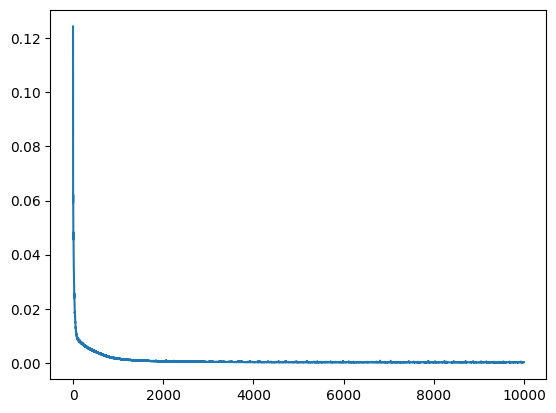

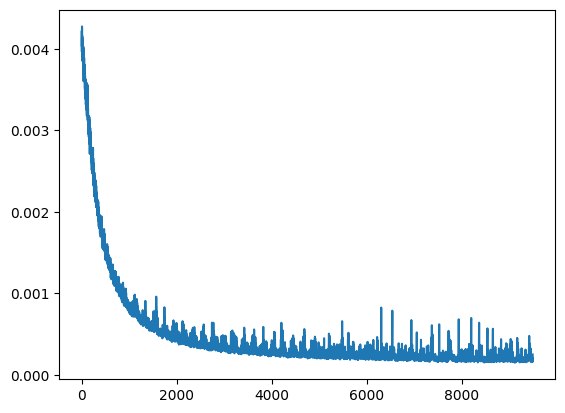

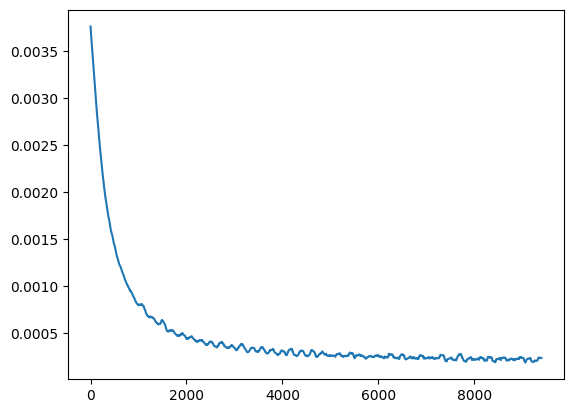

In [44]:
import matplotlib.pyplot as plt

# Plot the losses over training
plt.plot(list(range(len(mm_losses))), mm_losses, label='MM')
plt.show()

latter_training = mm_losses[500:]
plt.plot(list(range(len(latter_training))), latter_training, label='MM')
plt.show()

# running average of last 100 losses
latter_training_averaged = np.convolve(latter_training, np.ones((100,))/100, mode='valid')
plt.plot(list(range(len(latter_training_averaged))), latter_training_averaged, label='MM')
plt.show()

In [45]:
s0_batch = [s0 for s0, _, _ in mm_train_data]
s1_batch = [s1 for _, _, s1 in mm_train_data]
a_batch = [a for _, a, _ in mm_train_data]

s0_tensor = state_batch_to_tensor(s0_batch, device)
s1_tensor = state_batch_to_tensor(s1_batch, device)
a_tensor = action_batch_to_tensor(a_batch, device)

s1_pred = mm(s0_tensor, a_tensor)

loss = (s1_pred - s1_tensor)**2
loss_x = loss[:, 0]
loss_y = loss[:, 1]
loss_theta = loss[:, 2] + loss[:, 3]

print("training loss", loss.mean().item())

training loss 0.00023869243159424514


In [46]:
s0_batch = [s0 for s0, _, _ in mm_validation_data]
s1_batch = [s1 for _, _, s1 in mm_validation_data]
a_batch = [a for _, a, _ in mm_validation_data]

s0_tensor = state_batch_to_tensor(s0_batch, device)
s1_tensor = state_batch_to_tensor(s1_batch, device)
a_tensor = action_batch_to_tensor(a_batch, device)

s1_pred = mm(s0_tensor, a_tensor)

loss = (s1_pred - s1_tensor)**2
loss_x = loss[:, 0]
loss_y = loss[:, 1]
loss_theta = loss[:, 2] + loss[:, 3]

print("validation loss", loss.mean().item())

validation loss 0.0002462758566252887


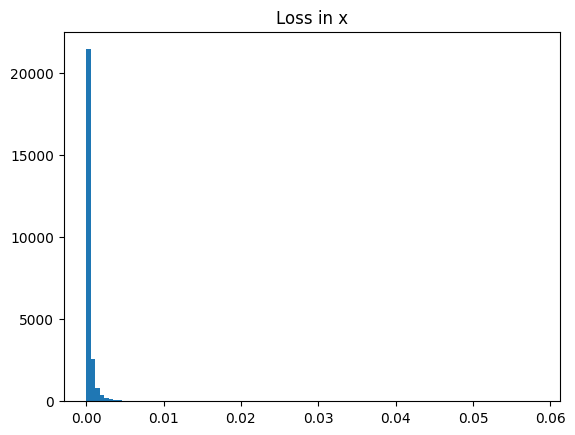

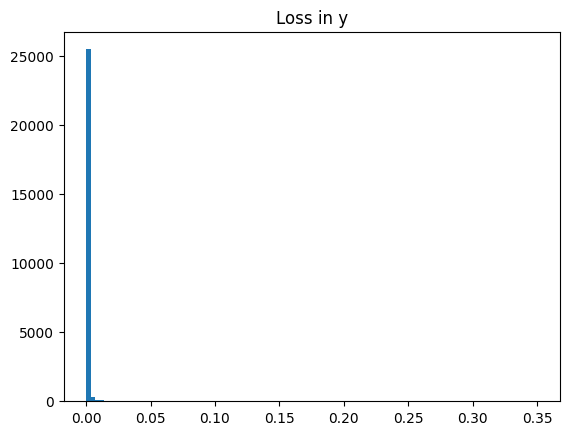

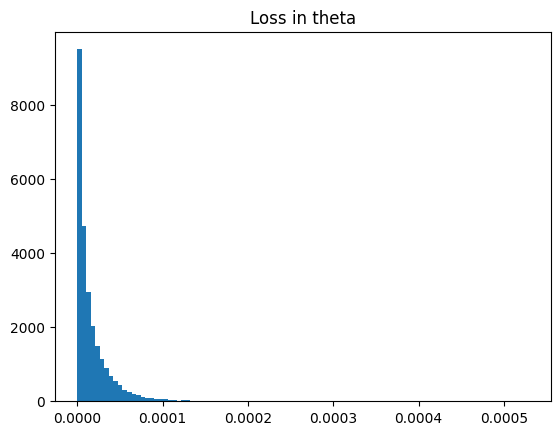

In [47]:
plt.hist(loss_x.cpu().detach().numpy(), bins=100)
plt.title('Loss in x')
plt.show()
plt.hist(loss_y.cpu().detach().numpy(), bins=100)
plt.title('Loss in y')
plt.show()
plt.hist(loss_theta.cpu().detach().numpy(), bins=100)
plt.title('Loss in theta')
plt.show()

In [14]:
# creates a model that attempts to predict the action given the current state and the next state
class InverseDynamicsModel(nn.Module):
    def __init__(self):
        super().__init__()
        # input shape: (batch_size, 4, 2)
        # output shape: (batch_size, 2)

        self.conv1 = nn.Conv1d(4, 768, 2) # Bx4x2 -> Bx768x1
        self.fc1 = nn.Linear(768, 768) # Bx768 -> Bx768
        self.fc2 = nn.Linear(768, 2) # Bx768 -> Bx2
    
    def forward(self, x: torch.Tensor):
        x = F.relu(self.conv1(x)) # Bx4x2 -> Bx768x1
        x = torch.flatten(x, 1) # Bx768x1 -> Bx768
        x = F.relu(self.fc1(x)) # Bx768 -> Bx768
        x = self.fc2(x) # Bx768 -> Bx2
        return x

def idm_train_batch(
        mm: MetadriveModel,
        idm: InverseDynamicsModel,
        idm_optimizer: torch.optim.Optimizer,
        obs_batch: list[Observation],
) -> float:
    device = deviceof(mm)

    assert deviceof(idm) == device

    obs_tensor = obs_batch_to_tensor(obs_batch, device)
    s0_tensor = state_batch_to_tensor([s0 for s0, _ in obs_batch], device)
    s1_tensor = state_batch_to_tensor([s1 for _, s1 in obs_batch], device)

    idm_optimizer.zero_grad()

    pred_action = idm(obs_tensor)
    pred_s1 = mm(s0_tensor, pred_action)

    loss = F.mse_loss(pred_s1, s1_tensor)
    loss.backward()

    idm_optimizer.step()

    return float(loss.item())

In [49]:
import itertools

idm_train_iter = itertools.cycle(idm_train_data)

idm = InverseDynamicsModel().to(device)

idm_optimizer = torch.optim.AdamW(idm.parameters())

idm_step = 0
idm_losses = []

In [15]:
set_lr(idm_optimizer, 1e-4)
INVERSE_DYNAMICS_MODEL_TRAIN_EPOCHS = 5500
INVERSE_DYNAMICS_MODEL_TRAIN_BATCH_SIZE = 4096

while idm_step < INVERSE_DYNAMICS_MODEL_TRAIN_EPOCHS:
    obs_batch = [next(idm_train_iter) for _ in range(INVERSE_DYNAMICS_MODEL_TRAIN_BATCH_SIZE)]
    loss = idm_train_batch(
        mm,
        idm,
        idm_optimizer,
        obs_batch,
    )
    idm_losses.append(loss)
    idm_step += 1
    if idm_step % 100 == 0:
        # print average loss over last 100 steps
        loss = np.mean(idm_losses[-100:])
        print(f"Step: {idm_step}, Loss: {loss:.4f}")

NameError: name 'idm_optimizer' is not defined

In [16]:
# load idm
if 'idm' not in locals():
    idm = InverseDynamicsModel().to(device)
    idm.load_state_dict(torch.load('nuplan_data/idm.pth'))    

In [83]:
# save idm
if not os.path.exists('nuplan_data/idm.pth'):
    torch.save(idm.state_dict(), 'nuplan_data/idm.pth')

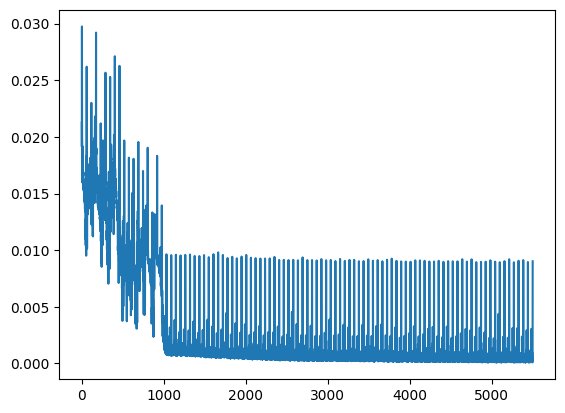

In [72]:
import matplotlib.pyplot as plt

# Plot the losses over training
plt.plot(list(range(len(idm_losses))), idm_losses, label='IDM')
plt.show()

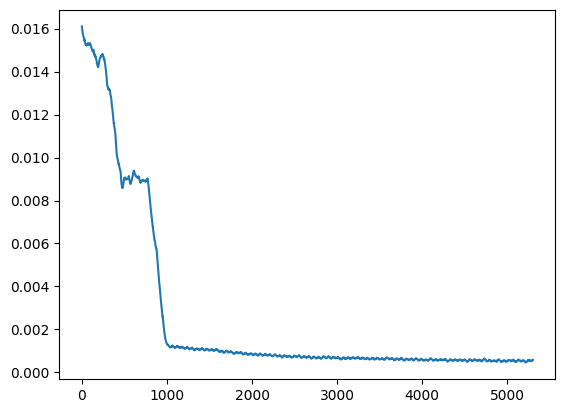

In [73]:
# compute running average of the last 200 episodes
# plot the average reward per episode
idm_losses_averaged = np.convolve(idm_losses, np.ones((200,))/200, mode='valid')
plt.plot(idm_losses_averaged)

In [74]:
obs_batch = idm_train_data

obs_tensor = obs_batch_to_tensor(obs_batch, device)
s0_tensor = state_batch_to_tensor([s0 for s0, _ in obs_batch], device)
s1_tensor = state_batch_to_tensor([s1 for _, s1 in obs_batch], device)
with torch.no_grad():
    action_pred = idm(obs_tensor)
    s1_pred = mm(s0_tensor, action_pred)

loss = (s1_pred - s1_tensor)**2
loss_x = loss[:, 0].cpu().detach().numpy()
loss_y = loss[:, 1].cpu().detach().numpy()
loss_theta = loss[:, 2].cpu().detach().numpy()

print("training loss", loss.mean().item())

training loss 0.0004890712443739176


In [17]:
obs_batch = idm_validation_data

obs_tensor = obs_batch_to_tensor(obs_batch, device)
s0_tensor = state_batch_to_tensor([s0 for s0, _ in obs_batch], device)
s1_tensor = state_batch_to_tensor([s1 for _, s1 in obs_batch], device)
with torch.no_grad():
    action_pred = idm(obs_tensor)
    s1_pred = mm(s0_tensor, action_pred)

loss = (s1_pred - s1_tensor)**2
loss_x = loss[:, 0].cpu().detach().numpy()
loss_y = loss[:, 1].cpu().detach().numpy()
loss_theta = loss[:, 2].cpu().detach().numpy()

print("validation loss", loss.mean().item())

validation loss 0.0003221740189474076


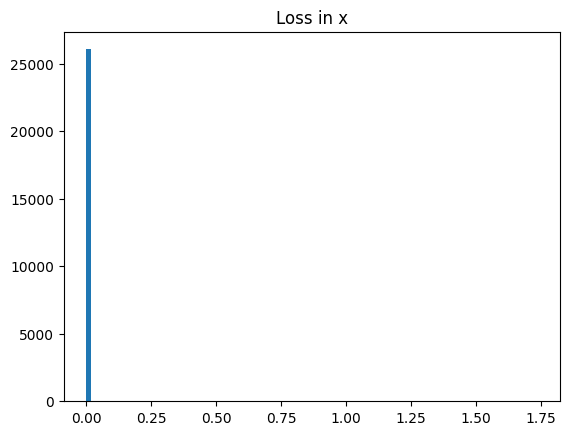

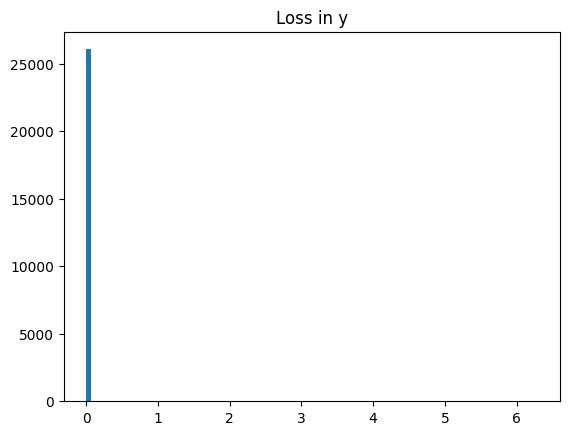

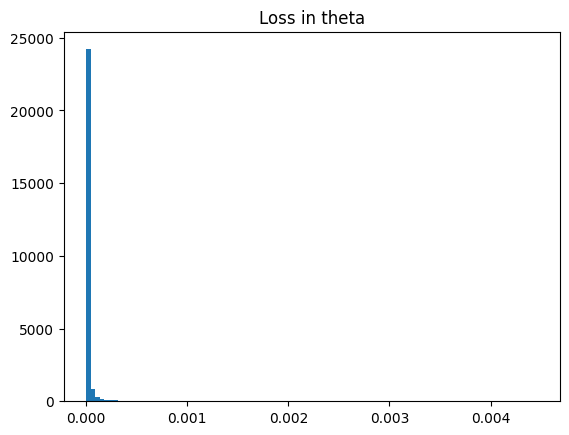

In [76]:
plt.hist(loss_x, bins=100)
plt.title('Loss in x')
plt.show()
plt.hist(loss_y, bins=100)
plt.title('Loss in y')
plt.show()
plt.hist(loss_theta, bins=100)
plt.title('Loss in theta')
plt.show()


### Enumerate outliers

In [77]:
for i, t in enumerate(trajectories):
    obs_batch = []
    for j in range(len(t)-1):
        obs_batch.append((t[j], t[j+1]))
    
    obs_tensor = obs_batch_to_tensor(obs_batch, device)
    s0_tensor = state_batch_to_tensor([s0 for s0, _ in obs_batch], device)
    s1_tensor = state_batch_to_tensor([s1 for _, s1 in obs_batch], device)
    with torch.no_grad():
        action_pred = idm(obs_tensor)
        s1_pred = mm(s0_tensor, action_pred)

    loss = (s1_pred - s1_tensor)**2

    for j, (lx, ly, lthetax, lthetay) in enumerate(loss):
        if lx > 1 or ly > 1 or lthetax > 1 or lthetay > 1:
            print(f"Trajectory {i}, step {j}")
            print(f"lx: {lx}, ly: {ly}, ltheta: {lthetax + lthetay}")

Trajectory 12, step 2282
lx: 0.0019022823544219136, ly: 1.8753896951675415, ltheta: 2.6958923626807518e-05
Trajectory 30, step 459
lx: 1.4712297916412354, ly: 0.046328745782375336, ltheta: 0.0005460951942950487
Trajectory 30, step 461
lx: 13.03969669342041, ly: 0.0030950340442359447, ltheta: 0.0008969175396487117
Trajectory 30, step 666
lx: 0.013760185800492764, ly: 8.545531272888184, ltheta: 2.9416120014502667e-05
Trajectory 30, step 667
lx: 0.017215704545378685, ly: 34.30881118774414, ltheta: 3.5505510709299415e-07
Trajectory 30, step 668
lx: 0.004859465640038252, ly: 144.3658905029297, ltheta: 1.594501009094529e-05
Trajectory 33, step 2791
lx: 0.01495430339127779, ly: 2.3596198558807373, ltheta: 0.00048501681885682046
Trajectory 33, step 2793
lx: 0.015404604375362396, ly: 9.173587799072266, ltheta: 0.0009108784724958241
Trajectory 39, step 1280
lx: 1.7353674173355103, ly: 0.7342354655265808, ltheta: 0.0002728109830059111
Trajectory 44, step 1951
lx: 0.001514409203082323, ly: 12.6204

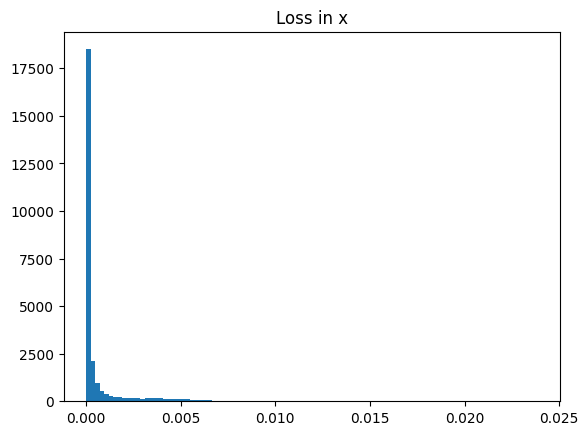

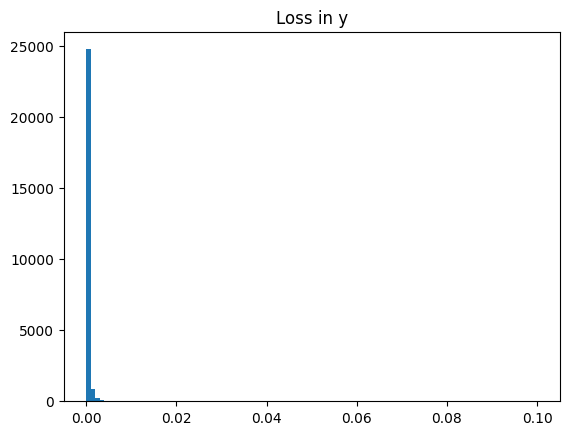

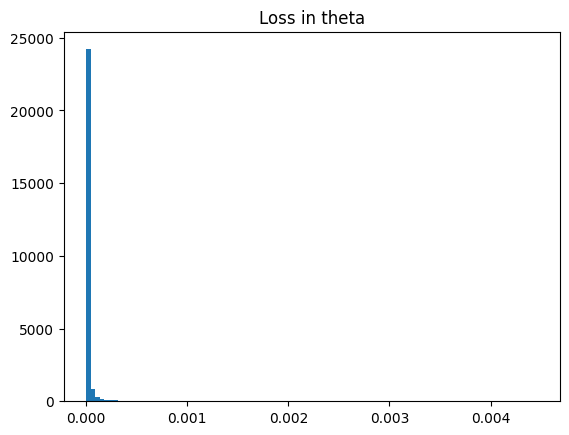

In [78]:
loss_x_no_outliers = np.array([x for x in loss_x if x < 0.1 ]) 
loss_y_no_outliers = np.array([x for x in loss_y if x < 0.1 ])
loss_theta_no_outliers = np.array([x for x in loss_theta if x < 0.1 ])

plt.hist(loss_x_no_outliers, bins=100)
plt.title('Loss in x')
plt.show()
plt.hist(loss_y_no_outliers, bins=100)
plt.title('Loss in y')
plt.show()
plt.hist(loss_theta_no_outliers, bins=100)
plt.title('Loss in theta')
plt.show()

In [24]:
class IDMPolicy:
    def __init__(self, net: InverseDynamicsModel):
        self.net = net

    def __call__(self, obs:Observation) -> Action:
        # sample an action from the policy network
        obs_tensor = obs_batch_to_tensor([obs], deviceof(self.net))
        # sample an action from the policy network
        with torch.no_grad():
            steering, throttle = self.net(obs_tensor)[0]
        return steering.item(), throttle.item()


In [80]:
env = gym.make("MetaDrive-validation-v0", config={"on_continuous_line_done": False, "use_render": True})

### Trajectory Replay

In [81]:
scenario = trajectories[7]

# reset
env.reset()

# allow car to settle
for _ in range(10):
    env.step([0,0])

# set the initial state
for i in range(len(scenario)):
    st = scenario[i]
    env.vehicle.set_velocity(st.velocity)
    env.vehicle.set_heading_theta(st.heading)
    env.step([0, 0])        

/home/fidgetsinner/venvs/metadrive/lib/python3.11/site-packages/gymnasium/utils/passive_env_checker.py:210: DeprecationWarning: WARN: Current gymnasium version requires that `Env.reset` can be passed `options` to allow the environment initialisation to be passed additional information.
  logger.deprecation(
Known pipe types:
  glxGraphicsPipe
(1 aux display modules not yet loaded.)
:task(warning): Creating implicit AsyncTaskChain default for AsyncTaskManager TaskManager
INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.
INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.
INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.
INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.
INFO:/home/fidgetsinner/myworkspace/metadrive/metadri

### Closed Loop IDM

In [85]:
with torch.no_grad():
    # reset
    env.reset()

    # allow car to settle
    for _ in range(10):
        env.step([0,0])

    st = scenario[0]

    # set the initial state
    env.vehicle.set_velocity(st.velocity)
    env.vehicle.set_heading_theta(st.heading)


    for i in range(len(scenario)-1):
        st0 = scenario[i]
        st1 = scenario[i+1]
        st0_pred = get_metadrive_state(env)
        action = IDMPolicy(idm)((st0_pred, st1))
        env.step(action)
        st1_pred = get_metadrive_state(env)
        print(action)
        print(st1_pred.velocity, st1_pred.heading, st1.velocity, st1.heading)

INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(-0.006220643874257803, -0.059468239545822144)
[ 0.08797033 -3.21718359] -1.5410853027256461 [ 0.08251036 -3.22237802] -1.5424009323170969


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(-0.007219121791422367, -0.05555345118045807)
[ 0.08254392 -3.12692857] -1.541645631818998 [ 0.07777564 -3.1293247 ] -1.542242849261625


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(-0.00816873274743557, -0.05065179616212845)
[ 0.0773119  -3.04464102] -1.5422762683651285 [ 0.0732346  -3.04338485] -1.5420767166106928


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(-0.008958294987678528, -0.04629385471343994)
[ 0.07239479 -2.96943331] -1.5429692228807674 [ 0.06888723 -2.96455845] -1.5422750220130699


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(-0.009928023442626, -0.041595131158828735)
[ 0.06750321 -2.90186667] -1.5437175711470799 [ 0.06473353 -2.8928455 ] -1.5423922488241844


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(-0.010602080263197422, -0.03926185891032219)
[ 0.06293072 -2.83808541] -1.5445199815835213 [ 0.0607735 -2.8271446] -1.542561923739706


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(-0.011287325993180275, -0.04667458310723305)
[ 0.05817626 -2.7622447 ] -1.5453623394363127 [ 0.05700714 -2.75734107] -1.5426689825693398


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(-0.011812248267233372, -0.04777336120605469)
[ 0.05362667 -2.68460941] -1.5462339920610955 [ 0.05343445 -2.68098817] -1.542734907638767


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(-0.012410424649715424, -0.0537218376994133)
[ 0.04896562 -2.59729505] -1.5471248194457274 [ 0.05005543 -2.59808588] -1.542673922138838


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(-0.01289877388626337, -0.05580707639455795)
[ 0.04447406 -2.50658369] -1.5480286963197 [ 0.04687009 -2.50863422] -1.5426522241367902


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(-0.013358931988477707, -0.06102704256772995)
[ 0.04007622 -2.40737557] -1.5489371005675263 [ 0.04387841 -2.41263318] -1.5426723990050377


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(-0.013672932051122189, -0.06377317011356354)
[ 0.03595821 -2.30369329] -1.5498396458609545 [ 0.0410804  -2.31008276] -1.542682503783292


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(-0.014468902722001076, -0.06840284168720245)
[ 0.03163839 -2.1924777 ] -1.5507339353550025 [ 0.03846297 -2.20102187] -1.5424585340753263


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(-0.0162392258644104, -0.0698554515838623)
[ 0.02677723 -2.07889676] -1.5516434048672654 [ 0.03594759 -2.08568399] -1.5422917237369085


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(-0.016995951533317566, -0.07663802057504654)
[ 0.02256946 -1.95427489] -1.5525813702031908 [ 0.03352117 -1.96410802] -1.5422739678870088


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(-0.018088987097144127, -0.08071321994066238)
[ 0.01857486 -1.82301855] -1.5535188029068987 [ 0.03118371 -1.83629395] -1.5423334522129493


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(-0.01822594925761223, -0.08399158716201782)
[ 0.01542909 -1.68642306] -1.5544378597990853 [ 0.02893522 -1.70224179] -1.5426476189368121


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(-0.019330844283103943, -0.08862495422363281)
[ 0.01217823 -1.54228783] -1.5553161703265932 [ 0.02677568 -1.56195154] -1.5429190626215143


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(-0.0210527703166008, -0.092831090092659)
[ 0.00890105 -1.39130497] -1.5561675829270918 [ 0.0247051 -1.4154232] -1.5431021566487633


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(-0.02259400673210621, -0.09458868205547333)
[ 0.00607731 -1.23745847] -1.5569960923422155 [ 0.02272348 -1.26399616] -1.5429014021940723


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(-0.02409331500530243, -0.08579318225383759)
[ 0.00384518 -1.09791529] -1.557789980663168 [ 0.02083082 -1.11582033] -1.5425759108988812


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(-0.023828214034438133, -0.08944302797317505)
[ 0.00258646 -0.95243746] -1.5585290078656646 [ 0.01902712 -0.97227313] -1.5424285411030816


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(-0.02283925563097, -0.08156079053878784)
[ 0.00199856 -0.8197813 ] -1.5591742917977909 [ 0.01731238 -0.83335456] -1.5424568700868149


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(-0.021833011880517006, -0.0772920697927475)
[ 0.001617   -0.69406784] -1.5597146471829682 [ 0.0156866  -0.69906462] -1.5424291507148264


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(-0.020514018833637238, -0.0759834349155426)
[ 0.00137331 -0.57048148] -1.560153802446722 [ 0.01414979 -0.56940331] -1.542443875105673


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(-0.01754074916243553, -0.0692409947514534)
[ 0.00144628 -0.45786113] -1.5604917575890536 [ 0.01270193 -0.44437063] -1.5424516000842756


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(-0.01447200309485197, -0.06714946776628494)
[ 0.0014546 -0.3486402] -1.5607311757710516 [ 0.01134303 -0.32617038] -1.5424932166421113


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(-0.010431211441755295, -0.06459994614124298)
[ 0.00136929 -0.24356362] -1.5608843075337306 [ 0.01007309 -0.22410138] -1.5425917255259392


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(-0.006105777341872454, -0.05378437042236328)
[ 0.00115711 -0.15607813] -1.5609684634241772 [ 0.00889211 -0.13920345] -1.5425154858156158


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(-0.0021565710194408894, -0.048429638147354126)
[ 0.00071996 -0.07730305] -1.5610052150472207 [ 0.0078001  -0.07147661] -1.5424921581081776


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(0.000822688452899456, -0.04277230426669121)
[ 0.00010638 -0.00773174] -1.5610174655882343 [ 0.00679704 -0.02092085] -1.542536442559853


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(0.004152365028858185, -0.017837420105934143)
[-4.22982121e-05  5.29707503e-03] -1.561020128749325 [0.00588294 0.01246383] -1.5425220307568777


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(0.004731304943561554, -0.021328479051589966)
[-9.02936663e-05  8.38712323e-03] -1.561020128749325 [0.0050578  0.02867743] -1.5427342712269791


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(0.004795576445758343, -0.02176748961210251)
[ 2.87635012e-05 -2.32511316e-03] -1.561020128749325 [0.00432163 0.0318096 ] -1.542793417163141


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(0.003932680934667587, -0.03216853737831116)
[-3.80786660e-05  3.40898312e-03] -1.561020128749325 [0.00367441 0.03365963] -1.5428145372066662


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(0.004208157770335674, -0.02890413999557495)
[ 6.78474171e-05 -5.99357300e-03] -1.5610198624332154 [0.00311615 0.03496946] -1.5428567109283313


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(0.003487352281808853, -0.03726690635085106)
[-7.05752900e-05  6.12938358e-03] -1.5610198624332154 [0.00264685 0.0357391 ] -1.5429288284333629


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(0.004241775721311569, -0.027882985770702362)
[ 3.19435458e-05 -2.94098933e-03] -1.5610198624332154 [0.00226652 0.03596853] -1.542897368797462


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(0.0035804305225610733, -0.03500422462821007)
[-8.01417627e-05  7.35998154e-03] -1.561020128749325 [0.00197514 0.03565776] -1.5428412319399232


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(0.00425503496080637, -0.02609632909297943)
[ 5.65805894e-05 -4.84590651e-03] -1.561020128749325 [0.00177273 0.0348068 ] -1.5428856299307452


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(0.003407178446650505, -0.03493161499500275)
[-7.03539627e-05  6.51740655e-03] -1.561020128749325 [0.00163207 0.03359396] -1.542880788626511


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(0.004175011999905109, -0.02483481913805008)
[ 5.31586011e-05 -4.74665593e-03] -1.5610198624332154 [0.00149637 0.03239171] -1.542855329983162


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(0.0033862031996250153, -0.03295378386974335)
[-6.55973417e-05  5.97327948e-03] -1.561020128749325 [0.00136384 0.03121174] -1.542881604443307


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(0.004116159863770008, -0.02339562401175499)
[ 4.48335995e-05 -3.93714523e-03] -1.5610198624332154 [0.00123449 0.03005403] -1.5428469855401505


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(0.0034206127747893333, -0.030462216585874557)
[-6.62930397e-05  5.97226061e-03] -1.561020128749325 [0.00110831 0.02891859] -1.5428671334562536


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(0.004092653281986713, -0.021598223596811295)
[ 4.90353850e-05 -4.27646143e-03] -1.5610198624332154 [0.0009853  0.02780541] -1.5428900146153663


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(0.0033795852214097977, -0.02896469086408615)
[-5.54556682e-05  5.14581194e-03] -1.5610198624332154 [0.00086547 0.0267145 ] -1.542842220244028


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(0.004035408608615398, -0.020507194101810455)
[ 3.61285784e-05 -3.37163801e-03] -1.5610198624332154 [0.00074881 0.02564586] -1.5428840726480137


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(0.0034229187294840813, -0.026538874953985214)
[-5.77060819e-05  5.26153250e-03] -1.5610198624332154 [0.00063532 0.02459948] -1.5428437192737499


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(0.004089985974133015, -0.018675748258829117)
[ 4.47601924e-05 -3.88656417e-03] -1.5610198624332154 [0.00052501 0.02357538] -1.542904363528731


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(0.0033682454377412796, -0.025340557098388672)
[-4.69267106e-05  4.35676752e-03] -1.5610198624332154 [0.00041787 0.02257354] -1.542862415719879


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(0.0040413253009319305, -0.0177733413875103)
[ 3.16025544e-05 -2.77351704e-03] -1.5610198624332154 [0.0003139  0.02159396] -1.5428932231603825


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(0.0034290682524442673, -0.02288537472486496)
[-5.32925551e-05  4.67111589e-03] -1.5610198624332154 [0.00021311 0.02063665] -1.5428476915391842


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(0.004116524010896683, -0.01591380685567856)
[ 3.09876486e-05 -2.77143181e-03] -1.5610198624332154 [0.00011549 0.01970161] -1.5428551882373465


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(0.003416460007429123, -0.021396856755018234)
[-4.31231019e-05  4.18904470e-03] -1.5610198624332154 [2.10416340e-05 1.87888413e-02] -1.5428015431328583


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(0.004109054803848267, -0.014781068079173565)
[ 3.31956071e-05 -2.98317522e-03] -1.5610198624332154 [-7.02313571e-05  1.78983352e-02] -1.5427937278681063


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(0.0033986475318670273, -0.02014564722776413)
[-3.80919701e-05  3.57026095e-03] -1.561020128749325 [-0.00015833  0.0170301 ] -1.5428558560991026


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(0.0040781088173389435, -0.013855132274329662)
[ 2.72890211e-05 -2.44914601e-03] -1.5610198624332154 [-0.00024326  0.01618412]

 -1.5428979815915513


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(0.003485957160592079, -0.01829223334789276)
[-3.92024085e-05  3.50134796e-03] -1.561020128749325 [-0.00032501  0.01536042] -1.5428990055698062


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(0.00410738680511713, -0.012495792470872402)
[ 2.79729084e-05 -2.60075717e-03] -1.5610198624332154 [-0.00040359  0.01455898] -1.5428941837455212


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(0.003506682813167572, -0.017069026827812195)
[-3.26136033e-05  2.95184320e-03] -1.5610198624332154 [-0.000479    0.01377981] -1.5428883566615301


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(0.004086287692189217, -0.011566705070436)
[ 2.45814481e-05 -2.01329286e-03] -1.5610198624332154 [-0.00055123  0.01302291] -1.5428869183013358


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(0.0036029331386089325, -0.015282425098121166)
[-3.40121333e-05  2.95807188e-03] -1.5610198624332154 [-0.00062029  0.01228827] -1.5428293766803112


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(0.004120718687772751, -0.010211191140115261)
[ 1.95520843e-05 -1.84059888e-03] -1.5610198624332154 [-0.00068617  0.0115759 ] -1.5428737606882617


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(0.003652638755738735, -0.013936798088252544)
[-3.01647215e-05  2.69307639e-03] -1.561020128749325 [-0.00074889  0.01088579] -1.542879260357021


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(0.004127016291022301, -0.009175918065011501)
[ 1.67595317e-05 -1.49339100e-03] -1.561020128749325 [-0.00080842  0.01021796] -1.5428435149615893


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(0.0037225577980279922, -0.012418392114341259)
[-2.96405833e-05  2.54631881e-03] -1.561020128749325 [-0.00086479  0.00957239] -1.5428534796091955


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(0.004141007550060749, -0.008091739378869534)
[ 1.16219762e-05 -1.02157705e-03] -1.561020128749325 [-0.00091798  0.00894909] -1.5428756731318274


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(0.0037998128682374954, -0.010831714607775211)
[-2.25766889e-05  2.20728596e-03] -1.561020128749325 [-0.000968    0.00834805] -1.5428898828079445


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(0.004141645506024361, -0.006997323594987392)
[ 1.27363091e-05 -9.72192967e-04] -1.561020128749325 [-0.00101485  0.00776928] -1.5428525692305404


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(0.003835761919617653, -0.009695726446807384)
[-2.42661954e-05  2.05146777e-03] -1.561020128749325 [-0.00105852  0.00721278] -1.5428944054690223


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(0.004164006561040878, -0.005753262899816036)
[-1.32825144e-05  1.10547594e-03] -1.561020128749325 [-0.00109902  0.00667855] -1.5428523199071438


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(0.004081140272319317, -0.006195354275405407)
[ 1.09282237e-05 -9.09863738e-04] -1.561020128749325 [-0.00113634  0.00616658] -1.5429010598568962


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(0.0038934629410505295, -0.007908436469733715)
[-1.97252211e-05  1.66274223e-03] -1.561020128749325 [-0.00117049  0.00567688] -1.5428540477980577


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(0.004186389036476612, -0.004260647110641003)
[-1.08753147e-05  9.10213392e-04] -1.5610203950654338 [-0.00120147  0.00520944] -1.5428230776123895


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(0.004124701023101807, -0.004562729969620705)
[ 7.27699307e-06 -5.74032601e-04] -1.5610203950654338 [-0.00122928  0.00476428] -1.5428221399184159


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(0.003982778638601303, -0.00576344970613718)
[-1.23707377e-05  1.24154915e-03] -1.5610203950654338 [-0.00125391  0.00434138] -1.5428375856826042


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(0.0041974987834692, -0.0030728569254279137)
[-8.85624195e-06  6.57747849e-04] -1.5610203950654338 [-0.00127537  0.00394075] -1.5428305917707874


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(0.004152312874794006, -0.0032645845785737038)
[ 3.96516180e-06 -4.04216233e-04] -1.5610203950654338 [-0.00129365  0.00356238] -1.5428247662647314


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(0.004055215045809746, -0.004053827375173569)
[-9.81327958e-06  8.41834175e-04] -1.5610203950654338 [-0.00130876  0.00320628] -1.5428007083686548


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(0.004204019904136658, -0.0021279649809002876)
[-3.17025501e-06  4.77074820e-04] -1.5610203950654338 [-0.0013207   0.00287245] -1.5428560958490467


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(0.00417603924870491, -0.0021466417238116264)
[ 3.27587395e-06 -2.21246766e-04] -1.5610203950654338 [-0.00132946  0.00256088] -1.5429251540454303


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(0.004120265133678913, -0.0025927331298589706)
[-6.38612528e-06  4.94987704e-04] -1.5610203950654338 [-0.00133505  0.00227159] -1.5428197368498593


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(0.0042116520926356316, -0.001384509727358818)
[-2.90451885e-06  1.80773161e-04] -1.5610203950654338 [-0.00133747  0.00200456] -1.5428375102949017


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(0.004188373684883118, -0.0014293091371655464)
[ 3.94177505e-06 -2.84164737e-04] -1.5610203950654338 [-0.00133672  0.00175979] -1.5428855837103075


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(0.004154020920395851, -0.001684095710515976)
[-2.45223259e-06  2.63671245e-04] -1.5610203950654338 [-0.00133279  0.0015373 ] -1.5428154305177217


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(0.004224725067615509, -0.0007629934698343277)
[-6.45280238e-07  1.24280545e-04] -1.5610203950654338 [-0.00132568  0.00133707] -1.5428307551223053


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(0.0042214589193463326, -0.0006897170096635818)
[ 7.06842570e-07 -1.00098696e-04] -1.5610203950654338 [-0.00131541  0.0011591 ] -1.5428181968705996


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(0.004206851124763489, -0.0007474934682250023)
[-3.12042039e-06  1.43049416e-04] -1.5610203950654338 [-0.00130196  0.00100341] -1.5428367311179676


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(0.004242468625307083, -0.00027500465512275696)
[-2.92031302e-07  5.36107982e-05] -1.5610203950654338 [-0.00128534  0.00086998] -1.5428512144846804


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(0.00424143485724926, -0.00023176893591880798)
[ 7.21365836e-07 -3.76166499e-05] -1.5610203950654338 [-0.00126554  0.00075882] -1.5428550146010203


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(0.004238182678818703, -0.0002210903912782669)
[2.28410090e-06 3.43314241e-05] -1.5610203950654338 [-0.00124257  0.00066992] -1.5428882759728422


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(0.004254552535712719, -4.636123776435852e-05)
[ 1.59318211e-06 -9.67632150e-06] -1.5610203950654338 [-0.00121643  0.00060329] -1.5428636102141202


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(0.004259951412677765, -4.27979975938797e-05)
[-3.54932695e-07  4.22541962e-06] -1.5610203950654338 [-0.00118711  0.00055893] -1.5428008480895319


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(0.0042656343430280685, 1.4901161193847656e-06)
[-2.18863033e-06  3.79291805e-06] -1.5610203950654338 [-0.00115462  0.00053684] -1.5428428355113049


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(0.0042688315734267235, 3.7159770727157593e-07)
[-6.08121695e-07  3.70824728e-06] -1.5610203950654338 [-0.00111925  0.0005352 ] -1.5428902027858196


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(0.004273992031812668, -6.1336904764175415e-06)
[3.74423109e-07 1.72393391e-06] -1.5610203950654338 [-0.00108366  0.00053749] -1.5428878077710753


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(0.004279604181647301, -1.5178695321083069e-05)
[ 6.03638853e-07 -3.12875545e-06] -1.5610203950654338 [-0.00104849  0.0005397 ] -1.5428725221481434


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(0.004286373034119606, -2.8166919946670532e-05)
[7.80545463e-07 8.18598983e-06] -1.5610203950654338 [-0.00101375  0.00054185] -1.542829107861668


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(0.004292876459658146, -2.0829960703849792e-05)
[-2.30489013e-06 -4.64662378e-07] -1.5610203950654338 [-0.00097944  0.00054392] -1.542824165308147


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(0.004296048544347286, -3.733113408088684e-05)
[ 9.39294125e-07 -3.63423055e-06] -1.5610203950654338 [-0.00094554  0.00054592] -1.5428489436006565


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(0.004301020875573158, -4.6176835894584656e-05)
[ 1.26347447e-06 -1.29655891e-05] -1.5610203950654338 [-0.00091208  0.00054785] -1.542834275228306


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(0.004302896559238434, -6.189476698637009e-05)
[9.43765485e-07 7.16772502e-06] -1.5610203950654338 [-0.00087904  0.0005497 ] -1.542872832442926


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(0.004310985095798969, -4.323851317167282e-05)
[-3.45864066e-07 -1.98551425e-06] -1.5610203950654338 [-0.00084642  0.00055149] -1.5428520739405245


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(0.004314690828323364, -5.930755287408829e-05)
[3.57779186e-07 1.73179105e-05] -1.5610203950654338 [-0.00081422  0.0005532 ] -1.5428571389302745


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(0.004322038032114506, -4.102103412151337e-05)
[-1.98246266e-06  4.93223706e-06] -1.5610203950654338 [-0.00078246  0.00055484] -1.5428438363030565


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(0.004326864145696163, -6.144028156995773e-05)
[ 1.43979366e-06 -9.94642232e-06] -1.5610203950654338 [-0.00075111  0.00055641] -1.5428199250611667


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(0.004327236674726009, -8.248724043369293e-05)
[4.19317445e-07 1.22213423e-05] -1.5610203950654338 [-0.00072019  0.00055791] -1.5428635179182815


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(0.004335460253059864, -6.0867518186569214e-05)
[ 1.39550025e-06 -7.57036105e-06] -1.5610203950654338 [-0.0006897   0.00055934] -1.5428402443579095


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(0.004337014630436897, -8.853152394294739e-05)
[1.27106830e-06 1.63354271e-05] -1.5610203950654338 [-0.00065963  0.0005607 ] -1.542853562234624


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(0.004345598630607128, -6.456207484006882e-05)
[-2.37221252e-06 -4.71115072e-06] -1.5610203950654338 [-0.00062999  0.00056198] -1.5428217577011962


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(0.004350538365542889, -9.532086551189423e-05)
[4.34142066e-07 2.01113962e-05] -1.5610203950654338 [-0.00060077  0.0005632 ] -1.5427743112790742


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(0.004356761462986469, -6.877724081277847e-05)
[-1.16221997e-06 -2.84484418e-06] -1.5610203950654338 [-0.00057197  0.00056434] -1.5427823850088125


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(0.004353548400104046, -9.862147271633148e-05)
[6.99192242e-07 1.75707755e-05] -1.5610203950654338 [-0.0005436   0.00056541] -1.5428837919757235


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(0.0043602148070931435, -7.75754451751709e-05)
[-1.26152054e-06 -1.69121395e-05] -1.5610203950654338 [-0.00051566  0.00056641] -1.5428733276291842


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(0.004362497478723526, -0.00012344960123300552)
[1.56885471e-06 1.91922609e-05] -1.5610203950654338 [-0.00048814  0.00056733] -1.5428411730799703


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(0.004372637718915939, -8.380692452192307e-05)
[-1.05501658e-06 -8.10372603e-06] -1.5610203950654338 [-0.00046104  0.00056819] -1.5427908912528603


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(0.004371621645987034, -0.0001194467768073082)
[5.26996473e-07 3.01405980e-05] -1.5610203950654338 [-0.00043437  0.00056897] -1.5428378059623278


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(0.004378756508231163, -7.606111466884613e-05)
[1.81651458e-07 5.12172528e-06] -1.5610203950654338 [-0.00040812  0.00056969] -1.5428522017791995


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(0.004379028454422951, -0.00010879617184400558)
[ 9.27664132e-07 -2.46738819e-05] -1.5610203950654338 [-0.0003823   0.00057033] -1.5428709303740051


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(0.004381020553410053, -0.00014768261462450027)
[-4.84877830e-07  2.33575429e-05] -1.5610203950654338 [-0.0003569  0.0005709] -1.5428425140985897


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(0.004392142407596111, -9.337253868579865e-05)
[-9.77075842e-07 -7.24558777e-06] -1.5610203950654338 [-0.00033193  0.0005714 ] -1.5428034954332874


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(0.004392432980239391, -0.00013269484043121338)
[-6.59085686e-07  2.82345791e-05] -1.5610203950654338 [-0.00030738  0.00057182] -1.542806994619096


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(0.004398738965392113, -9.202677756547928e-05)
[8.96268034e-07 3.00681421e-07] -1.5610203950654338 [-0.00028326  0.00057218] -1.542829287102383


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(0.0044006481766700745, -0.00012800190597772598)
[-1.08623328e-06 -2.20507700e-05] -1.5610203950654338 [-0.00025956  0.00057246] -1.5428000092746097


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(0.004401238635182381, -0.0001571429893374443)
[-5.78243146e-07  2.90804310e-05] -1.5610203950654338 [-0.00023629  0.00057267] -1.5428148463065632


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(0.00440995953977108, -9.744707494974136e-05)
[ 1.88426895e-06 -1.71821757e-05] -1.5610203950654338 [-0.00021344  0.00057281] -1.542818646554998


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(0.0044059911742806435, -0.00015387311577796936)
[-1.07837172e-06  3.28454371e-05] -1.5610203950654338 [-0.00019101  0.00057288] -1.5428597730201061


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(0.004414808936417103, -9.571760892868042e-05)
[-1.11590502e-07 -1.47806268e-05] -1.5610203950654338 [-0.00016901  0.00057288] -1.5428650707536504


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(0.004412504844367504, -0.00015433784574270248)
[-5.14090800e-07  3.54275653e-05] -1.5610203950654338 [-0.00014744  0.00057281] -1.5428717133289018


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(0.004420009441673756, -9.507499635219574e-05)
[-5.25957319e-07  1.32199484e-05] -1.5610203950654338 [-0.00012629  0.00057266] -1.5428948652747962


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(0.004425124265253544, -0.00012450292706489563)
[-3.86078511e-08 -2.72807283e-05] -1.5610203950654338 [-0.00010556  0.00057244] -1.542810379361188


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(0.004422614350914955, -0.00017399806529283524)
[1.05857180e-06 2.93410321e-05] -1.5610203950654338 [-8.52601226e-05  5.72155770e-04] -1.5428336229560378


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(0.004433592781424522, -0.00010727811604738235)
[-4.89972365e-07 -1.02402928e-05] -1.5610203950654338 [-6.53839522e-05  5.71795879e-04] -1.5427954428627495


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(0.004428544081747532, -0.00015488360077142715)
[2.78897915e-07 2.86833219e-05] -1.5610203950654338 [-4.59324911e-05  5.71364482e-04] -1.542872373568231


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(0.004436255432665348, -0.00010891538113355637)
[-1.16114427e-06 -1.44608548e-05] -1.5610203950654338 [-2.69057394e-05  5.70861579e-04] -1.5428589526504595


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(0.0044340454041957855, -0.00016158074140548706)
[-1.14726413e-06  3.00181582e-05] -1.5610203950654338 [-8.30369706e-06  5.70287169e-04] -1.5428706611952072


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(0.004443764686584473, -0.00010926090180873871)
[ 8.37856419e-07 -1.87341666e-05] -1.5610203950654338 [9.87363596e-06 5.69641252e-04] -1.542829416612232


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(0.004442889243364334, -0.00016856379806995392)
[-1.68456518e-06  3.60780068e-05] -1.5610203950654338 [2.76262596e-05 5.68923828e-04] -1.5427928514320732


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(0.0044492026790976524, -0.00010252930223941803)
[ 4.76167941e-07 -3.25743855e-07] -1.5610203950654338 [4.49541739e-05 5.68134898e-04] -1.542842860031564


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(0.004446352832019329, -0.0001457221806049347)
[ 1.19935532e-06 -3.45259032e-05] -1.5610203950654338 [6.18573789e-05 5.67274462e-04] -1.5428678948311783


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(0.004446052946150303, -0.00018705707043409348)
[1.57285046e-06 2.63362454e-05] -1.5610203950654338 [7.83358745e-05 5.66342519e-04] -1.5428503235177042


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(0.004456245340406895, -0.00011399202048778534)
[-2.01046487e-06 -1.80790685e-05] -1.5610203950654338 [9.43896608e-05 5.65339069e-04] -1.5428273336189184


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(0.004455451853573322, -0.00016818195581436157)
[-1.38214591e-06  3.66449967e-05] -1.5610203950654338 [0.00011002 0.00056426] -1.542805394520672


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(0.004463085904717445, -0.00010164827108383179)
[-1.14350985e-06  1.03211478e-05] -1.5610203950654338 [0.00012522 0.00056312] -1.5428165825800104


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(0.004464001394808292, -0.00013320893049240112)
[ 1.95910980e-06 -1.61742973e-05] -1.5610203950654338 [0.00014   0.0005619] -1.5427879029949028


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(0.004463350400328636, -0.00016405805945396423)
[-1.42463591e-07  3.60874801e-05] -1.5610203950654338 [0.00015436 0.00056061] -1.542781664687819


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(0.004468131810426712, -9.972881525754929e-05)
[-3.97918086e-07  1.64288322e-05] -1.5610203950654338 [0.00016829 0.00055925] -1.5428458279923993


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(0.004466185346245766, -0.00012190639972686768)
[-5.06771869e-07 -2.32338061e-05] -1.5610203950654338 [0.00018179 0.00055782] -1.5428846014995838


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(0.00446736067533493, -0.0001697484403848648)
[-1.72742716e-06  3.19786741e-05] -1.5610203950654338 [0.00019487 0.00055631] -1.5428190956031471


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(0.004476204514503479, -0.00010251719504594803)
[ 8.85174245e-07 -1.70908552e-05] -1.5610203950654338 [0.00020753 0.00055474] -1.542804790996855


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(0.00446859747171402, -0.00015860609710216522)
[1.44689963e-07 3.45021945e-05] -1.5610203950654338 [0.00021976 0.00055309] -1.5428818080204811


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(0.004475997760891914, -9.519979357719421e-05)
[6.45019270e-07 1.50022561e-05] -1.5610203950654338 [0.00023157 0.00055137] -1.5428844522868592


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(0.004477858543395996, -0.0001178104430437088)
[-1.83447344e-06 -2.33551364e-05] -1.5610203950654338 [0.00024295 0.00054958] -1.5428418464471485


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(0.0044748829677701, -0.00016233045607805252)
[2.34385288e-06 2.95060472e-05] -1.5610203950654338 [0.00025391 0.00054772] -1.5428594943017104


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(0.004482703283429146, -9.651854634284973e-05)
[ 4.26658090e-07 -1.51811282e-05] -1.5610203950654338 [0.00026444 0.00054579] -1.542841583068349


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(0.004479526542127132, -0.00014861579984426498)
[-1.37666029e-06  3.30444964e-05] -1.5610203950654338 [0.00027455 0.00054378] -1.5428461776960969


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(0.004487074911594391, -8.89953225851059e-05)
[5.12826091e-07 1.45281965e-05] -1.5610203950654338 [0.00028423 0.00054171] -1.5428357235137977


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(0.004486880265176296, -0.00010892841964960098)
[ 7.42747375e-09 -2.09167592e-05] -1.5610203950654338 [0.00029349 0.00053956] -1.5428261398814669


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(0.00448642298579216, -0.00014976318925619125)
[-9.35337766e-07  2.77968520e-05] -1.5610203950654338 [0.00030232 0.00053734] -1.5427926247972252


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(0.004490899853408337, -8.830055594444275e-05)
[ 6.62752996e-07 -1.17066866e-05] -1.5610203950654338 [0.00031073 0.00053505] -1.5428346707387381


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(0.004487655125558376, -0.00013288110494613647)
[5.43850831e-07 2.56559051e-05] -1.5610203950654338 [0.00031872 0.00053269] -1.5428387506899413


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(0.004491680301725864, -8.487328886985779e-05)
[-7.29218641e-07 -7.16070826e-06] -1.5610203950654338 [0.00032628 0.00053025] -1.5428626380136754


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(0.004487551748752594, -0.00012115482240915298)
[-1.35986795e-06  2.54306688e-05] -1.5610203950654338 [0.00033341 0.00052775] -1.5429007988388448


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(0.00449218787252903, -7.90376216173172e-05)
[ 1.13889519e-06 -1.53331621e-05] -1.5610203950654338 [0.00034012 0.00052517] -1.5429028476115105


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(0.004490467719733715, -0.00012504775077104568)
[2.66358001e-07 1.48080671e-05] -1.5610203950654338 [0.00034641 0.00052252] -1.5428678973882721


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(0.004494155757129192, -8.556991815567017e-05)
[-1.03800539e-06 -1.30466369e-05] -1.5610203950654338 [0.00035227 0.0005198 ] -1.5428806329621751


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(0.004494462162256241, -0.00011647026985883713)
[2.62953392e-08 2.04245753e-05] -1.5610203950654338 [0.0003577  0.00051701] -1.5428400826025002


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(0.004500152543187141, -7.29365274310112e-05)
[ 3.07347818e-07 -4.44846819e-06] -1.5610203950654338 [0.00036272 0.00051415] -1.5428150833606395


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(0.004498353227972984, -9.917747229337692e-05)
[-1.39294286e-06  1.32329551e-05] -1.5610203950654338 [0.0003673  0.00051122] -1.542814926544869


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(0.0044982898980379105, -7.365457713603973e-05)
[-5.45748094e-07 -1.33498415e-05] -1.5610203950654338 [0.00037146 0.00050821] -1.5428703010454659


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(0.004496158100664616, -0.00010161194950342178)
[2.18584910e-06 1.18192893e-05] -1.5610203950654338 [0.0003752  0.00050513] -1.5428689129218618


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(0.004500651732087135, -6.721913814544678e-05)
[ 6.54096198e-07 -1.00675352e-05] -1.5610203950654338 [0.00037851 0.00050198] -1.542841659397035


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(0.004501978866755962, -9.04574990272522e-05)
[-4.21914706e-07  1.93498017e-05] -1.5610203950654338 [0.0003814  0.00049876] -1.5427880810870702


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(0.004503254778683186, -5.035661160945892e-05)
[-8.55123346e-07 -6.18554805e-06] -1.5610203950654338 [0.00038386 0.00049547] -1.5428356060133919


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(0.004499707370996475, -7.630418986082077e-05)
[-2.63193954e-07  1.04788642e-05] -1.5610203950654338 [0.0003859  0.00049211] -1.5428613389387742


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(0.004503508098423481, -5.2100978791713715e-05)
[-1.12777002e-07 -6.47009438e-06] -1.5610203950654338 [0.00038752 0.00048868] -1.5428298478013838


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(0.004501368850469589, -6.761681288480759e-05)
[-9.62285981e-07  8.18684566e-06] -1.5610203950654338 [0.00038871 0.00048517] -1.5428430002244586


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(0.004503798671066761, -4.547741264104843e-05)
[ 5.95149288e-07 -6.59108582e-06] -1.5610203950654338 [0.00038947 0.00048159] -1.5428342989516892


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(0.004503175616264343, -5.831662565469742e-05)
[1.03966329e-07 6.46882563e-06] -1.5610203950654338 [0.00038981 0.00047794] -1.5428175352654352


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(0.004502660594880581, -3.707129508256912e-05)
[-9.90772833e-07 -7.34295145e-06] -1.5610203950654338 [0.00038972 0.00047422] -1.5428580538106298


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(0.004500610753893852, -4.843715578317642e-05)
[1.72593104e-06 8.44711849e-06] -1.5610203950654338 [0.00038921 0.00047043] -1.5428733577257976


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(0.004502815194427967, -2.3900531232357025e-05)
[-1.32054095e-06 -3.01376622e-06] -1.5610203950654338 [0.00038828 0.00046657] -1.5428586342598787


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(0.004504130221903324, -3.337487578392029e-05)
[-7.59005900e-07 -2.77958816e-06] -1.5610203950654338 [0.00038692 0.00046263] -1.5428177536976673


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(0.004502896219491959, -2.7179718017578125e-05)
[-2.59021363e-07 -3.05104095e-06] -1.5610203950654338 [0.00038514 0.00045862] -1.5428392157038668


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(0.004502387717366219, -2.1578744053840637e-05)
[-4.84296038e-07  3.96678297e-06] -1.5610203950654338 [0.00038293 0.00045455] -1.5428447207476288


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(0.004502231255173683, -7.206574082374573e-06)
[-1.43988632e-06  1.29915929e-06] -1.5610203950654338 [0.00038029 0.0004504 ] -1.5428586022958544


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(0.004501473158597946, -4.51505184173584e-06)
[ 1.84843441e-06 -2.47154571e-06] -1.5610203950654338 [0.00037724 0.00044617] -1.542864806684536


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(0.004499074071645737, -2.0526349544525146e-06)
[-1.99541864e-06 -2.76060882e-06] -1.5610203950654338 [0.00037375 0.00044188] -1.542890140470498


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(0.0044992584735155106, 3.116205334663391e-06)
[-7.76518107e-07 -3.60736226e-06] -1.5610203950654338 [0.00036985 0.00043752] -1.542887632718379


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(0.00450071319937706, 8.026137948036194e-06)
[ 1.42916846e-07 -5.81355653e-06] -1.5610203950654338 [0.00036551 0.00043308] -1.542846955032341


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(0.004499339498579502, 1.217518001794815e-05)
[ 2.50781522e-06 -9.14886732e-06] -1.5610203950654338 [0.00036076 0.00042857] -1.5428573556165015


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(0.0044951532036066055, 1.609325408935547e-05)
[ 6.05565447e-07 -1.36154713e-05] -1.5610203950654338 [0.00035557 0.000424  ] -1.5429158296811554


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(0.0044942134991288185, 1.717638224363327e-05)
[-7.25789050e-07 -1.83746488e-05] -1.5610203950654338 [0.00034997 0.00041935] -1.5429172074700688


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(0.004497367888689041, 1.678522676229477e-05)
[-6.27618874e-07 -2.30094502e-05] -1.5610203950654338 [0.00034394 0.00041462] -1.5428361239890764


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(0.004493323154747486, 1.9132159650325775e-05)
[-4.14189572e-07 -2.82910278e-05] -1.5610203950654338 [0.00033748 0.00040983] -1.5428907415472182


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(0.004493538290262222, 1.9424594938755035e-05)
[ 8.05447826e-07 -3.36417834e-05] -1.5610203950654338 [0.0003306  0.00040497] -1.5428598187920526


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(0.004490245133638382, 2.0981766283512115e-05)
[-2.17410516e-07 -3.94482995e-05] -1.5610203950654338 [0.0003233  0.00040003] -1.5428932355908511


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(0.004489331506192684, 2.1045096218585968e-05)
[-2.89385582e-07 -4.52615823e-05] -1.5610203950654338 [0.00031557 0.00039502] -1.542883664762831


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(0.004487831145524979, 2.1462328732013702e-05)
[-1.73847695e-07 -5.11878643e-05] -1.5610203950654338 [0.00030741 0.00038994] -1.5428816471471352


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(0.004489433020353317, 2.0990148186683655e-05)
[ 2.82919700e-06 -5.69504882e-05] -1.5610203950654338 [0.00029883 0.00038479] -1.542817786999083


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(0.004484596662223339, 2.3245811462402344e-05)
[ 9.77749323e-07 -6.33918753e-05] -1.5610203950654338 [0.00028983 0.00037957] -1.542871842130938


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(0.004485940560698509, 2.2130087018013e-05)
[-3.51734343e-07 -6.95192502e-05] -1.5610203950654338 [0.0002804  0.00037427] -1.5428139780969188


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(0.004480631090700626, 2.3672357201576233e-05)
[ 1.20262632e-06 -7.60393523e-05] -1.5610203950654338 [0.00027055 0.00036891] -1.5428839548943785


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(0.004481200128793716, 2.343393862247467e-05)
[ 1.96552264e-06 -8.25027455e-05] -1.5610203950654338 [0.00026027 0.00036347] -1.5428309167339402


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(0.004476710222661495, 2.481602132320404e-05)
[-3.85291173e-07 -8.93835531e-05] -1.5610203950654338 [0.00024956 0.00035796] -1.5428769029466174


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(0.004475708119571209, 2.4226494133472443e-05)
[ 2.50075885e-07 -9.60673642e-05] -1.5610203950654338 [0.0002385 0.0003524] -1.5428605774136548


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(0.004474724642932415, 2.4306587874889374e-05)
[ 1.99711053e-06 -1.02760358e-04] -1.5610203950654338 [0.00022749 0.00034685] -1.5428373399302555


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(0.004471408203244209, 2.519693225622177e-05)
[ 1.58535863e-06 -1.09724118e-04] -1.5610203950654338 [0.00021659 0.00034134] -1.542857504057224


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(0.004470344632863998, 2.4673528969287872e-05)
[-7.00316832e-07 -1.16564872e-04] -1.561020128749325 [0.00020581 0.00033586] -1.5428382418170599


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(0.0044676875695586205, 2.4498440325260162e-05)
[ 1.38458972e-06 -1.23307153e-04] -1.561020128749325 [0.00019514 0.00033042] -1.5428546963638554


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(0.004461568780243397, 2.6085413992404938e-05)
[ 2.35344396e-06 -1.30500426e-04] -1.561020128749325 [0.00018459 0.00032501] -1.542929667849514


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(0.0044624581933021545, 2.4726614356040955e-05)
[ 1.20689879e-06 -1.37342620e-04] -1.561020128749325 [0.00017416 0.00031964] -1.5428694006195054


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(0.004460914060473442, 2.4273060262203217e-05)
[ 3.13395731e-06 -1.44024350e-04] -1.561020128749325 [0.00016385 0.0003143 ] -1.5428630511654444


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(0.0044586751610040665, 2.451147884130478e-05)
[ 1.54786073e-06 -1.50812164e-04] -1.561020128749325 [0.00015365 0.00030899] -1.5428634474092395


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(0.004457350820302963, 2.3866072297096252e-05)
[ 1.68732788e-06 -1.57402246e-04] -1.561020128749325 [0.00014357 0.00030372] -1.542854501845971


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(0.0044543128460645676, 2.414640039205551e-05)
[ 1.71043439e-06 -1.64070938e-04] -1.561020128749325 [0.0001336  0.00029848] -1.54287537999231


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(0.004454546608030796, 2.3245811462402344e-05)
[ 3.41920395e-06 -1.70471350e-04] -1.561020128749325 [0.00012375 0.00029328] -1.5428330079294068


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(0.004452545195817947, 2.356618642807007e-05)
[ 3.96244741e-06 -1.76973626e-04] -1.561020128749325 [0.00011402 0.00028812] -1.5428310769050324


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(0.004447685554623604, 2.4420209228992462e-05)
[ 9.97647703e-07 -1.83752229e-04] -1.561020128749325 [0.00010441 0.00028298] -1.54288781652611


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(0.004449306055903435, 2.2452324628829956e-05)
[ 2.59899548e-06 -1.89934828e-04] -1.561020128749325 [9.49115649e-05 2.77884814e-04] -1.5428258762322502


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(0.004444168880581856, 2.3826956748962402e-05)
[-1.08754818e-07 -1.96546680e-04] -1.5610198624332154 [8.55308645e-05 2.72820945e-04] -1.5428867457909548


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(0.004445178434252739, 2.210959792137146e-05)
[ 1.06770835e-06 -2.02639596e-04] -1.5610198624332154 [7.62669314e-05 2.67791535e-04] -1.542837201702031


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(0.004440709017217159, 2.329796552658081e-05)
[ 4.62894377e-06 -2.09033286e-04] -1.5610198624332154 [6.71197655e-05 2.62796586e-04] -1.5428868620235863


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(0.004437564872205257, 2.392660826444626e-05)
[ 2.31199715e-06 -2.15667969e-04] -1.5610198624332154 [5.80893669e-05 2.57836097e-04] -1.542905004490192


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(0.004437224008142948, 2.248026430606842e-05)
[ 2.54175461e-06 -2.21874172e-04] -1.5610198624332154 [4.91757356e-05 2.52910068e-04] -1.542881632377039


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(0.0044365134090185165, 2.2036023437976837e-05)
[ 3.06604738e-06 -2.27954079e-04] -1.5610198624332154 [4.03788716e-05 2.48018500e-04] -1.5428611648536528


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(0.00443277508020401, 2.2700056433677673e-05)
[ 1.34158222e-06 -2.34243213e-04] -1.5610198624332154 [3.16987748e-05 2.43161391e-04] -1.5428994573337693


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(0.004431296139955521, 2.2018328309059143e-05)
[ 4.30208956e-06 -2.40290479e-04] -1.5610198624332154 [2.31354453e-05 2.38338743e-04] -1.5428981678079212


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(0.004429513588547707, 2.2292137145996094e-05)
[ 1.39554049e-06 -2.46480544e-04] -1.5610198624332154 [1.46888830e-05 2.33550555e-04] -1.5428935089351847


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(0.0044277748093008995, 2.156198024749756e-05)
[ 2.54004567e-06 -2.52422615e-04] -1.5610195961171067 [6.35908808e-06 2.28796828e-04] -1.5429014375516006


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(0.0044272467494010925, 2.1238811314105988e-05)
[ 2.08590473e-06 -2.58293469e-04] -1.5610195961171067 [-1.85393961e-06  2.24077560e-04] -1.542877239930527


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(0.004426736384630203, 2.0738691091537476e-05)
[ 1.87968601e-06 -2.64023663e-04] -1.5610195961171067 [-9.95020004e-06  2.19392753e-04] -1.5428567595708051


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(0.004425790160894394, 2.048444002866745e-05)
[ 2.76842275e-06 -2.69670854e-04] -1.5610195961171067 [-1.79296932e-05  2.14742406e-04] -1.5428449465237175


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(0.004427183419466019, 1.979433000087738e-05)
[ 4.86330327e-06 -2.75113736e-04] -1.5610195961171067 [-2.57924191e-05  2.10126519e-04] -1.5427853625183703


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(0.004424725659191608, 2.0601786673069e-05)
[ 4.18243053e-06 -2.80811393e-04] -1.5610195961171067 [-3.35383777e-05  2.05545093e-04] -1.5427990244174437


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(0.00442067626863718, 2.1216459572315216e-05)
[ 2.42947203e-06 -2.86691095e-04] -1.5610195961171067 [-4.11675690e-05  2.00998127e-04] -1.5428496195396664


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(0.0044196369126439095, 2.0480714738368988e-05)
[ 3.50507798e-06 -2.92335317e-04] -1.5610193298009971 [-4.86799931e-05  1.96485620e-04] -1.5428439923050707


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(0.004421031102538109, 1.9492581486701965e-05)
[ 3.28793453e-06 -2.97721504e-04] -1.5610193298009971 [-5.60756499e-05  1.92007575e-04] -1.5427854416952047


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(0.004418231546878815, 2.0041130483150482e-05)
[ 4.83909480e-06 -3.03238805e-04] -1.5610193298009971 [-6.33545394e-05  1.87563989e-04] -1.542812090593174


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(0.0044146133586764336, 2.0842067897319794e-05)
[ 4.10120538e-06 -3.09003575e-04] -1.5610193298009971 [-7.05166617e-05  1.83154864e-04] -1.5428512793634663


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(0.004415071569383144, 1.9770115613937378e-05)
[ 2.82732913e-06 -3.14478530e-04] -1.5610193298009971 [-7.75620166e-05  1.78780198e-04] -1.5428156950091625


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(0.004412955604493618, 1.9704923033714294e-05)
[ 3.86385727e-06 -3.19908955e-04] -1.5610193298009971 [-8.44906044e-05  1.74439993e-04] -1.54283287413679


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(0.004410172812640667, 2.0205043256282806e-05)
[ 3.16514411e-06 -3.25497414e-04] -1.5610190634848884 [-9.13024248e-05  1.70134249e-04] -1.5428579256570931


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(0.004409065470099449, 1.958850771188736e-05)
[ 2.20413017e-06 -3.30918410e-04] -1.5610190634848884 [-9.79974780e-05  1.65862964e-04] -1.542854286115919


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(0.004408456385135651, 1.899339258670807e-05)
[ 4.01834086e-06 -3.36143363e-04] -1.5610190634848884 [-0.00010458  0.00016163] -1.5428422177521457


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(0.004407530650496483, 1.9021332263946533e-05)
[ 4.00768840e-06 -3.41396779e-04] -1.5610190634848884 [-0.00011104  0.00015742] -1.5428306128451679


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(0.004407735541462898, 1.8415972590446472e-05)
[ 3.00774673e-06 -3.46494577e-04] -1.5610190634848884 [-0.00011738  0.00015326] -1.5428011092624523


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(0.00440747756510973, 1.795496791601181e-05)
[ 5.10377049e-06 -3.51429277e-04] -1.5610190634848884 [-0.00012361  0.00014912] -1.542783643663652


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(0.004409812390804291, 1.7105601727962494e-05)
[ 5.69705117e-06 -3.56146600e-04] -1.5610187971687797 [-0.00012972  0.00014502] -1.5427088660746322


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(0.004402751103043556, 1.9455328583717346e-05)
[ 5.6077879e-06 -3.6152071e-04] -1.5610187971687797 [-0.00013572  0.00014096] -1.542822497042392


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(0.004398473538458347, 1.9963830709457397e-05)
[ 7.14629948e-07 -3.67090310e-04] -1.5610187971687797 [-0.00014159  0.00013693] -1.5428823765085693


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(0.004398388788104057, 1.821015030145645e-05)
[ 1.84486271e-06 -3.72106675e-04] -1.5610187971687797 [-0.00014735  0.00013293] -1.5428711237746084


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(0.004400581121444702, 1.6954727470874786e-05)
[ 5.91097387e-06 -3.76742886e-04] -1.5610187971687797 [-0.000153    0.00012897] -1.5428023219122284


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(0.004396028816699982, 1.8889084458351135e-05)
[ 5.62044534e-06 -3.81963036e-04] -1.5610187971687797 [-0.00015853  0.00012505] -1.5428599879610823


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(0.0043973298743367195, 1.7433427274227142e-05)
[ 6.21156869e-06 -3.86771106e-04] -1.5610187971687797 [-0.00016394  0.00012115] -1.5428122396145092


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(0.004395436495542526, 1.7647631466388702e-05)
[ 4.04737057e-06 -3.91669921e-04] -1.5610187971687797 [-0.00016923  0.0001173 ] -1.5428266814823615


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(0.004394622519612312, 1.7032958567142487e-05)
[ 4.24294740e-06 -3.96372168e-04] -1.5610187971687797 [-0.00017441  0.00011347] -1.5428260131521505


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(0.0043907249346375465, 1.79242342710495e-05)
[ 2.90348930e-06 -4.01338097e-04] -1.5610187971687797 [-0.00017947  0.00010968] -1.542881184349837


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(0.004389134235680103, 1.749396324157715e-05)
[ 3.90044715e-06 -4.06158477e-04] -1.561018530852671 [-0.00018441  0.00010593] -1.542894575916263


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(0.004388662055134773, 1.6998499631881714e-05)
[ 2.78063385e-06 -4.10865905e-04] -1.561018530852671 [-0.00018924  0.00010221] -1.5428811238097175


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(0.004390631802380085, 1.556146889925003e-05)
[ 7.11537496e-06 -4.15114220e-04] -1.561018530852671 [-1.93947989e-04  9.85235413e-05] -1.5428251551206236


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(0.0043893251568078995, 1.645740121603012e-05)
[ 6.60399246e-06 -4.19665506e-04] -1.561018530852671 [-1.98541232e-04  9.48725408e-05] -1.5428215822925058


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(0.004387949593365192, 1.6342848539352417e-05)
[ 3.96363203e-06 -4.24209604e-04] -1.561018530852671 [-2.03017707e-04  9.12560005e-05] -1.54283104713389


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(0.004387173801660538, 1.5727244317531586e-05)
[ 6.87294505e-06 -4.28519706e-04] -1.5610182645365622 [-2.07377414e-04  8.76739205e-05] -1.5428336836520467


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(0.004385888576507568, 1.6123056411743164e-05)
[ 4.13252110e-06 -4.33003879e-04] -1.5610182645365622 [-2.11620355e-04  8.41263007e-05] -1.5428342974271316


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(0.0043817125260829926, 1.666322350502014e-05)
[ 4.79246455e-06 -4.37598559e-04] -1.5610182645365622 [-2.15746528e-04  8.06131411e-05] -1.5429047705639602


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(0.004380774684250355, 1.6242265701293945e-05)
[ 4.69478709e-06 -4.42085788e-04] -1.5610182645365622 [-2.19755934e-04  7.71344417e-05] -1.5429040187756553


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(0.0043817125260829926, 1.5245750546455383e-05)
[ 5.46833553e-06 -4.46287624e-04] -1.5610179982204526 [-2.23648573e-04  7.36902025e-05] -1.5428684904009382


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(0.004379069432616234, 1.5799887478351593e-05)
[ 6.57366718e-06 -4.50638705e-04] -1.5610179982204526 [-2.27424444e-04  7.02804236e-05] -1.5429020686523647


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(0.00437986571341753, 1.5008263289928436e-05)
[ 4.43464342e-06 -4.54808149e-04] -1.5610179982204526 [-2.31083548e-04  6.69051049e-05] -1.5428673091478726


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(0.004380744881927967, 1.3972632586956024e-05)
[ 4.21625509e-06 -4.58669820e-04] -1.5610179982204526 [-2.34625885e-04  6.35642464e-05] -1.5428395485193718


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(0.004381399601697922, 1.3596378266811371e-05)
[ 4.63214155e-06 -4.62420227e-04] -1.5610179982204526 [-2.38051455e-04  6.02578481e-05] -1.5428122388013878


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(0.004380158148705959, 1.4076009392738342e-05)
[ 4.82771156e-06 -4.66305588e-04] -1.561017731904343 [-2.41360257e-04  5.69859101e-05] -1.5428216862572108


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(0.004377434030175209, 1.467578113079071e-05)
[ 6.14074452e-06 -4.70343832e-04] -1.561017731904343 [-2.44552292e-04  5.37484323e-05] -1.5428604543401039


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(0.004378641955554485, 1.3958662748336792e-05)
[ 6.50484117e-06 -4.74194676e-04] -1.561017731904343 [-2.47627560e-04  5.05454147e-05] -1.5428194715291494


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(0.004375907592475414, 1.465529203414917e-05)
[ 5.29917588e-06 -4.78256115e-04] -1.561017731904343 [-2.50586060e-04  4.73768573e-05] -1.5428590037858199


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(0.004378225654363632, 1.3023614883422852e-05)
[ 6.0873117e-06 -4.8184421e-04] -1.5610174655882343 [-2.53427794e-04  4.42427602e-05] -1.5428025461813089


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(0.0043722111731767654, 1.5055760741233826e-05)
[ 4.98082909e-06 -4.86015226e-04] -1.5610174655882343 [-2.56152759e-04  4.11431233e-05] -1.5429065088316343


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(0.004377149976789951, 1.2371689081192017e-05)
[ 5.85319822e-06 -4.89422295e-04] -1.5610174655882343 [-2.58760958e-04  3.80779466e-05] -1.5427990285343873


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(0.004374127835035324, 1.3505108654499054e-05)
[ 5.95450456e-06 -4.93151543e-04] -1.5610174655882343 [-2.61252390e-04  3.50472301e-05] -1.5428446313377493


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(0.00437006913125515, 1.4470890164375305e-05)
[ 5.83244582e-06 -4.97149944e-04] -1.5610171992721256 [-2.63627054e-04  3.20509739e-05] -1.542912713129357


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(0.004371143877506256, 1.3258308172225952e-05)
[ 4.53968687e-06 -5.00826398e-04] -1.5610171992721256 [-2.65884951e-04  2.90891778e-05] -1.542879861505821


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(0.004369919188320637, 1.3096258044242859e-05)
[ 5.38879567e-06 -5.04434342e-04] -1.5610171992721256 [-2.6802608e-04  2.6161842e-05] -1.5428962183833606


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(0.004371809773147106, 1.211557537317276e-05)
[ 7.70088536e-06 -5.07754274e-04] -1.5610171992721256 [-2.70050443e-04  2.32689665e-05] -1.542846284554216


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(0.0043701473623514175, 1.287367194890976e-05)
[ 3.51685867e-06 -5.11357910e-04] -1.5610169329560168 [-2.71958038e-04  2.04105511e-05] -1.542864110678488


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(0.0043717194348573685, 1.121964305639267e-05)
[ 5.23272683e-06 -5.14436571e-04] -1.5610169329560168 [-2.73748865e-04  1.75865960e-05] -1.5428331153843935


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(0.004370804876089096, 1.184362918138504e-05)
[ 9.07639787e-06 -5.17663022e-04] -1.5610169329560168 [-2.75422926e-04  1.47971011e-05] -1.5428384986563413


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(0.0043698931112885475, 1.248437911272049e-05)
[ 6.82032123e-06 -5.21136273e-04] -1.5610166666399081 [-2.76980219e-04  1.20420664e-05] -1.5428389765576507


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(0.004369414411485195, 1.178402453660965e-05)
[ 2.96838743e-06 -5.24434552e-04] -1.5610166666399081 [-2.78420745e-04  9.32149193e-06] -1.542845118969387


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(0.004369718953967094, 1.0864809155464172e-05)
[ 5.67322877e-06 -5.27404016e-04] -1.5610166666399081 [-2.79744504e-04  6.63537770e-06] -1.5428404668783564


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(0.004364499822258949, 1.2977980077266693e-05)
[ 6.62998764e-06 -5.30977210e-04] -1.5610166666399081 [-2.80951495e-04  3.98372369e-06] -1.542929486357584


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(0.004368441179394722, 1.0984949767589569e-05)
[ 6.27073678e-06 -5.34015417e-04] -1.5610164003237985 [-2.82041719e-04  1.36652990e-06] -1.5428415901245578


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(0.004368595778942108, 1.0671094059944153e-05)
[ 5.73457010e-06 -5.36968291e-04] -1.5610164003237985 [-2.83015176e-04 -1.21620366e-06] -1.5428329367975298


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(0.004366651177406311, 1.1159107089042664e-05)
[ 6.38865822e-06 -5.40042529e-04] -1.5610164003237985 [-2.83871866e-04 -3.76447700e-06] -1.5428663146354973


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(0.00436494592577219, 1.1458061635494232e-05)
[ 4.49762547e-06 -5.43228700e-04] -1.5610164003237985 [-2.84611788e-04 -6.27829011e-06] -1.542892405384644


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(0.004366351291537285, 1.0224059224128723e-05)
[ 6.29106535e-06 -5.46031515e-04] -1.5610164003237985 [-2.85234943e-04 -8.75764300e-06] -1.542863380938348


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(0.004365128464996815, 1.080334186553955e-05)
[ 7.41368376e-06 -5.49002783e-04] -1.5610164003237985 [-2.85741331e-04 -1.12025357e-05] -1.5428783341475565


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(0.004367300309240818, 9.8496675491333e-06)
[ 6.37473158e-06 -5.51734527e-04] -1.5610164003237985 [-2.86130952e-04 -1.36129681e-05] -1.5428281824215155


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(0.004366695880889893, 9.834766387939453e-06)
[ 6.68405664e-06 -5.54447353e-04] -1.5610161340076898 [-2.86403805e-04 -1.59889403e-05] -1.5428385097546318


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(0.004368363879621029, 9.111128747463226e-06)
[ 5.3065155e-06 -5.5697927e-04] -1.5610161340076898 [-2.86559891e-04 -1.83304523e-05] -1.5428015252159202


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(0.004367131739854813, 9.365379810333252e-06)
[ 5.08242738e-06 -5.59568929e-04] -1.5610161340076898 [-2.86599210e-04 -2.06375041e-05] -1.542825843159061


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(0.004367422312498093, 9.218230843544006e-06)
[ 7.01663157e-06 -5.62092988e-04] -1.5610158676915802 [-2.86521761e-04 -2.29100956e-05] -1.542817913875359


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(0.004364793188869953, 1.0266900062561035e-05)
[ 5.51350058e-06 -5.64945163e-04] -1.5610158676915802 [-2.86327545e-04 -2.51482270e-05] -1.542862737000315


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(0.00436524860560894, 9.412877261638641e-06)
[ 6.91040577e-06 -5.67529001e-04] -1.5610158676915802 [-2.86016562e-04 -2.73518981e-05] -1.5428543157433443


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(0.004364322870969772, 9.67271625995636e-06)
[ 6.91178093e-06 -5.70200384e-04] -1.5610158676915802 [-2.85588812e-04 -2.95211089e-05] -1.5428673601144163


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(0.00436544232070446, 8.884817361831665e-06)
[ 7.05493721e-06 -5.72653138e-04] -1.5610156013754715 [-2.85044294e-04 -3.16558596e-05] -1.5428440302775912


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(0.004365457221865654, 8.715316653251648e-06)
[ 5.15691318e-06 -5.75081329e-04] -1.5610156013754715 [-2.84383009e-04 -3.37561500e-05] -1.5428422788743086


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(0.004364645108580589, 8.537434041500092e-06)
[ 8.07069046e-06 -5.77405677e-04] -1.5610156013754715 [-2.83604957e-04 -3.58219802e-05] -1.54286233338819


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(0.00436567235738039, 8.453615009784698e-06)
[ 7.06000492e-06 -5.79751504e-04] -1.5610153350593627 [-2.82710138e-04 -3.78533502e-05] -1.5428349626044031


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(0.0043669333681464195, 7.69738107919693e-06)
[ 6.51662367e-06 -5.81883360e-04] -1.5610153350593627 [-2.81698551e-04 -3.98502600e-05] -1.5428130674781941


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(0.004368512891232967, 7.080845534801483e-06)
[ 7.00173496e-06 -5.83833782e-04] -1.5610153350593627 [-2.80570197e-04 -4.18127095e-05] -1.5427840559248314


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(0.004370079375803471, 6.827525794506073e-06)
[ 5.19312607e-06 -5.85740607e-04] -1.5610153350593627 [-2.79325076e-04 -4.37406988e-05] -1.5427540268380728


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(0.0043688807636499405, 7.173977792263031e-06)
[ 3.94720337e-06 -5.87736722e-04] -1.561015068743254 [-2.77963187e-04 -4.56342279e-05] -1.5427838379641041


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(0.0043668001890182495, 7.789582014083862e-06)
[ 5.59603723e-06 -5.89869567e-04] -1.561015068743254 [-2.76484531e-04 -4.74932968e-05] -1.5428297630371668


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(0.004365717992186546, 8.161179721355438e-06)
[ 8.99567021e-06 -5.92084485e-04] -1.561015068743254 [-2.74889108e-04 -4.93179054e-05] -1.542849210764102


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(0.004363575018942356, 9.06083732843399e-06)
[ 7.03636761e-06 -5.94608951e-04] -1.5610148024271444 [-2.73176918e-04 -5.11080538e-05] -1.5428857915977165


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(0.004364069551229477, 7.779337465763092e-06)
[ 7.03612386e-06 -5.96757338e-04] -1.5610148024271444 [-2.7134796e-04 -5.2863742e-05] -1.5428825815007714


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(0.004365423694252968, 6.996095180511475e-06)
[ 7.83131691e-06 -5.98680868e-04] -1.5610148024271444 [-2.69402235e-04 -5.45849700e-05] -1.5428592664082945


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(0.0043648118153214455, 7.1963295340538025e-06)
[ 7.15096667e-06 -6.00676110e-04] -1.5610145361110357 [-2.67339743e-04 -5.62717377e-05] -1.5428731750581994


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(0.004365831613540649, 6.408430635929108e-06)
[ 7.69655162e-06 -6.02439570e-04] -1.5610145361110357 [-2.65160484e-04 -5.79240452e-05] -1.5428587723411065


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(0.004364968277513981, 6.8265944719314575e-06)
[ 7.88199213e-06 -6.04322355e-04] -1.5610145361110357 [-2.62864457e-04 -5.95418925e-05] -1.5428792644794969


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(0.0043656108900904655, 6.367452442646027e-06)
[ 7.02362695e-06 -6.06090412e-04] -1.561014269794926 [-2.60451663e-04 -6.11252796e-05] -1.5428710835717911


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(0.00436718575656414, 5.514360964298248e-06)
[ 5.88384592e-06 -6.07626396e-04] -1.561014269794926 [-2.57922102e-04 -6.26742065e-05] -1.5428477022482743


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(0.004367888905107975, 5.30388206243515e-06)
[ 7.12871042e-06 -6.09076931e-04] -1.561014269794926 [-2.55275773e-04 -6.41886731e-05] -1.5428426948357867


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(0.004365663975477219, 6.334856152534485e-06)
[ 8.69553242e-06 -6.10808900e-04] -1.5610140034788174 [-2.52512678e-04 -6.56686795e-05] -1.5428903437941826


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(0.004366029053926468, 6.1336904764175415e-06)
[ 4.87626403e-06 -6.12546632e-04] -1.5610140034788174 [-2.49632814e-04 -6.71142257e-05] -1.5428858895449005


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(0.004370569251477718, 3.779307007789612e-06)
[ 5.48581556e-06 -6.13583543e-04] -1.5610140034788174 [-2.46636184e-04 -6.85253116e-05] -1.5428124522003135


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(0.004371438175439835, 4.087574779987335e-06)
[ 8.33398099e-06 -6.14680292e-04] -1.5610140034788174 [-2.43522787e-04 -6.99019373e-05] -1.542802573506424


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(0.004367746412754059, 6.124377250671387e-06)
[ 9.1260963e-06 -6.1636290e-04] -1.5610140034788174 [-2.40292622e-04 -7.12441028e-05] -1.5428769185112812


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(0.004369509406387806, 5.2265822887420654e-06)
[ 6.00300609e-06 -6.17842423e-04] -1.5610140034788174 [-2.36945690e-04 -7.25518081e-05] -1.5428484757416652


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(0.00436965748667717, 4.607252776622772e-06)
[ 5.52156098e-06 -6.19120663e-04] -1.5610140034788174 [-2.33481990e-04 -7.38250532e-05] -1.5428614654338852


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(0.004372637718915939, 3.489665687084198e-06)
[ 8.16663396e-06 -6.20054372e-04] -1.5610137371627086 [-2.29901523e-04 -7.50638380e-05] -1.5428131918489563


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(0.004372254945337772, 4.4209882616996765e-06)
[ 6.82415657e-06 -6.21291110e-04] -1.5610137371627086 [-2.26204290e-04 -7.62681626e-05] -1.542825124304655


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(0.00437385868281126, 3.584660589694977e-06)
[ 6.12068243e-06 -6.22288790e-04] -1.5610137371627086 [-2.22390288e-04 -7.74380270e-05] -1.5428064325452846


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(0.0043715424835681915, 4.505738615989685e-06)
[ 5.60495164e-06 -6.23539148e-04] -1.5610134708466 [-2.18459520e-04 -7.85734312e-05] -1.542864183423544


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(0.004375508055090904, 2.93925404548645e-06)
[ 7.23159565e-06 -6.24332286e-04] -1.5610134708466 [-2.14411984e-04 -7.96743751e-05] -1.5427981750012563


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(0.004372728988528252, 4.425644874572754e-06)
[ 9.70686415e-06 -6.25526241e-04] -1.5610134708466 [-2.10247681e-04 -8.07408588e-05] -1.5428607244020882


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(0.004374598152935505, 3.86405736207962e-06)
[ 8.91877244e-06 -6.26602850e-04] -1.5610132045304903 [-2.05966611e-04 -8.17728823e-05] -1.542829618354753


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(0.004374807700514793, 3.618188202381134e-06)
[ 6.92108961e-06 -6.27624744e-04] -1.5610132045304903 [-2.01568773e-04 -8.27704456e-05] -1.5428393431095302


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(0.004372261464595795, 4.139728844165802e-06)
[ 5.51050607e-06 -6.28784182e-04] -1.5610132045304903 [-1.97054168e-04 -8.37335486e-05] -1.5429062338020512


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(0.004377417266368866, 1.9259750843048096e-06)
[ 8.26562155e-06 -6.29284652e-04] -1.5610129382143816 [-1.92422796e-04 -8.46621915e-05] -1.54282054160358


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(0.004377118311822414, 2.823770046234131e-06)
[ 7.46800606e-06 -6.30073715e-04] -1.5610129382143816 [-1.87674657e-04 -8.55563741e-05] -1.5428342049378891


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(0.004376571625471115, 2.9513612389564514e-06)
[ 5.71271903e-06 -6.30908937e-04] -1.5610129382143816 [-1.82809750e-04 -8.64160964e-05] -1.542860355771312


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(0.004378496669232845, 2.0265579223632812e-06)
[ 9.60640955e-06 -6.31424249e-04] -1.561012671898272 [-1.77828076e-04 -8.72413586e-05] -1.5428404434538219


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(0.004380444996058941, 2.094544470310211e-06)
[ 5.71075861e-06 -6.32047420e-04] -1.561012671898272 [-1.72729635e-04 -8.80321605e-05] -1.5428081561739524


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(0.0043787965551018715, 2.289190888404846e-06)
[ 8.10099118e-06 -6.32652314e-04] -1.561012671898272 [-1.67514426e-04 -8.87885022e-05] -1.5428644598006243


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(0.004380841739475727, 1.9865110516548157e-06)
[ 9.75480452e-06 -6.33181713e-04] -1.5610124055821633 [-1.62182451e-04 -8.95103837e-05] -1.5428341001516916


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(0.004379303194582462, 2.802349627017975e-06)
[ 6.60335127e-06 -6.33991964e-04] -1.5610124055821633 [-1.56733708e-04 -9.01978049e-05] -1.5428763385560564


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(0.004383821040391922, 6.463378667831421e-07)
[ 7.14358748e-06 -6.34164026e-04] -1.5610124055821633 [-1.51168197e-04 -9.08507660e-05] -1.5428104388260282


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(0.0043827928602695465, 1.4686957001686096e-06)
[ 7.29497333e-06 -6.34567521e-04] -1.5610121392660545 [-1.45485920e-04 -9.14692668e-05] -1.542846312581027


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(0.004385069012641907, 8.195638656616211e-07)
[ 7.09599408e-06 -6.34795753e-04] -1.5610121392660545 [-1.39686875e-04 -9.20533073e-05] -1.542818527710005


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(0.004385567270219326, 9.117648005485535e-07)
[ 7.71393843e-06 -6.35040109e-04] -1.5610121392660545 [-1.33771063e-04 -9.26028877e-05] -1.5428267737200856


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(0.004386229440569878, 9.816139936447144e-07)
[ 5.84052395e-06 -6.35332661e-04] -1.5610118729499458 [-1.27738483e-04 -9.31180078e-05] -1.5428301462947778


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(0.004388022236526012, 2.5704503059387207e-07)
[ 7.09094638e-06 -6.35389239e-04] -1.5610118729499458 [-1.21589137e-04 -9.35986678e-05] -1.5428174941697963


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(0.004388008266687393, 7.534399628639221e-07)
[ 9.21546598e-06 -6.35573349e-04] -1.5610118729499458 [-1.15323023e-04 -9.40448674e-05] -1.5428338193298863


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(0.004386771470308304, 1.6279518604278564e-06)
[ 6.97423457e-06 -6.36048440e-04] -1.5610118729499458 [-1.08940142e-04 -9.44566069e-05] -1.5428722346004244


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(0.004388739354908466, 3.809109330177307e-07)
[ 5.49191054e-06 -6.36170327e-04] -1.5610118729499458 [-1.02440493e-04 -9.48338861e-05] -1.5428574459678397


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(0.0043903496116399765, -2.0302832126617432e-07)
[ 7.65301957e-06 -6.35814969e-04] -1.5610118729499458 [-9.58240775e-05 -9.51767052e-05] -1.542848996539976


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(0.004390624351799488, 6.221234798431396e-07)
[ 8.27458643e-06 -6.35980046e-04] -1.5610116066338362 [-8.90908945e-05 -9.54850639e-05] -1.542859833903978


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(0.0043898215517401695, 8.828938007354736e-07)
[ 8.21665344e-06 -6.36223820e-04] -1.5610116066338362 [-8.22409443e-05 -9.57589625e-05] -1.542894375673966


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(0.0043929629027843475, -3.6135315895080566e-07)
[ 8.13406587e-06 -6.35636854e-04] -1.5610116066338362 [-7.52742267e-05 -9.59984009e-05] -1.5428531221056536


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(0.004393171519041061, 3.725290298461914e-07)
[ 7.05091770e-06 -6.35751814e-04] -1.5610113403177275 [-6.81907419e-05 -9.62033790e-05] -1.5428717966936212


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(0.004395654425024986, -7.534399628639221e-07)
[ 7.66195262e-06 -6.34519092e-04] -1.5610113403177275 [-6.09904898e-05 -9.63738969e-05] -1.542846838430772


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(0.0043952129781246185, 9.704381227493286e-07)
[ 8.30936551e-06 -6.34779222e-04] -1.5610113403177275 [-5.36734705e-05 -9.65099545e-05] -1.542878428519032


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(0.0043976567685604095, -2.1327286958694458e-07)
[ 9.54769075e-06 -6.34417927e-04] -1.5610110740016179 [-4.62396838e-05 -9.66115520e-05] -1.5428505487049673


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(0.004399033263325691, -2.6728957891464233e-07)
[ 7.52166807e-06 -6.34006748e-04] -1.5610110740016179 [-3.86891299e-05 -9.66786892e-05] -1.5428438637235755


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(0.00440128892660141, -9.154900908470154e-07)
[ 5.75115564e-06 -6.32538111e-04] -1.5610110740016179 [-3.10218088e-05 -9.67113662e-05] -1.542828011211942


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(0.0044019948691129684, 1.685693860054016e-07)
[ 6.81978736e-06 -6.32572453e-04] -1.5610108076855091 [-2.32377203e-05 -9.67095830e-05] -1.5428445323054822


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(0.004400595091283321, 4.116445779800415e-07)
[ 7.86436067e-06 -6.32674550e-04] -1.5610108076855091 [-1.53368646e-05 -9.66733396e-05] -1.542892819648867


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(0.004401493817567825, -1.8067657947540283e-07)
[ 8.07673314e-06 -6.32378680e-04] -1.5610108076855091 [-7.31924161e-06 -9.66026359e-05] -1.5428961765091518


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(0.004404636099934578, -1.319684088230133e-06)
[ 6.11805035e-06 -6.30254217e-04] -1.5610105413694004 [ 8.15148644e-07 -9.64974720e-05] -1.5428587022777438


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(0.00440659373998642, -5.587935447692871e-09)
[ 5.47630088e-06 -6.30252354e-04] -1.5610105413694004 [ 9.06630617e-06 -9.63578479e-05] -1.5428536889875735


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(0.004405553452670574, -2.1420419216156006e-07)
[ 7.14242151e-06 -6.29885180e-04] -1.5610105413694004 [ 1.74342310e-05 -9.61837635e-05] -1.5429001853291069


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(0.00440963264554739, -1.5320256352424622e-06)
[ 8.13264887e-06 -6.27381552e-04] -1.5610102750532917 [ 2.5918923e-05 -9.5975219e-05] -1.5428418978455394


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(0.004414139315485954, -4.824250936508179e-07)
[ 5.29803765e-06 -6.26629393e-04] -1.5610102750532917 [ 3.45203824e-05 -9.57322142e-05] -1.5427815981590973


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(0.004413033835589886, -1.4435499906539917e-07)
[ 9.24447522e-06 -6.26348774e-04] -1.5610102750532917 [ 4.32386090e-05 -9.54547492e-05] -1.542837152360684


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(0.0044136084616184235, -2.123415470123291e-07)
[ 7.71686155e-06 -6.26020774e-04] -1.561010008737182 [ 5.20736029e-05 -9.51428239e-05] -1.5428431968808005


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(0.004415016621351242, -1.2777745723724365e-06)
[ 8.59393003e-06 -6.23932458e-04] -1.561010008737182 [ 6.10253640e-05 -9.47964385e-05] -1.5428460096979537


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(0.004418732598423958, -5.811452865600586e-07)
[ 5.29926365e-06 -6.23024825e-04] -1.561010008737182 [ 7.00938924e-05 -9.44155928e-05] -1.542802089348304


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(0.004417809657752514, -3.976747393608093e-07)
[ 5.76196226e-06 -6.22372259e-04] -1.5610097424210734 [ 7.92791881e-05 -9.40002869e-05] -1.542856477598186


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(0.004418656229972839, -7.534399628639221e-07)
[ 7.90167451e-06 -6.21121610e-04] -1.5610097424210734 [ 8.85812511e-05 -9.35505207e-05] -1.5428671556211686


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(0.004421216435730457, -7.888302206993103e-07)
[ 7.30615193e-06 -6.19845465e-04] -1.5610097424210734 [ 9.80000813e-05 -9.30662944e-05] -1.5428421060803117


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(0.004422550089657307, -7.57165253162384e-07)
[ 8.69109590e-06 -6.18597842e-04] -1.5610094761049638 [ 1.07535679e-04 -9.25476078e-05] -1.5428475514863713


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(0.004424051381647587, -5.774199962615967e-07)
[ 6.03480566e-06 -6.17688638e-04] -1.5610094761049638 [ 1.17188044e-04 -9.19944610e-05] -1.542845610370118


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(0.004428491927683353, -2.362765371799469e-06)
[ 5.77984747e-06 -6.13848271e-04] -1.5610094761049638 [ 1.26957176e-04 -9.14068540e-05] -1.5427960898346775


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(0.004431200213730335, 2.8870999813079834e-07)
[ 7.85603970e-06 -6.13903685e-04] -1.5610094761049638 [ 1.36843075e-04 -9.07847867e-05] -1.5427808788167061


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(0.0044342465698719025, -1.6093254089355469e-06)
[ 6.85583564e-06 -6.11297262e-04] -1.5610094761049638 [ 1.46845742e-04 -9.01282593e-05] -1.5427465890782195


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(0.004434278234839439, 1.434236764907837e-07)
[ 6.25336133e-06 -6.11343654e-04] -1.5610094761049638 [ 1.56965175e-04 -8.94372716e-05] -1.542782021963086


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(0.00443219393491745, -6.984919309616089e-07)
[ 7.34914602e-06 -6.10194809e-04] -1.561009209788855 [ 1.67201377e-04 -8.87118236e-05] -1.5428519690381726


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(0.004432389512658119, -6.165355443954468e-07)
[ 6.70307827e-06 -6.09199866e-04] -1.561009209788855 [ 1.77554345e-04 -8.79519155e-05] -1.5428775482045813


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(0.004435023292899132, -1.6838312149047852e-06)
[ 7.81466133e-06 -6.06447458e-04] -1.561009209788855 [ 1.88024081e-04 -8.71575471e-05] -1.5428606009377897


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(0.004438166506588459, -5.681067705154419e-07)
[ 6.37554785e-06 -6.05539593e-04] -1.561009209788855 [ 1.98610584e-04 -8.63287185e-05] -1.542833699249267


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(0.004439041018486023, -1.4817342162132263e-06)
[ 6.38383744e-06 -6.03129505e-04] -1.5610089434727463 [ 2.09313854e-04 -8.54654297e-05] -1.5428520506174843


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(0.004439413547515869, -2.561137080192566e-07)
[ 6.99194698e-06 -6.02705637e-04] -1.5610089434727463 [ 2.20133891e-04 -8.45676807e-05] -1.5428805451187262


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(0.004444298334419727, -2.796761691570282e-06)
[ 7.34995547e-06 -5.98152052e-04] -1.5610089434727463 [ 2.31070696e-04 -8.36354714e-05] -1.542817881652944


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(0.004447390325367451, 2.738088369369507e-07)
[ 5.95162237e-06 -5.98243903e-04] -1.5610086771566376 [ 2.42124268e-04 -8.26688019e-05] -1.542799161279601


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(0.004447257146239281, -1.7825514078140259e-06)
[ 8.47346564e-06 -5.95315301e-04] -1.5610086771566376 [ 2.53294607e-04 -8.16676722e-05] -1.5428357923025733


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(0.004448745399713516, 5.587935447692871e-09)
[ 5.92996776e-06 -5.95345802e-04] -1.5610086771566376 [ 2.64581714e-04 -8.06320823e-05] -1.542840123524272


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(0.004450601525604725, -2.7101486921310425e-06)
[ 8.49009666e-06 -5.90907759e-04] -1.5610084108405289 [ 2.75985588e-04 -7.95620321e-05] -1.542842486454692


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(0.004450117237865925, 1.2470409274101257e-06)
[ 7.04764898e-06 -5.91268763e-04] -1.5610084108405289 [ 2.87506229e-04 -7.84575217e-05] -1.5428872366388238


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(0.0044550541788339615, -2.6961788535118103e-06)
[ 6.21653362e-06 -5.86892362e-04] -1.5610084108405289 [ 2.99143637e-04 -7.73185511e-05] -1.5428292206115646


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(0.0044543687254190445, 7.497146725654602e-07)
[ 7.84682470e-06 -5.87080955e-04] -1.5610081445244193 [ 3.10897813e-04 -7.61451203e-05] -1.5428857203814121


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(0.004461927339434624, -3.3155083656311035e-06)
[ 8.03530929e-06 -5.81685628e-04] -1.5610081445244193 [ 3.22768756e-04 -7.49372292e-05] -1.5427730480551674


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(0.004461023956537247, 1.4454126358032227e-06)
[ 4.05520314e-06 -5.82130800e-04] -1.5610081445244193 [ 3.34756466e-04 -7.36948779e-05] -1.542833828617291


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(0.004462126642465591, -2.1383166313171387e-06)
[ 7.72655676e-06 -5.78609644e-04] -1.5610078782083097 [ 3.46860944e-04 -7.24180664e-05] -1.5428542687823994


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(0.004465123638510704, -3.073364496231079e-07)
[ 5.69335361e-06 -5.78133506e-04] -1.5610078782083097 [ 3.59082188e-04 -7.11067947e-05] -1.542831518393197


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(0.004467375576496124, -2.9420480132102966e-06)
[ 6.91874402e-06 -5.73333702e-04] -1.5610078782083097 [ 3.71420200e-04 -6.97610628e-05] -1.5428289168365008


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(0.004468296654522419, 6.016343832015991e-07)
[ 5.71128749e-06 -5.73513971e-04] -1.5610078782083097 [ 3.83874980e-04 -6.83808706e-05] -1.5428532410486966


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(0.004468156956136227, -2.1122395992279053e-06)
[ 8.67463405e-06 -5.70044154e-04] -1.561007611892201 [ 3.96446526e-04 -6.69662182e-05] -1.5428934379064914


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(0.0044694943353533745, -2.5797635316848755e-07)
[ 6.31114654e-06 -5.69652067e-04] -1.561007611892201 [ 4.09134840e-04 -6.55171056e-05] -1.5429037169957647


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(0.004473835229873657, -3.7383288145065308e-06)
[ 6.45078944e-06 -5.63569251e-04] -1.561007611892201 [ 4.21939921e-04 -6.40335327e-05] -1.5428638971916655


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(0.004474186338484287, 1.150183379650116e-06)
[ 6.73810609e-06 -5.63883863e-04] -1.5610073455760922 [ 4.34861770e-04 -6.25154997e-05] -1.542904962786825


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(0.004477540962398052, -2.7026981115341187e-06)
[ 6.83583085e-06 -5.59486100e-04] -1.5610073455760922 [ 4.47900385e-04 -6.09630064e-05] -1.5428769440098413


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(0.004480099305510521, -5.709007382392883e-07)
[ 5.53656855e-06 -5.58572006e-04] -1.5610073455760922 [ 4.61055768e-04 -5.93760529e-05] -1.5428740080663652


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(0.004482187330722809, -2.8973445296287537e-06)
[ 7.12684505e-06 -5.53840538e-04] -1.5610073455760922 [ 4.74327918e-04 -5.77546391e-05] -1.5428761276996275


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(0.004486493766307831, -7.580965757369995e-07)
[ 6.63067021e-06 -5.52613521e-04] -1.5610073455760922 [ 4.87716836e-04 -5.60987651e-05] -1.5428383411452613


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(0.0044877007603645325, -2.3599714040756226e-06)
[ 5.62893911e-06 -5.48786658e-04] -1.5610073455760922 [ 5.0122252e-04 -5.4408431e-05] -1.5428566350760409


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(0.004491627216339111, -1.716427505016327e-06)
[ 4.84235579e-06 -5.46003750e-04] -1.5610073455760922 [ 5.14844972e-04 -5.26836365e-05] -1.5428303723815


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(0.004494260996580124, -1.9604340195655823e-06)
[ 7.05171578e-06 -5.42789174e-04] -1.5610070792599835 [ 5.28584192e-04 -5.09243819e-05] -1.5428261839686623


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(0.004497986286878586, -1.6782432794570923e-06)
[ 6.86083013e-06 -5.40061097e-04] -1.5610070792599835 [ 5.42440178e-04 -4.91306670e-05] -1.542796099484429


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(0.00449741818010807, -1.1576339602470398e-06)
[ 7.15305396e-06 -5.38174994e-04] -1.5610070792599835 [ 5.56412932e-04 -4.73024920e-05] -1.5428514606899464


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(0.004499479196965694, -2.4167820811271667e-06)
[ 7.89335172e-06 -5.34234801e-04] -1.5610068129438748 [ 5.70502453e-04 -4.54398567e-05] -1.5428548624712648


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(0.004501946270465851, -1.2135133147239685e-06)
[ 4.74296985e-06 -5.32297650e-04] -1.5610068129438748 [ 5.84708741e-04 -4.35427611e-05] -1.5428539275296793


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(0.0045064231380820274, -3.620050847530365e-06)
[ 5.67569032e-06 -5.26397838e-04] -1.5610068129438748 [ 5.99031797e-04 -4.16112054e-05] -1.5428201032183193


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(0.00450776144862175, 2.207234501838684e-07)
[ 6.40232747e-06 -5.26450167e-04] -1.5610068129438748 [ 6.13471620e-04 -3.96451894e-05] -1.5428444649378832


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(0.004510226659476757, -3.659166395664215e-06)
[ 7.32673698e-06 -5.20486908e-04] -1.561006546627766 [ 6.28028210e-04 -3.76447132e-05] -1.5428365718294879


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(0.004510296508669853, 4.731118679046631e-07)
[ 7.13181907e-06 -5.20619506e-04] -1.561006546627766 [ 6.42701568e-04 -3.56097768e-05] -1.5428857051112133


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(0.004511069506406784, -3.2791867852211e-06)
[ 6.52985273e-06 -5.15292108e-04] -1.561006546627766 [ 6.57299084e-04 -3.35379235e-05] -1.5429116969073424


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(0.004514080472290516, -1.0281801223754883e-06)
[ 7.76612069e-06 -5.13604842e-04] -1.5610062803116564 [ 6.71016098e-04 -3.14188903e-05] -1.5429047580938555


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(0.004517383873462677, -3.0212104320526123e-06)
[ 6.61808645e-06 -5.08703466e-04] -1.5610062803116564 [ 6.83763777e-04 -2.92515441e-05] -1.5428781352554417


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(0.004522764123976231, -2.0908191800117493e-06)
[ 6.40334474e-06 -5.05304895e-04] -1.5610062803116564 [ 6.95542121e-04 -2.70358849e-05] -1.5428208788498339


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(0.004521988332271576, -1.148320734500885e-06)
[ 4.41286693e-06 -5.03460236e-04] -1.5610062803116564 [ 7.06351131e-04 -2.47719128e-05] -1.5428720826307856


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(0.004525267519056797, -3.5995617508888245e-06)
[ 4.76125615e-06 -4.97600995e-04] -1.5610060139955468 [ 7.16190805e-04 -2.24596277e-05] -1.5428445088792115


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(0.004525279626250267, 9.592622518539429e-08)
[ 4.85420833e-06 -4.97626665e-04] -1.5610060139955468 [ 7.25061145e-04 -2.00990296e-05] -1.5428788957291881


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(0.004524617455899715, -3.2996758818626404e-06)
[ 6.32718957e-06 -4.92242165e-04] -1.5610060139955468 [ 7.32962149e-04 -1.76901186e-05] -1.5429115318477915


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(0.004528682678937912, -1.1781230568885803e-06)
[ 2.84613839e-06 -4.90366074e-04] -1.5610057476794381 [ 7.39893819e-04 -1.52328946e-05] -1.5428601057385691


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(0.004532221704721451, -3.972090780735016e-06)
[ 3.33793537e-06 -4.83898941e-04] -1.5610057476794381 [ 7.45856154e-04 -1.27273576e-05] -1.5428197389050153


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(0.00453371275216341, 1.1175870895385742e-08)
[ 6.63316359e-06 -4.83863842e-04] -1.5610057476794381 [ 7.50849154e-04 -1.01735077e-05] -1.542815405748678


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(0.004532153718173504, -2.7632340788841248e-06)
[ 7.04766353e-06 -4.79364156e-04] -1.5610057476794381 [ 7.54872819e-04 -7.57134482e-06] -1.5428468817567695


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(0.004529853351414204, -3.119930624961853e-07)
[ 6.97815585e-06 -4.78857342e-04] -1.5610054813633294 [ 7.57927149e-04 -4.92086896e-06] -1.5429044678053214


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(0.004530682228505611, -3.661029040813446e-06)
[ 1.86889633e-06 -4.72960848e-04] -1.5610054813633294 [ 7.60012144e-04 -2.22208014e-06] -1.5428934022185499


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(0.004532560706138611, -1.4780089259147644e-06)
[ 3.12700672e-06 -4.70542145e-04] -1.5610054813633294 [7.61127804e-04 5.25021656e-07] -1.5428814612804633


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(0.004531547427177429, -1.8673017621040344e-06)
[ 6.05309015e-06 -4.67470702e-04] -1.5610052150472207 [7.61274129e-04 3.32043641e-06] -1.5429003425895502


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(0.004533790051937103, -2.1420419216156006e-06)
[ 7.68043628e-06 -4.63967270e-04] -1.5610052150472207 [7.60451119e-04 6.16416414e-06] -1.5428528069744316


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(0.004532809369266033, -1.2414529919624329e-06)
[ 5.67637653e-06 -4.61970893e-04] -1.5610052150472207 [7.58658775e-04 9.05620483e-06] -1.5428663704621828


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(0.004533520899713039, -3.17208468914032e-06)
[ 2.57836336e-06 -4.56846494e-04] -1.5610052150472207 [7.55897095e-04 1.19965585e-05] -1.542850464423115


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(0.004533320665359497, -1.253560185432434e-06)
[ 3.48054505e-06 -4.54797060e-04] -1.561004948731111 [7.52166081e-04 1.49852251e-05] -1.5428573891564035


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(0.00453188456594944, -2.2239983081817627e-06)
[ 6.88965656e-06 -4.51139873e-04] -1.561004948731111 [7.47465732e-04 1.80222047e-05] -1.5428701544302115


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(0.004532592371106148, -1.4295801520347595e-06)
[ 7.32255830e-06 -4.48809064e-04] -1.561004948731111 [7.41796047e-04 2.11074973e-05] -1.5428369424722694


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(0.004529081284999847, -1.6307458281517029e-06)
[ 4.07912103e-06 -4.46193444e-04] -1.561004948731111 [7.35157028e-04 2.42411028e-05] -1.5428846263872757


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(0.004529922269284725, -3.186054527759552e-06)
[ 5.35257368e-06 -4.40995907e-04] -1.561004948731111 [7.27548674e-04 2.74230213e-05] -1.542855594771408


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(0.004530478268861771, -9.154900908470154e-07)
[ 6.0827374e-06 -4.3949837e-04] -1.561004948731111 [7.18970985e-04 3.06532527e-05] -1.5428247721747872


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(0.004528133198618889, -2.4382025003433228e-06)
[ 4.66292749e-06 -4.35548543e-04] -1.561004948731111 [7.09423961e-04 3.39317971e-05] -1.5428394354854893


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(0.004526371136307716, -1.5078112483024597e-06)
[ 5.02689727e-06 -4.33091685e-04] -1.561004948731111 [6.98907602e-04 3.72586545e-05] -1.5428496807792769


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(0.004523582756519318, -1.8766149878501892e-06)
[ 3.36916787e-06 -4.30058048e-04] -1.5610046824150023 [6.87421908e-04 4.06338249e-05] -1.5428696882584385


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(0.004522053524851799, -2.259388566017151e-06)
[ 5.06231345e-06 -4.26363084e-04] -1.5610046824150023 [6.74966880e-04 4.40573082e-05] -1.5428687677185402


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(0.004518364556133747, -7.82310962677002e-07)
[ 4.45945534e-06 -4.25097416e-04] -1.5610046824150023 [6.61542516e-04 4.75291045e-05] -1.5428994988918368


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(0.004515419714152813, -2.834014594554901e-06)
[ 3.53224959e-06 -4.20498138e-04] -1.5610046824150023 [6.47148818e-04 5.10492138e-05] -1.5429133563699702


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(0.004515496082603931, -1.6735866665840149e-06)
[ 2.76233891e-06 -4.17784613e-04] -1.5610044160988927 [6.31785784e-04 5.46176360e-05] -1.5428750752289846


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(0.004513267427682877, -2.2761523723602295e-06)
[ 9.76429328e-06 -4.14001377e-04] -1.5610044160988927 [6.15453416e-04 5.82343712e-05] -1.5428730108849793


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(0.0045103998854756355, -2.7567148208618164e-07)
[ 6.52995595e-06 -4.13590198e-04] -1.5610044160988927 [5.98151712e-04 6.18994193e-05] -1.542865802854083


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(0.0045067500323057175, -3.6349520087242126e-06)
[ 3.83577481e-06 -4.07708547e-04] -1.5610044160988927 [5.79880674e-04 6.56127804e-05] -1.542885758783474


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(0.004504959098994732, -8.149072527885437e-07)
[ 3.76806042e-06 -4.06383857e-04] -1.561004149782784 [5.60640301e-04 6.93744545e-05] -1.542877628305541


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(0.004503559321165085, -3.3425167202949524e-06)
[ 3.36386938e-06 -4.00951190e-04] -1.561004149782784 [5.40430593e-04 7.31844416e-05] -1.5428442394393345


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(0.00449934508651495, -1.387670636177063e-07)
[ 4.96061421e-06 -4.00706922e-04] -1.561004149782784 [5.19251550e-04 7.70427416e-05] -1.5428699909252246


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(0.004493582993745804, -2.6440247893333435e-06)
[ 4.58304930e-06 -3.96410382e-04] -1.561004149782784 [4.97103172e-04 8.09493546e-05] -1.5429073773703372


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(0.004489042796194553, -7.869675755500793e-07)
[ 6.01959027e-06 -3.95113748e-04] -1.5610038834666753 [4.73985459e-04 8.49042805e-05] -1.5429310657083573


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(0.004487340338528156, -3.2279640436172485e-06)
[ 5.05639537e-06 -3.89873807e-04] -1.5610038834666753 [4.49898412e-04 8.89075194e-05] -1.542889057602264


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(0.004481323063373566, 4.936009645462036e-08)
[ 4.79216442e-06 -3.89890192e-04] -1.5610038834666753 [4.24842029e-04 9.29590713e-05] -1.5429382839110446


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(0.0044814180582761765, -4.715286195278168e-06)
[ 3.95037023e-06 -3.82229482e-04] -1.5610038834666753 [3.98816312e-04 9.70589362e-05] -1.5428572852200815


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(0.0044762203469872475, 1.210719347000122e-06)
[ 4.35287802e-06 -3.82558937e-04] -1.5610038834666753 [0.00037182 0.00010121] -1.5428897742043701


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(0.004471487365663052, -2.627260982990265e-06)
[ 4.19142089e-06 -3.78286932e-04] -1.5610036171505666 [0.00034386 0.0001054 ] -1.542891917899648


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(0.004469162784516811, -1.6167759895324707e-06)
[ 5.17962189e-06 -3.75645468e-04] -1.5610036171505666 [0.00031492 0.00010965] -1.542856822967394


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(0.00446273572742939, -1.3504177331924438e-06)
[ 3.78404161e-06 -3.73464689e-04] -1.5610036171505666 [0.00028502 0.00011394] -1.5428897307335367


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(0.00445910356938839, -2.769753336906433e-06)
[ 4.26582301e-06 -3.68953566e-04] -1.5610036171505666 [0.00025415 0.00011828] -1.5428721732921225


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(0.004453273490071297, -3.166496753692627e-07)
[ 4.32710885e-06 -3.68437642e-04] -1.561003350834457 [0.00022231 0.00012267] -1.5428949297726844


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(0.004450768232345581, -4.017725586891174e-06)
[ 6.35439051e-07 -3.61944316e-04] -1.561003350834457 [0.00018949 0.00012711] -1.542842622637623


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(0.004447326064109802, -5.532056093215942e-07)
[ 4.90821594e-06 -3.60995327e-04] -1.561003350834457 [0.00015571 0.0001316 ] -1.5428268803962086


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(0.00443853996694088, -1.2265518307685852e-06)
[ 4.30716955e-06 -3.59007245e-04] -1.561003350834457 [0.00012096 0.00013613] -1.5428823626268287


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(0.004432426765561104, -2.1783635020256042e-06)
[ 7.11287021e-06 -3.55431286e-04] -1.561003350834457 [8.52457155e-05 1.40714798e-04] -1.5428962891827236


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(0.0044275131076574326, -1.0887160897254944e-06)
[ 4.83662780e-06 -3.53686482e-04] -1.5610030845183482 [4.85573138e-05 1.45346105e-04] -1.5428792697571145


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(0.00442573893815279, -3.980472683906555e-06)
[ 2.45975139e-06 -3.47238907e-04] -1.5610030845183482 [1.08995772e-05 1.50025726e-04] -1.542806426617734


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(0.004419548436999321, 3.5297125577926636e-07)
[ 3.60575814e-06 -3.47323105e-04] -1.5610030845183482 [-2.77274943e-05  1.54753659e-04] -1.5428266365303371


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(0.004412198439240456, -2.5210902094841003e-06)
[ 4.08823234e-06 -3.43216234e-04] -1.5610030845183482 [-6.73239007e-05  1.59529906e-04] -1.5428452491370446


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(0.004406518302857876, -8.400529623031616e-07)
[ 5.99808527e-06 -3.41827894e-04] -1.5610030845183482 [-0.00010789  0.00016435] -1.5428387415007343


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(0.004397899843752384, -1.4295801520347595e-06)
[ 3.98105840e-06 -3.39525257e-04] -1.5610028182022386 [-0.00014942  0.00016923] -1.5428782825895055


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(0.004393484443426132, -2.8070062398910522e-06)
[ 2.03438094e-06 -3.34981276e-04] -1.5610028182022386 [-0.00019193  0.00017415] -1.5428430571842502


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(0.004387218505144119, -8.400529623031616e-07)
[ 3.23151471e-06 -3.33601405e-04] -1.5610028182022386 [-0.0002354   0.00017912] -1.542845854541261


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(0.004379822872579098, -2.021901309490204e-06)
[ 4.25816461e-06 -3.30300478e-04] -1.5610028182022386 [-0.00027985  0.00018414] -1.5428539383236708


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(0.00437252689152956, -9.229406714439392e-07)
[ 2.50155654e-06 -3.28819209e-04] -1.5610028182022386 [-0.00032526  0.0001892 ] -1.5428615925099427


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(0.0043647317215800285, -2.289190888404846e-06)
[ 3.18624188e-06 -3.25087341e-04] -1.5610028182022386 [-0.00037164  0.00019432] -1.5428788656096717


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(0.004357833415269852, -9.592622518539429e-07)
[ 6.22231346e-06 -3.23492073e-04] -1.5610028182022386 [-0.00041899  0.00019948] -1.542874568506853


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(0.004350719042122364, -1.8402934074401855e-06)
[ 4.53567009e-06 -3.20517924e-04] -1.5610028182022386 [-0.00046731  0.00020469] -1.5428614958249072


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(0.004337657243013382, 3.2316893339157104e-07)
[ 3.41928535e-06 -3.20619845e-04] -1.5610028182022386 [-0.0005166   0.00020995] -1.542976475503218


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(0.004332957789301872, -4.141591489315033e-06)
[ 2.69236398e-06 -3.13890952e-04] -1.5610028182022386 [-0.00056686  0.00021526] -1.5429161639950535


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(0.004326554015278816, 4.544854164123535e-07)
[ 1.08898348e-06 -3.14035133e-04] -1.56100255188613 [-0.00061809  0.00022061] -1.5429001701746916


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(0.004321465268731117, -4.1192397475242615e-06)
[ 6.40863118e-06 -3.07273382e-04] -1.56100255188613 [-0.00067029  0.00022602] -1.5428429677923665


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(0.004313178360462189, 1.8673017621040344e-06)
[ 4.98740201e-06 -3.07805341e-04] -1.56100255188613 [-0.00072345  0.00023147] -1.5428437350545705


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(0.004303736612200737, -9.443610906600952e-07)
[ 3.82402550e-06 -3.06282454e-04] -1.56100255188613 [-0.00077759  0.00023697] -1.5428655751379308


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(0.0042951107025146484, -1.3494864106178284e-06)
[ 1.63956156e-06 -3.04112240e-04] -1.56100255188613 [-0.0008327   0.00024252] -1.5428717745443021


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(0.0042859092354774475, -9.052455425262451e-07)
[ 3.58494685e-06 -3.02617496e-04] -1.56100255188613 [-0.00088877  0.00024812] -1.5428903772220481


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(0.004278876818716526, -1.73225998878479e-06)
[ 2.70875307e-06 -2.99809559e-04] -1.5610022855700212 [-0.00094582  0.00025376] -1.5428521925926562


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(0.004271367564797401, -1.0756775736808777e-06)
[ 3.00830288e-06 -2.98056199e-04] -1.5610022855700212 [-0.00100383  0.00025946] -1.5428299501033558


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(0.00426032580435276, -1.4528632164001465e-07)
[ 4.19191156e-06 -2.97806284e-04] -1.5610022855700212 [-0.00106281  0.0002652 ] -1.542869389116412


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(0.0042509762570261955, -1.7425045371055603e-06)
[ 4.78365700e-06 -2.94965022e-04] -1.5610022855700212 [-0.00112276  0.00027099] -1.5428669066409368


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(0.004239344969391823, 7.329508662223816e-07)
[ 3.88598255e-06 -2.95177742e-04] -1.5610022855700212 [-0.00118369  0.00027683] -1.5429137810710254


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(0.004229915328323841, -1.689419150352478e-06)
[ 2.31420313e-06 -2.92447396e-04] -1.5610022855700212 [-0.00124558  0.00028272] -1.54291124775333


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(0.004220869392156601, -8.149072527885437e-07)
[ 1.61845605e-06 -2.91129807e-04] -1.5610020192539125 [-0.00130844  0.00028865] -1.5429057872772267


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(0.004215461201965809, -2.9997900128364563e-06)
[ 4.20754577e-06 -2.86220456e-04] -1.5610020192539125 [-0.00137227  0.00029464] -1.5428211140762405


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(0.0042046066373586655, 1.819804310798645e-06)
[ 3.84431542e-06 -2.86726980e-04] -1.5610020192539125 [-0.00143707  0.00030067] -1.5428404133203848


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(0.004194039851427078, -5.578622221946716e-07)
[ 3.02052899e-06 -2.85828806e-04] -1.5610020192539125 [-0.00150284  0.00030675] -1.5428468717318757


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(0.004181740805506706, -6.109476089477539e-07)
[ 3.49927313e-06 -2.84829555e-04] -1.5610020192539125 [-0.00156957  0.00031288] -1.5428884118454276


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(0.00417069997638464, -9.378418326377869e-07)
[ 2.69298243e-06 -2.83312955e-04] -1.5610020192539125 [-0.00163728  0.00031906] -1.542899160091447


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(0.004161006771028042, -1.3122335076332092e-06)
[ 1.77736365e-06 -2.81188724e-04] -1.5610017529378029 [-0.00170596  0.00032528] -1.542884789355285


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(0.00414933729916811, -2.3655593395233154e-07)
[ 4.63889137e-06 -2.80771288e-04] -1.5610017529378029 [-0.0017756   0.00033156] -1.542907770105902


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(0.004138989374041557, -1.319684088230133e-06)
[ 2.02463252e-06 -2.78654072e-04] -1.5610017529378029 [-0.00184622  0.00033788] -1.5428897769970444


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(0.004128810949623585, -1.1185184121131897e-06)
[ 4.31940862e-06 -2.76808452e-04] -1.5610017529378029 [-0.0019178   0.00034425] -1.5428816533809533


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(0.0041170623153448105, 1.30385160446167e-08)
[ 2.59285184e-06 -2.76831561e-04] -1.5610017529378029 [-0.00199036  0.00035067] -1.5428893866865776


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(0.004106312990188599, -2.101995050907135e-06)
[-7.41672537e-08 -2.73442362e-04] -1.5610017529378029 [-0.00206388  0.00035714] -1.5428801830410783


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(0.004097108729183674, -8.21426510810852e-07)
[ 3.84619307e-06 -2.72061880e-04] -1.5610014866216941 [-0.00213837  0.00036365] -1.5428468508435444


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(0.004085327498614788, -2.1327286958694458e-07)
[ 6.06422782e-06 -2.71689612e-04] -1.5610014866216941 [-0.00221383  0.00037022] -1.542841692291509


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(0.004071368835866451, -2.2258609533309937e-07)
[ 4.63060724e-06 -2.71343742e-04] -1.5610014866216941 [-0.00229026  0.00037683] -1.542878422791402


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(0.0040601156651973724, -1.7462298274040222e-06)
[ 2.33198625e-06 -2.68529227e-04] -1.5610014866216941 [-0.00236766  0.00038349] -1.5428673606144347


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(0.004046671092510223, 5.383044481277466e-07)
[ 1.24898281e-06 -2.68689939e-04] -1.5610014866216941 [-0.00244603  0.0003902 ] -1.5429040014295277


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(0.004035988822579384, -1.9390136003494263e-06)
[ 3.61166849e-06 -2.65509181e-04] -1.5610014866216941 [-0.00252537  0.00039695] -1.5428737869934197


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(0.004022746346890926, 1.2069940567016602e-06)
[ 1.80326276e-06 -2.65863258e-04] -1.5610014866216941 [-0.00260568  0.00040376] -1.542890205575412


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(0.0040131062269210815, -2.059154212474823e-06)
[ 3.07097980e-06 -2.62499321e-04] -1.5610012203055845 [-0.00268696  0.00041061] -1.5428354754505422


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(0.004001199267804623, 5.038455128669739e-07)
[ 2.31620743e-06 -2.62647052e-04] -1.5610012203055845 [-0.00276921  0.00041751] -1.5428224893170175


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(0.003986971452832222, -5.969777703285217e-07)
[ 2.18754894e-06 -2.61677429e-04] -1.5610012203055845 [-0.00285242  0.00042446] -1.5428499837634995


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(0.003974792547523975, -1.085922122001648e-06)
[ 3.24152757e-06 -2.59899156e-04] -1.5610012203055845 [-0.00293661  0.00043146] -1.5428348810981412


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(0.003960251808166504, 5.522742867469788e-07)
[ 5.83585461e-06 -2.60022265e-04] -1.5610012203055845 [-0.00302176  0.00043851] -1.542862191141614


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(0.003945642150938511, -5.122274160385132e-08)
[ 3.94579229e-06 -2.59960332e-04] -1.5610012203055845 [-0.00310789  0.00044561] -1.542880454949701


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(0.0039332276210188866, -1.8589198589324951e-06)
[ 2.21496271e-06 -2.56956380e-04] -1.5610012203055845 [-0.00319498  0.00045275] -1.5428636667416205


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(0.003922034054994583, -5.559995770454407e-07)
[ 5.66717972e-07 -2.56070489e-04] -1.5610009539894758 [-0.00328305  0.00045994] -1.5428258006629507


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(0.003906005062162876, 4.190951585769653e-08)
[ 1.33900176e-06 -2.56073487e-04] -1.5610009539894758 [-0.00337208  0.00046718] -1.5428750846436774


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(0.003894450142979622, -1.9622966647148132e-06)
[ 2.88314959e-06 -2.52864091e-04] -1.5610009539894758 [-0.00346208  0.00047447] -1.5428260496208013


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(0.0038808751851320267, 8.800998330116272e-07)
[ 5.68594169e-06 -2.53075676e-04] -1.5610009539894758 [-0.00355305  0.00048181] -1.5428191186750317


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(0.0038630329072475433, 1.3131648302078247e-06)
[ 2.01278294e-06 -2.53479695e-04] -1.5610009539894758 [-0.00364499  0.00048919] -1.542882698312708


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(0.003853064961731434, -2.728775143623352e-06)
[ 3.74540741e-06 -2.49021279e-04] -1.5610009539894758 [-0.00371342  0.0004962 ] -1.5428763920502593


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(0.0038584228605031967, -7.690861821174622e-06)
[ 2.68347117e-06 -2.36522508e-04] -1.5610009539894758 [-0.00368555  0.00050157] -1.542852696303766


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(0.003879324533045292, -1.0580755770206451e-05)
[ 2.88219871e-06 -2.19308451e-04] -1.5610009539894758 [-0.00355655  0.00050521] -1.5428487279089473


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(0.003914733417332172, -1.466553658246994e-05)
[ 1.87394608e-06 -1.95463159e-04] -1.561000687673367 [-0.00332641  0.00050712] -1.5428676320158694


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(0.003967738710343838, -1.9098632037639618e-05)
[ 1.56745409e-06 -1.64398589e-04] -1.561000687673367 [-0.00299515  0.00050731] -1.5428589475430683


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(0.004037569276988506, -2.272520214319229e-05)
[-1.67996276e-07 -1.27450898e-04] -1.561000687673367 [-0.00256275  0.00050577] -1.5428338832788515


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(0.004121376201510429, -2.6176683604717255e-05)
[-8.14152258e-07 -8.48762793e-05] -1.561000687673367 [-0.00202922  0.00050251] -1.542851002204989


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(0.00422104075551033, -3.0280090868473053e-05)
[-6.04221100e-07 -3.56168275e-05] -1.561000687673367 [-0.00139456  0.00049752] -1.5428671450686933


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(0.004335051402449608, -2.9034912586212158e-05)
[2.03241802e-06 3.31102592e-06] -1.561000687673367 [-0.00065877  0.00049081] -1.542917105406192


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(0.004467706196010113, -3.6939047276973724e-05)
[-2.69711222e-07  6.11822429e-07] -1.561000687673367 [0.00017815 0.00048237] -1.5428925781791292


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(0.004612118937075138, -9.836815297603607e-05)
[9.91843876e-07 2.20591173e-05] -1.561000687673367 [0.0011162 0.0004722] -1.54289785127022


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(0.004774712026119232, -0.00013525038957595825)
[-2.79206574e-07 -2.19585090e-05] -1.561000687673367 [0.00215539 0.00046031] -1.5429037366231402


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(0.004945151507854462, -0.00025117769837379456)
[-2.12233931e-06  5.09233214e-05] -1.561000687673367 [0.00329571 0.00044669] -1.542917817534788


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(0.005148382857441902, -0.00021034199744462967)
[ 2.57698639e-06 -4.55728659e-05] -1.561000687673367 [0.00453715 0.00043135] -1.5428737368409395


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(0.005642984062433243, 0.006970704533159733)
[ 2.44963121e-05 -1.97053235e-03] -1.561000687673367 [ 0.00587973 -0.00456901] -1.5428103250701486


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(0.006967945024371147, 0.036037854850292206)
[ 0.00014792 -0.01192224] -1.5610001550411496 [ 0.00732344 -0.025079  ] -1.5427361655701128


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(0.008455369621515274, 0.08445790410041809)
[ 0.0004589  -0.03524461] -1.5609969592478414 [ 0.00886828 -0.06143802] -1.5428099825351804


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(0.009407129138708115, 0.1446201652288437)
[ 0.00100607 -0.07518005] -1.5609876381840255 [ 0.01051425 -0.11364607] -1.5429477475807296


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(0.010128289461135864, 0.20884114503860474)
[ 0.00182952 -0.13284887] -1.560966865527523 [ 0.01226136 -0.18170314] -1.5430013251855723


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(0.01007193885743618, 0.27318814396858215)
[ 0.00289262 -0.20828657] -1.5609295812722621 [ 0.01410959 -0.26560923] -1.5429138734804957


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(0.011195007711648941, 0.33635860681533813)
[ 0.00431646 -0.30116603] -1.560868861199408 [ 0.01605896 -0.36536435] -1.5429115538265072


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(0.011758426204323769, 0.3959631025791168)
[ 0.00602761 -0.41050342] -1.5607751179290368 [ 0.01810946 -0.48096849] -1.5431219417510778


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(0.010459432378411293, 0.44366610050201416)
[ 0.00768256 -0.53301787] -1.560647019880605 [ 0.02026108 -0.61242165] -1.5434205278775868


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(0.011099368333816528, 0.4983804523944855)
[ 0.00985263 -0.67063576] -1.5604866975829816 [ 0.02251384 -0.75972385] -1.543576255934425


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(0.011716268956661224, 0.5527011752128601)
[ 0.01245742 -0.8232497 ] -1.5602781720696282 [ 0.02486774 -0.92287506] -1.5438593375973035


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(0.010100264102220535, 0.6032407879829407)
[ 0.01474918 -0.98982954] -1.5600230412371996 [ 0.02732276 -1.1018753 ] -1.544037785557499


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(0.009208649396896362, 0.6593763828277588)
[ 0.0173109  -1.17190909] -1.5597450072193944 [ 0.02987891 -1.29672457] -1.5444542284145122


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(0.010894447565078735, 0.7105146050453186)
[ 0.02129853 -1.36808777] -1.5594232973597126 [ 0.0325362  -1.50742286] -1.5447773458237257


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(0.011427152901887894, 0.7480752468109131)
[ 0.02559614 -1.57463515] -1.5590129042357317 [ 0.03529461 -1.72634701] -1.544900752560009


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(0.012616252526640892, 0.7705243229866028)
[ 0.03074346 -1.78736556] -1.5585061046802906 [ 0.03815416 -1.94220315] -1.5450386459945122


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(0.014350123703479767, 0.7832914590835571)
[ 0.03700866 -2.00359631] -1.5578693428636523 [ 0.04111484 -2.15488698] -1.5453548324455681


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(0.014139071106910706, 0.790226399898529)
[ 0.04284257 -2.22175336] -1.5570948956186568 [ 0.04417665 -2.3643985 ] -1.5455704890333426


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(0.012409089133143425, 0.7837406396865845)
[ 0.04762101 -2.43814659] -1.5562522714497558 [ 0.04733959 -2.57073772] -1.5457785679908316


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(0.01072670891880989, 0.773935079574585)
[ 0.05219892 -2.65183711] -1.5554184357124523 [ 0.05060366 -2.77390464] -1.5462545004105182


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(0.010361647233366966, 0.7626413106918335)
[ 0.05793235 -2.8623817 ] -1.5546043073672147 [ 0.05396887 -2.97389925] -1.5467175214858768


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(0.008887629956007004, 0.7475610375404358)
[ 0.06301013 -3.06877589] -1.5537957716602673 [ 0.0574352  -3.17072155] -1.547041365333003


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(0.008276782929897308, 0.7312359809875488)
[ 0.06874453 -3.27064514] -1.5530221233635988 [ 0.06100267 -3.36437156] -1.547396062026884


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(0.0073924195021390915, 0.71441251039505)
[ 0.07432973 -3.46787047] -1.5522708456200878 [ 0.06467126 -3.55484925] -1.5479606634087235


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(0.0061418041586875916, 0.7005631923675537)
[ 0.07935305 -3.66128373] -1.5515664395117614 [ 0.06844099 -3.74215464] -1.5479744856154287


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(0.004334683530032635, 0.6870129108428955)
[ 0.08323719 -3.85097885] -1.5509557766738062 [ 0.07231185 -3.92628773] -1.5480312972641015


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(0.0026692189276218414, 0.6729015111923218)
[ 0.08647606 -4.03678751] -1.5504894571669334 [ 0.07628384 -4.10724851] -1.5480610166194733


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(0.001217339187860489, 0.657768189907074)
[ 0.08922702 -4.21842718] -1.5501807967965933 [ 0.08035697 -4.28503699] -1.5488339821097765


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(0.00041608233004808426, 0.6430402994155884)
[ 0.09218097 -4.39598703] -1.5500148818606814 [ 0.08453122 -4.46063834] -1.549187182720297


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(-0.00025895237922668457, 0.6352618932723999)
[ 0.09494414 -4.57140398] -1.5499530965233914 [ 0.08880661 -4.63507018] -1.5490236972339162


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(-0.0007020961493253708, 0.6299468278884888)
[ 0.09761785 -4.74535322] -1.5499752007604393 [ 0.09318312 -4.80833256] -1.549372505740245


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(-0.001146651804447174, 0.6257251501083374)
[ 0.09991143 -4.91814566] -1.5500644166569568 [ 0.09766077 -4.98042551] -1.5495147995210714


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(-0.0015277229249477386, 0.6206443309783936)
[ 0.10188627 -5.08954191] -1.5502172821035272 [ 0.10223955 -5.151349  ] -1.549415970928486


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(-0.0018141977488994598, 0.6156101822853088)
[ 0.10358842 -5.25955248] -1.5504284707779705 [ 0.10691946 -5.32110305] -1.5494150612043045


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(-0.0019329972565174103, 0.6110833883285522)
[ 0.10522249 -5.42831182] -1.5506857321392724 [ 0.1117005  -5.48968765] -1.5495060744802651


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(-0.0017824359238147736, 0.6074561476707458)
[ 0.10714901 -5.59606695] -1.5509648314215125 [ 0.11658267 -5.6571028 ] -1.5497947238217775


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(-0.0020042061805725098, 0.6025424599647522)
[ 0.10833602 -5.76247692] -1.5512535180836773 [ 0.12156598 -5.8233485 ] -1.549972470804086


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(-0.001416994258761406, 0.5975881218910217)
[ 0.11077492 -5.9274931 ] -1.5515443352747145 [ 0.12665041 -5.98842476] -1.5496481866792597


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(-0.0010768361389636993, 0.5930248498916626)
[ 0.11325385 -6.09125137] -1.5517816229278392 [ 0.13183598 -6.15233157] -1.5487836354784887


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(-0.0004161447286605835, 0.5869961380958557)
[ 0.11668079 -6.25332642] -1.5519520652376046 [ 0.13712268 -6.31506893] -1.5478208833286817


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(-7.35744833946228e-07, 0.5822538733482361)
[ 0.1202471  -6.41408634] -1.5520332916508526 [ 0.1425105  -6.47663685] -1.546962138555253


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(0.0006236396729946136, 0.5780616402626038)
[ 0.1247427 -6.5736742] -1.552027965328672 [ 0.14799029 -6.63686505] -1.545250737107747


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(0.0007652211934328079, 0.5618134140968323)
[ 0.12883417 -6.72877693] -1.5519360862710645 [ 0.1532595  -6.79014137] -1.5445343391274553


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(0.0009278580546379089, 0.5360665917396545)
[ 0.13301682 -6.87677097] -1.5517984008427073 [ 0.15817153 -6.93374598] -1.544553868816045


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(0.0010360050946474075, 0.5045630931854248)
[ 0.13719814 -7.01605797] -1.5516258280040702 [ 0.16272639 -7.06767887] -1.5447668402255528


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(0.00119825080037117, 0.4714115858078003)
[ 0.14159048 -7.14618874] -1.5514231614451148 [ 0.16692406 -7.19194006] -1.5432627521151796


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(0.0012554526329040527, 0.4371037781238556)
[ 0.14585778 -7.26683712] -1.5511914664302786 [ 0.17076456 -7.30652953] -1.5422410519762864


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(0.001306924968957901, 0.40201205015182495)
[ 0.15007582 -7.37779617] -1.5509405966555931 [ 0.17424787 -7.4114473 ] -1.5426969440462666


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(0.0013210922479629517, 0.367277055978775)
[ 0.1541608  -7.47916698] -1.5506764110754574 [ 0.17737401 -7.50675171] -1.5428127456022542


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(0.0006108991801738739, 0.33698469400405884)
[ 0.15615521 -7.57221079] -1.5504404550028763 [ 0.18014296 -7.59437161] -1.5431638467626339


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(-6.533227860927582e-05, 0.31023815274238586)
[ 0.15691797 -7.6578908 ] -1.5503171506444051 [ 0.18255474 -7.67524272] -1.5432086953531012


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(-0.00047499313950538635, 0.2847301959991455)
[ 0.15722285 -7.73653936] -1.5503160853799693 [ 0.18460933 -7.74936505] -1.5431955866365712


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(-0.0006454624235630035, 0.25994569063186646)
[ 0.15744849 -7.80833673] -1.5503997086381975 [ 0.18630675 -7.8167386 ] -1.5428256662395203


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(-0.00044604018330574036, 0.23549234867095947)
[ 0.15829998 -7.87336874] -1.5505150235133982 [ 0.18764699 -7.87736336] -1.5426137480342879


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(-0.00046428292989730835, 0.21158434450626373)
[ 0.15871441 -7.93180513] -1.5506186204798027 [ 0.18863004 -7.93123933] -1.542426935125988


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(-0.00046160444617271423, 0.18797864019870758)
[ 0.15895227 -7.9837184 ] -1.550720885865661 [ 0.18925592 -7.97874797] -1.5430057416944611


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(-0.0006393361836671829, 0.17725783586502075)
[ 0.15857194 -8.032691  ] -1.5508327386314447 [ 0.18952461 -8.02584307] -1.5431076769999743


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(-0.0008299052715301514, 0.17622718214988708)
[ 0.15778391 -8.0813818 ] -1.5509773482786358 [ 0.18943613 -8.07456666] -1.5436069795397676


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(-0.001035330817103386, 0.17924371361732483)
[ 0.15661718 -8.13091755] -1.5511635032388327 [ 0.18899047 -8.12491874] -1.5445286633092405


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(-0.0012263115495443344, 0.18423572182655334)
[ 0.155137   -8.18183041] -1.551395198253669 [ 0.18818763 -8.17689931] -1.54429824772207


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(-0.00146402046084404, 0.18959999084472656)
[ 0.15313764 -8.23424435] -1.551674297535909 [ 0.1870276  -8.23050837] -1.5447487002073403


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(-0.0017117969691753387, 0.19492588937282562)
[ 0.15062591 -8.28813267] -1.5520079916204965 [ 0.1855104  -8.28574591] -1.5459101021372548


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(-0.0019188746809959412, 0.20168077945709229)
[ 0.14773297 -8.343894  ] -1.5523970794557567 [ 0.18363602 -8.34297898] -1.5454867091513664


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(-0.0021798238158226013, 0.21597610414028168)
[ 0.14427714 -8.40361691] -1.5528412947255825 [ 0.18140446 -8.40562013] -1.5456237739358694


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(-0.002454519271850586, 0.23498329520225525)
[ 0.14026058 -8.46858883] -1.5533480942810245 [ 0.17881572 -8.47450273] -1.5463185470843697


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(-0.0027267150580883026, 0.25605976581573486)
[ 0.13568902 -8.53938198] -1.5539217391798275 [ 0.1758698  -8.54962678] -1.5468769679615548


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(-0.002942889928817749, 0.27782103419303894)
[ 0.13069819 -8.61619091] -1.5545606315253373 [ 0.17256669 -8.63099226] -1.5481469290864565


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(-0.0031039565801620483, 0.30013513565063477)
[ 0.12537597 -8.69915962] -1.5552559828859573 [ 0.16890641 -8.71859919] -1.5488072453094965


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(-0.003266330808401108, 0.32246577739715576)
[ 0.11961681 -8.78830433] -1.556000070094525 [ 0.16488895 -8.81244757] -1.5493126703780498


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(-0.003421436995267868, 0.34148970246315)
[ 0.11337999 -8.8826952 ] -1.5567915615704973 [ 0.16056787 -8.91101585] -1.5499938075828998


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(-0.0034321248531341553, 0.33956384658813477)
[ 0.10704761 -8.97654629] -1.5576206036178384 [ 0.15626243 -9.00523423] -1.5501599013248717


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(-0.0033077746629714966, 0.3258812427520752)
[ 0.10088463 -9.06661129] -1.5584602983095408 [ 0.1520255  -9.09360092] -1.5501678409600184


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(-0.0030787326395511627, 0.307521253824234)
[ 0.095073   -9.15159893] -1.5592786877125215 [ 0.14785707 -9.17611593] -1.550403160218542


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(-0.002907104790210724, 0.2874349355697632)
[ 0.0893256  -9.23104572] -1.5600579286474794 [ 0.14375716 -9.25277925] -1.551638639545824


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(-0.002718929201364517, 0.2667730450630188)
[ 0.08378628 -9.30477238] -1.5607980211144117 [ 0.13972574 -9.32359089] -1.5529417585293033


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(-0.0024763718247413635, 0.24628856778144836)
[ 0.0786906  -9.37283611] -1.5614925735267047 [ 0.13576283 -9.38855084] -1.553674036647793


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(-0.0023043937981128693, 0.2256326824426651)
[ 0.07376263 -9.43519115] -1.5621373248266135 [ 0.13186843 -9.4476591 ] -1.5540210805029662


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(-0.002160109579563141, 0.20476146042346954)
[ 0.06899573 -9.49178219] -1.5627402644974069 [ 0.12804254 -9.50091568] -1.5542194208224673


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(-0.002048734575510025, 0.18480831384658813)
[ 0.06433595 -9.54286098] -1.5633088493901388 [ 0.12428515 -9.54832057] -1.5550434994962783


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(-0.0018737874925136566, 0.16584661602973938)
[ 0.06008911 -9.58868504] -1.56384521003368 [ 0.12059627 -9.58987377] -1.5557409099084418


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(-0.0016419626772403717, 0.14661526679992676)
[ 0.05639515 -9.62920094] -1.5643365632548 [ 0.1169759  -9.62557529] -1.556347938997353


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(-0.0014715716242790222, 0.12632137537002563)
[ 0.05296912 -9.66410542] -1.5647762511507723 [ 0.11342403 -9.65542513] -1.5571262359990419


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(-0.0013204962015151978, 0.10590570420026779)
[ 0.04984984 -9.69336414] -1.5651714642565402 [ 0.10994066 -9.67942327] -1.5574744150190434


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(-0.0012193582952022552, 0.08635972440242767)
[ 0.04687579 -9.71722507] -1.5655288604748288 [ 0.10652581 -9.6982156 ] -1.5581121889730334


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(-0.0011576414108276367, 0.07201483845710754)
[ 0.04398009 -9.73713779] -1.5658596250822168 [ 0.10317946 -9.71443702] -1.5585190216889546


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(-0.0011167339980602264, 0.060720331966876984)
[ 0.04115354 -9.75392246] -1.5661730791425192 [ 0.09990162 -9.72836954] -1.5588816090463729


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(-0.0010971054434776306, 0.05091248080134392)
[ 0.03833575 -9.7679987 ] -1.5664756142423517 [ 0.09669228 -9.74001314] -1.5596525076353889


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(-0.0010583288967609406, 0.04459962993860245)
[ 0.03561733 -9.78033924] -1.5667704261750242 [ 0.09355145 -9.74936784] -1.560199544148898


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(-0.0010342374444007874, 0.03813689574599266)
[ 0.03294284 -9.79086971] -1.5670569823083156 [ 0.09047912 -9.75643363] -1.5609374889867667


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(-0.0009865760803222656, 0.03181590512394905)
[ 0.03041776 -9.79966259] -1.567334750010012 [ 0.08747531 -9.76121052] -1.561106065494568


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(-0.0009793378412723541, 0.0272488035261631)
[ 0.02784621 -9.80719662] -1.5676039955962189 [ 0.08454    -9.76598417] -1.561306538229999


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(-0.0010819844901561737, 0.030907798558473587)
[ 0.02486985 -9.81574345] -1.5678767032918426 [ 0.08167319 -9.77733649] -1.5614504912318088


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(-0.0012228935956954956, 0.04141407459974289)
[ 0.02149953 -9.82718945] -1.5681739120694953 [ 0.07887489 -9.79567994] -1.5615799426496781


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(-0.0013591498136520386, 0.06331513077020645)
[ 0.01779049 -9.84467983] -1.5685052093091016 [ 0.0761451  -9.82101451] -1.5622609748464256


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(-0.0014371946454048157, 0.09069527685642242)
[ 0.01393006 -9.86972332] -1.5688697960623337 [ 0.07348381 -9.85334022] -1.5629367685797368


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(-0.0014918260276317596, 0.11745435744524002)
[ 0.00992671 -9.90216732] -1.569257818633158 [ 0.07089103 -9.89265705] -1.5633552643494344


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(-0.001513451337814331, 0.14350788295269012)
[ 5.86109795e-03 -9.94180202e+00] -1.5696620864866322 [ 0.06836676 -9.93896501] -1.563450892263575


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(-0.0014955513179302216, 0.16292966902256012)
[ 1.83298171e-03 -9.98679638e+00] -1.5700732785589402 [ 0.06581722 -9.98892085] -1.5637508241118876


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(-0.0013977065682411194, 0.16601943969726562)
[-1.90241216e-03 -1.00326490e+01] -1.57047861167685 [  0.06304667 -10.03554514] -1.56406602451851


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(-0.0013074465095996857, 0.1607351154088974)
[-5.4592723e-03 -1.0077033e+01] -1.5708642374026933 [  0.06004897 -10.07861952] -1.5643963510954715


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(-0.0012409240007400513, 0.15144605934619904)
[-8.91987234e-03 -1.01188612e+01] -1.5712288241559254 [  0.05682412 -10.11814398] -1.5648195084158611


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(-0.001234058290719986, 0.14038968086242676)
[ -0.01245778 -10.1576376 ] -1.57157929615538 [  0.05337213 -10.15411852] -1.564502724014916


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(-0.0012606754899024963, 0.12834642827510834)
[ -0.01613362 -10.19307613] -1.571927903942072 [  0.049693   -10.18654313] -1.5649030201749956


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(-0.0012748464941978455, 0.11590605974197388)
[ -0.01986074 -10.22507381] -1.572281571734834 [  0.04578672 -10.21541783] -1.564690451824313


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(-0.0013442263007164001, 0.10813700407743454)
[ -0.0238694  -10.25493336] -1.5726442942753032 [  0.04165329 -10.24341318] -1.5650164522601409


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(-0.001462254673242569, 0.11308254301548004)
[ -0.02831    -10.28614712] -1.573027789472274 [  0.03729273 -10.27606133] -1.5657214234851835


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(-0.0015734732151031494, 0.1244017705321312)
[ -0.03307898 -10.32048702] -1.5734419110217814 [  0.03270501 -10.31353187] -1.5658497761591559


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(-0.0017097927629947662, 0.1388842612504959)
[ -0.03833733 -10.35882282] -1.5738903873493504 [  0.02789016 -10.35582482] -1.5663219841114338


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(-0.001818723976612091, 0.15496063232421875)
[ -0.04396457 -10.40159512] -1.5743758816160724 [  0.02284815 -10.40294016] -1.5664906329496817


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(-0.0019609853625297546, 0.17338933050632477)
[ -0.05014186 -10.44945621] -1.5748978611897275 [  0.01757901 -10.45487789] -1.5678327270617871


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(-0.0020703263580799103, 0.19140979647636414)
[ -0.05671094 -10.50227833] -1.575459255547516 [  0.01208272 -10.51163803] -1.569274768648654


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(-0.0021147094666957855, 0.20414790511131287)
[ -0.06346925 -10.55862141] -1.5760518088900586 [ 6.35928156e-03 -1.05706830e+01] -1.5700272198701029


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(-0.0021172426640987396, 0.20687147974967957)
[ -0.07030222 -10.61569881] -1.576661406463578 [ 4.08701666e-04 -1.06282579e+01] -1.5712304429157218


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(-0.002090245485305786, 0.20530292391777039)
[ -0.07713676 -10.67235661] -1.5772760640431684 [-5.76902276e-03 -1.06843282e+01] -1.5716520064647481


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(-0.002077575773000717, 0.20165333151817322)
[ -0.0840618 -10.7280035] -1.5778899226744318 [ -0.01217389 -10.73889411] -1.5720984191919956


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(-0.0020709894597530365, 0.1970614790916443)
[ -0.09106612 -10.7823658 ] -1.5785029823573682 [ -0.01880591 -10.79195548] -1.5724032786228248


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(-0.0020796842873096466, 0.19205574691295624)
[ -0.0981999  -10.83535004] -1.579118172569176 [ -0.02566506 -10.84351235] -1.5727434045912467


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(-0.0020996294915676117, 0.18679971992969513)
[ -0.10549092 -10.88687706] -1.5797386891031646 [ -0.03275137 -10.89356471] -1.5731722000535435


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(-0.0021110065281391144, 0.18151408433914185)
[ -0.11288539 -10.9369278 ] -1.580366129855987 [ -0.04006481 -10.94211256] -1.5730450671293812


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(-0.002152908593416214, 0.17611083388328552)
[ -0.12052631 -10.98548889] -1.5810026253565166 [ -0.0476054  -10.98915591] -1.5734703383862212


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(-0.002192903310060501, 0.17069120705127716)
[ -0.12836652 -11.03253555] -1.5816527029786043 [ -0.05537314 -11.03469476] -1.5740918756813966


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(-0.002239163964986801, 0.1652560532093048)
[ -0.13644052 -11.07808304] -1.5823174279866885 [ -0.06336802 -11.0787291 ] -1.5748957353900161


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(-0.0022818855941295624, 0.15979117155075073)
[ -0.14472222 -11.12209988] -1.5829986645935303 [ -0.07159005 -11.12125893] -1.5757020999489997


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(-0.0023142360150814056, 0.15441998839378357)
[ -0.15317737 -11.16464138] -1.5836948149024774 [ -0.08003922 -11.16228427] -1.5761367942489761


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(-0.0023651905357837677, 0.14891844987869263)
[ -0.16189903 -11.20563984] -1.5844056125974202 [ -0.08871553 -11.20180509] -1.5770902730231053


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(-0.0024277977645397186, 0.15062470734119415)
[ -0.17093703 -11.24711514] -1.5851345197877738 [ -0.09736626 -11.243453  ] -1.5783497794860741


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(-0.002469059079885483, 0.1629219353199005)
[ -0.18024233 -11.29197025] -1.5858826017379775 [ -0.1057342 -11.2909237] -1.5793190000484216


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(-0.0024741515517234802, 0.17998385429382324)
[ -0.18971236 -11.34153271] -1.5866450647580672 [ -0.11381936 -11.34421725] -1.5802945962526045


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(-0.0024288445711135864, 0.19926050305366516)
[ -0.19919351 -11.3964138 ] -1.587410989887574 [ -0.12162173 -11.40333366] -1.580797288579773


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(-0.0023460015654563904, 0.21958425641059875)
[ -0.20858888 -11.45689583] -1.5881667950049385 [ -0.12914131 -11.46827292] -1.5808216045444008


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(-0.0022437460720539093, 0.24037852883338928)
[ -0.21785434 -11.52311993] -1.588902360098018 [ -0.13637811 -11.53903504] -1.5806659662037619


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(-0.002142030745744705, 0.2613016664981842)
[ -0.22702408 -11.59512329] -1.5896118262124155 [ -0.14333211 -11.61562001] -1.580862473973257


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(-0.0019669197499752045, 0.27072983980178833)
[ -0.23567565 -11.66972733] -1.590287470180968 [ -0.15000333 -11.69228127] -1.5812913954167471


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(-0.0017268359661102295, 0.2636904716491699)
[ -0.24346603 -11.74239922] -1.590910916192156 [ -0.15639177 -11.76328701] -1.5815546760031665


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(-0.0015242546796798706, 0.24944020807743073)
[ -0.25065017 -11.8111515 ] -1.5914691147566362 [ -0.16249741 -11.82863724] -1.5820299334804226


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(-0.0013550445437431335, 0.23218129575252533)
[ -0.25718629 -11.87514496] -1.5919660606160457 [ -0.16832027 -11.88833196] -1.5827198877055548


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(-0.001221049576997757, 0.21317322552204132)
[ -0.26318586 -11.93390465] -1.5924113411503065 [ -0.17386035 -11.94237116] -1.5835504538039773


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(-0.0010957270860671997, 0.19331660866737366)
[ -0.26863286 -11.9871769 ] -1.5928126795265811 [ -0.17911763 -11.99075485] -1.5840464799967935


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(-0.0009777992963790894, 0.1731729805469513)
[ -0.27355531 -12.03490639] -1.593174070486505 [ -0.18409252 -12.03349402] -1.5840099462766482


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(-0.0009268186986446381, 0.15644988417625427)
[ -0.27825671 -12.07802391] -1.5935027045650214 [ -0.18883301 -12.07194026] -1.5841072952431412


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(-0.0008927807211875916, 0.1426900327205658)
[ -0.28275695 -12.11732483] -1.593812696515906 [ -0.19337231 -12.10702861] -1.584170370927438


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(-0.0008775703608989716, 0.129847452044487)
[ -0.28715107 -12.15309715] -1.5941115031902129 [ -0.19771043 -12.13875906] -1.5843408484448156


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(-0.0008544586598873138, 0.1173236072063446)
[ -0.29138374 -12.1853981 ] -1.5944036519617946 [ -0.20184736 -12.16713162] -1.5846458629916504


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(-0.000827249139547348, 0.1049814522266388)
[ -0.29545188 -12.21430397] -1.5946886101984337 [ -0.2057831  -12.19214628] -1.5850817351637683


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(-0.0007803216576576233, 0.09268895536661148)
[ -0.29924089 -12.23982048] -1.5949639810551481 [ -0.20951765 -12.21380304] -1.585171615623007


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(-0.0007488541305065155, 0.08040864765644073)
[ -0.302858   -12.26194286] -1.5952268350547385 [ -0.21305101 -12.23210192] -1.5855594600829828


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(-0.0007068179547786713, 0.06817629933357239)
[ -0.30622795 -12.28069973] -1.5954779711455327 [ -0.21638319 -12.24704289] -1.585850561778314


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(-0.0006579272449016571, 0.05776707082986832)
[ -0.30933771 -12.29658031] -1.5957152587986592 [ -0.21951418 -12.25862597] -1.5861109520277343


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(-0.0006063096225261688, 0.049735747277736664)
[ -0.31219745 -12.31025028] -1.5959368338013533 [ -0.22244397 -12.26685116] -1.586600309742744


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(-0.0005513392388820648, 0.041069090366363525)
[ -0.31476638 -12.32152271] -1.5961413645730715 [ -0.22517258 -12.27171845] -1.5871322804603143


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(-0.000494103878736496, 0.031399235129356384)
[ -0.3170318  -12.33012676] -1.5963275195332685 [ -0.22770001 -12.27322784] -1.5875604647634887


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(-0.0004383698105812073, 0.02134096994996071)
[ -0.31900081 -12.33597088] -1.5964944997336161 [ -0.23002624 -12.27137934] -1.5874834378772633


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(-0.00040328875184059143, 0.01174596045166254)
[ -0.32077643 -12.33917141] -1.5966449683352053 [ -0.23215937 -12.2664904 ] -1.5877779636632132


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(-0.00041188299655914307, 0.006493586115539074)
[ -0.32257855 -12.34091663] -1.5967858495568708 [ -0.23422607 -12.2635367 ] -1.5881860315368872


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(-0.0004432760179042816, 0.005439796485006809)
[ -0.32450241 -12.34237576] -1.596927796042972 [ -0.23626988 -12.26422886] -1.5885412984105334


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(-0.0004747733473777771, 0.007677721790969372)
[ -0.32655653 -12.34444332] -1.597078264644562 [ -0.23829082 -12.26856687] -1.588699816383058


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(-0.0004960447549819946, 0.012473459355533123)
[ -0.32871488 -12.34784412] -1.5972383206260758 [ -0.24028888 -12.27655073] -1.5885343529471674


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(-0.0005246661603450775, 0.01975494995713234)
[ -0.33105984 -12.35324192] -1.597406632406968 [ -0.24226406 -12.28818044] -1.588572212987421


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(-0.0005513206124305725, 0.029422927647829056)
[ -0.33358705 -12.36130142] -1.597584265251676 [ -0.24421636 -12.30345601] -1.5889301117518524


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(-0.0005710646510124207, 0.04043898358941078)
[ -0.33628002 -12.37239265] -1.5977701538957643 [ -0.24614578 -12.32242914] -1.5894642162957824


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(-0.0005719028413295746, 0.053056515753269196)
[ -0.33906904 -12.38697433] -1.5979621678103584 [ -0.24805232 -12.34593306] -1.589686375515773


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(-0.0005533061921596527, 0.07203743606805801)
[ -0.34192571 -12.40680122] -1.5981541817249534 [ -0.24993598 -12.37425868] -1.5897317044182795


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(-0.000516749918460846, 0.0951780304312706)
[ -0.34481117 -12.43302345] -1.5983403366851494 [ -0.25179676 -12.40740602] -1.590031779091157


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(-0.00047123804688453674, 0.11568010598421097)
[ -0.34768122 -12.46489525] -1.5985155726848772 [ -0.25363466 -12.44537507] -1.5902007651519763


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(-0.0004273243248462677, 0.13480636477470398)
[ -0.3505407  -12.50205231] -1.598676427614718 [ -0.25544969 -12.48816583] -1.590314434872824


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(-0.0003916732966899872, 0.15317991375923157)
[ -0.35341114 -12.54429436] -1.598823700422999 [ -0.25724183 -12.5357783 ] -1.5905710920303369


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(-0.00035892054438591003, 0.1707756370306015)
[ -0.35629025 -12.59140205] -1.5989587226902664 [ -0.25901109 -12.58799209] -1.590893287218131


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(-0.0003189481794834137, 0.1846626251935959)
[ -0.35912091 -12.64234734] -1.5990822933648463 [ -0.26075747 -12.64270023] -1.5911717167442208


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(-0.0002833902835845947, 0.19562163949012756)
[ -0.36190212 -12.69630814] -1.5991928145500847 [ -0.26248098 -12.69937729] -1.5915405381032146


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(-0.00024604424834251404, 0.20465010404586792)
[ -0.36460066 -12.75276947] -1.5992913515104172 [ -0.2641816  -12.75802327] -1.5917939977597413


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(-0.0002102181315422058, 0.21274441480636597)
[ -0.36722031 -12.81147003] -1.5993773716136266 [ -0.26585934 -12.81863817] -1.5918257622910816


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(-0.00019080564379692078, 0.22033755481243134)
[ -0.36983889 -12.87227631] -1.5994527390724755 [ -0.26751421 -12.88122198] -1.5921039990112293


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(-0.00017354264855384827, 0.2276814728975296)
[ -0.37244847 -12.93510437] -1.5995203833641636 [ -0.26914619 -12.94577472] -1.5924575595930919


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(-0.0001506321132183075, 0.2343248873949051)
[ -0.37500206 -12.99976349] -1.5995813697531265 [ -0.27075529 -13.0119612 ] -1.5927772504757514


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(-7.988885045051575e-05, 0.2347656637430191)
[ -0.37720612 -13.06456757] -1.599630904549402 [ -0.27234152 -13.07660655] -1.59321515894742


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(-2.9120594263076782e-05, 0.23066356778144836)
[ -0.37919044 -13.12822723] -1.599660465637502 [ -0.27390486 -13.13892451] -1.5934173271385066


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(2.946704626083374e-06, 0.22436940670013428)
[ -0.38099506 -13.19016075] -1.5996727161785165 [ -0.27544533 -13.19891507] -1.593656716168762


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(1.7095357179641724e-05, 0.21695664525032043)
[ -0.3826628 -13.2500515] -1.5996740477590619 [ -0.27696292 -13.25657824] -1.593976881539113


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(1.9840896129608154e-05, 0.2091989517211914)
[ -0.3842507  -13.30780602] -1.5996692540690995 [ -0.27845762 -13.31191401] -1.5942600137697707


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(2.3711472749710083e-05, 0.20158793032169342)
[ -0.38574818 -13.36346245] -1.5996623298502648 [ -0.27992945 -13.36492239] -1.594221068015521


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(1.352652907371521e-05, 0.19381646811962128)
[ -0.38723308 -13.41696358] -1.5996548729992135 [ -0.28133949 -13.41575643] -1.5946042802253186


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(3.878399729728699e-05, 0.18766377866268158)
[ -0.38852143 -13.46877098] -1.599646883515943 [ -0.2824518  -13.46534429] -1.5948366044386628


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(7.846951484680176e-05, 0.18257780373096466)
[ -0.38957852 -13.51917267] -1.599630904549402 [ -0.28322664 -13.51384229] -1.5950802635782524


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(0.0001452825963497162, 0.17806698381900787)
[ -0.39026746 -13.56834412] -1.5995989466163216 [ -0.28366402 -13.56125044] -1.594763801742686


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(0.00020273402333259583, 0.17379432916641235)
[ -0.39064553 -13.61634445] -1.599545417078411 [ -0.28376392 -13.60756873] -1.5945988411959406


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(0.00025995075702667236, 0.1696733832359314)
[ -0.39068916 -13.66322327] -1.5994703159356707 [ -0.28352636 -13.65279717] -1.5945098041933863


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(0.00033393874764442444, 0.16562335193157196)
[ -0.39029911 -13.7089901 ] -1.5993720452914468 [ -0.28295133 -13.69693576] -1.593816468777659


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(0.000395067036151886, 0.16183540225028992)
[ -0.38957739 -13.75371933] -1.5992482083007582 [ -0.28203883 -13.74012302] -1.5930924584053432


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(0.0004464462399482727, 0.15965186059474945)
[ -0.38855693 -13.79785919] -1.5991009354924763 [ -0.28078886 -13.78320234] -1.592536618521973


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(0.0004920251667499542, 0.158559650182724)
[ -0.3872534  -13.84170532] -1.5989339552921287 [ -0.27920142 -13.82631636] -1.5921953853724837


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(0.0005503669381141663, 0.15805943310260773)
[ -0.38559642 -13.88542366] -1.5987470013836056 [ -0.27727652 -13.86946508] -1.5915370717384054


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(0.0005981214344501495, 0.15785138309001923)
[ -0.38369098 -13.92908859] -1.5985395411346879 [ -0.27501414 -13.9126485 ] -1.5910992173605878


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(0.0006625093519687653, 0.15784421563148499)
[ -0.38140872 -13.97276878] -1.5983107755970503 [ -0.2724143  -13.95586663] -1.5907501246313196


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(0.0007139407098293304, 0.15787622332572937)
[ -0.37881723 -14.01645088] -1.5980593731901465 [ -0.26947699 -13.99911945] -1.5905688968603284


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(0.0007672049105167389, 0.158237487077713)
[ -0.37590584 -14.06023979] -1.5977866654945228 [ -0.2662022  -14.04255167] -1.5903413969668634


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(0.000818941742181778, 0.15977880358695984)
[ -0.37269008 -14.10447311] -1.5974926525101782 [ -0.26258995 -14.0867638 ] -1.5900918306365825


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(0.0008757971227169037, 0.1620432585477829)
[ -0.36913615 -14.14932442] -1.597177334237113 [ -0.25864024 -14.13182156] -1.5896936839370335


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(0.0009237006306648254, 0.1647205352783203)
[ -0.36530221 -14.1949234 ] -1.5968404443592181 [ -0.25435305 -14.17772496] -1.5894694324511016


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(0.000982537865638733, 0.16760742664337158)
[ -0.36111021 -14.24133301] -1.5964822491926016 [ -0.24972839 -14.22447399] -1.5890106364857726


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(0.0010252930223941803, 0.17050296068191528)
[ -0.35665974 -14.28854847] -1.5961022161050478 [ -0.24476627 -14.27206865] -1.5885934487752547


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(0.0010701492428779602, 0.1734890341758728)
[ -0.3519218  -14.33658504] -1.5957030082576447 [ -0.23946667 -14.32050895] -1.5882507671663082


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(0.0011266209185123444, 0.1721639633178711)
[ -0.3467873  -14.38426685] -1.5952838267020661 [ -0.23382961 -14.367227  ] -1.5879520325875


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(0.0012390948832035065, 0.1555173099040985)
[ -0.34085366 -14.42736912] -1.5948366819550417 [ -0.22785508 -14.40476842] -1.5873614482681617


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(0.0013097301125526428, 0.1300915628671646)
[ -0.3343364  -14.46345234] -1.5943527855849737 [ -0.22154308 -14.43265929] -1.5869804861781385


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(0.0013657473027706146, 0.10058978945016861)
[ -0.32724115 -14.4913969 ] -1.5938387954945892 [ -0.21489361 -14.45089961] -1.5871718236085082


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(0.0014250315725803375, 0.07774229347705841)
[ -0.31961936 -14.51303768] -1.5932997716899564 [ -0.20790667 -14.45948938] -1.5874398749269432


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(0.001507241278886795, 0.05666638910770416)
[ -0.31135234 -14.52886295] -1.5927343825905336 [ -0.20058227 -14.4584286 ] -1.5874802941112454


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(0.001589905470609665, 0.031806621700525284)
[ -0.30244389 -14.53782368] -1.5921370355580287 [ -0.19292039 -14.44771727] -1.5871886509425337


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(0.0015563108026981354, 0.010302935726940632)
[ -0.29361907 -14.54084492] -1.5915186495529117 [ -0.18547574 -14.43101323] -1.587006588606686


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(0.001317303627729416, -0.005372385494410992)
[ -0.28589886 -14.53225613] -1.590924498313715 [ -0.1794227  -14.41606097] -1.58684257108209


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(0.0009589157998561859, -0.010396643541753292)
[ -0.27994323 -14.51546574] -1.5904187640227097 [ -0.17479941 -14.40311184] -1.5867045732455738


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(0.0005863010883331299, -0.007136761210858822)
[ -0.27611956 -14.50391865] -1.5900435246251172 [ -0.17160585 -14.39216584] -1.5864632326364327


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(0.0003187432885169983, -0.006128459237515926)
[ -0.27378264 -14.49398327] -1.5898011769659206 [ -0.16984203 -14.38322296] -1.5863208630583288


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(5.593523383140564e-05, -0.004817388020455837)
[ -0.27304694 -14.48615742] -1.5896720136530513 [ -0.16950795 -14.37628321] -1.5863192973667652


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(-0.00018782168626785278, -0.00354118924587965)
[ -0.27378711 -14.48038006] -1.5896467136226953 [ -0.1706036  -14.37134658] -1.5865230114902207


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(-0.0004204176366329193, -0.0023124990984797478)
[ -0.27592129 -14.47658062] -1.5897186189721273 [ -0.173129   -14.36841307] -1.586639462511291


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(-0.0006620846688747406, -0.00112233217805624)
[ -0.27948949 -14.47468281] -1.5898845339080392 [ -0.17708413 -14.3674827 ] -1.5870287458348593


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(-0.0008936114609241486, 0.00011705327779054642)
[ -0.28438917 -14.47462368] -1.5901444584304318 [ -0.182469   -14.36855545] -1.5871429452053716


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(-0.00113745778799057, 0.0013992590829730034)
[ -0.29070428 -14.47487545] -1.5904973272748668 [ -0.1892836  -14.37163132] -1.5873360286157285


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(-0.0013886317610740662, 0.003986715339124203)
[ -0.2984798  -14.47581959] -1.5909468688668724 [ -0.19752794 -14.37671032] -1.5874576118316817


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(-0.0016386918723583221, 0.0076018283143639565)
[ -0.30768046 -14.47772312] -1.5914944147869932 [ -0.20720202 -14.38379245] -1.587505984440047


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(-0.0018928423523902893, 0.012008785270154476)
[ -0.31836617 -14.48080635] -1.5921412966157726 [ -0.21830584 -14.3928777 ] -1.5875701494092846


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(-0.002015635371208191, 0.018259551376104355)
[ -0.32978982 -14.48558235] -1.5928755301283068 [ -0.22975038 -14.40408138] -1.5877038417649


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(-0.001901339739561081, 0.026785992085933685)
[ -0.34066385 -14.492733  ] -1.5936449173672314 [ -0.23991395 -14.41757518] -1.5879202654503075


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(-0.0016942955553531647, 0.03571951016783714)
[ -0.3505995 -14.5023613] -1.5943815477247476 [ -0.2487812  -14.43336074] -1.5879791989451062


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(-0.001455884426832199, 0.04487346112728119)
[ -0.35936689 -14.51455307] -1.595045473784504 [ -0.25635211 -14.45143805] -1.5881265696081575


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(-0.0012091360986232758, 0.05388946086168289)
[ -0.36686504 -14.52925301] -1.5956201839477426 [ -0.2626267  -14.47180711] -1.5884463498807635


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(-0.0009508691728115082, 0.06275284290313721)
[ -0.37297964 -14.54642677] -1.5960979550473038 [ -0.26760496 -14.49446792] -1.5885720377595822


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(-0.0006463564932346344, 0.0717933252453804)
[ -0.37742737 -14.56614304] -1.596470797599915 [ -0.2712869  -14.51942049] -1.5888517441207368


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(-0.000387679785490036, 0.08397739380598068)
[ -0.38052118 -14.58927155] -1.5967312547545243 [ -0.27367251 -14.5466648 ] -1.5890850675057562


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(-0.0001343078911304474, 0.09556159377098083)
[ -0.38223079 -14.61562157] -1.5968875823105115 [ -0.27476179 -14.57620087] -1.589048496753153


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(9.110942482948303e-05, 0.10564257204532623)
[ -0.38268989 -14.64479446] -1.59694457395784 [ -0.27455474 -14.6080287 ] -1.5892069039365229


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(0.00029916688799858093, 0.11488348245620728)
[ -0.38197675 -14.67655182] -1.5969110181281048 [ -0.27305137 -14.64214827] -1.5896089288629607


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(0.0005057118833065033, 0.12367622554302216)
[ -0.38008365 -14.71076584] -1.5967927737757055 [ -0.27025167 -14.6785596 ] -1.589871706460054


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(0.0007147938013076782, 0.13228021562099457)
[ -0.37699872 -14.74739265] -1.5965903735328588 [ -0.26615564 -14.71726268] -1.5901662953169051


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(0.0009344406425952911, 0.14079175889492035)
[ -0.37263906 -14.78639984] -1.5963027521351307 [ -0.26076329 -14.75825751] -1.590176830018731


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(0.0010664574801921844, 0.14363086223602295)
[ -0.36748308 -14.82620811] -1.5959352359046992 [ -0.25485027 -14.79833855] -1.5900014676354195


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(0.0010837242007255554, 0.13784435391426086)
[ -0.36208761 -14.86441422] -1.5955184511941018 [ -0.2492051  -14.83424722] -1.589709782552674


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(0.0010736733675003052, 0.12740670144557953)
[ -0.35654593 -14.89973831] -1.595085953833073 [ -0.24382779 -14.86598346] -1.5890548925714356


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(0.0010139308869838715, 0.11456514894962311)
[ -0.35117555 -14.9315052 ] -1.594656918581462 [ -0.23871833 -14.89354728] -1.5887759588355026


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(0.0009523369371891022, 0.10060346871614456)
[ -0.34599307 -14.95941162] -1.5942462591413715 [ -0.23387673 -14.91693867] -1.5883330805894151


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(0.0008735507726669312, 0.08729404956102371)
[ -0.34116024 -14.98364258] -1.5938606334155274 [ -0.22930299 -14.93615764] -1.588008493986254


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(0.0008228905498981476, 0.07822705805301666)
[ -0.33654395 -15.00535011] -1.5935016393005856 [ -0.2249971  -14.95120418] -1.587842262383037


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(0.0007890090346336365, 0.06673121452331543)
[ -0.33205757 -15.02388   ] -1.5931634178421454 [ -0.22095907 -14.96067957] -1.587553380069551


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(0.0007464922964572906, 0.05148277431726456)
[ -0.32773679 -15.03819275] -1.5928411753502454 [ -0.2171889  -14.96315992] -1.586997941252796


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(0.000746559351682663, 0.033569250255823135)
[ -0.32329518 -15.04756737] -1.5925311833993607 [ -0.21368658 -14.95864521] -1.586714330797149


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(0.0007321871817111969, 0.015298725105822086)
[ -0.31885523 -15.05187798] -1.5922257188223288 [ -0.21045212 -14.94713543] -1.5863152821374444


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(0.0007088370621204376, -0.003668704070150852)
[ -0.31433663 -15.0459938 ] -1.5919266458319123 [ -0.20748551 -14.92863059] -1.5855655931234947


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(0.0006190277636051178, -0.020321078598499298)
[ -0.30982006 -15.01301765] -1.5916432854919282 [ -0.20478676 -14.90313068] -1.585213138704191


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(0.00038745999336242676, -0.02109897881746292)
[ -0.30667159 -14.97875404] -1.591405731522693 [ -0.20235579 -14.87067569] -1.584730533541854


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(0.0002887621521949768, -0.021615196019411087)
[ -0.30399978 -14.94364166] -1.5912371534256913 [ -0.20018199 -14.83654841] -1.5844924070055808


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(0.00018897652626037598, -0.01972053572535515)
[ -0.30205262 -14.91160583] -1.591117311176637 [ -0.19825792 -14.80445246] -1.5847164769512627


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(0.00015739724040031433, -0.018404871225357056)
[ -0.30036753 -14.88170052] -1.591032622653973 [ -0.19658358 -14.77438783] -1.5847791837516036


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(0.00012173876166343689, -0.017161957919597626)
[ -0.29901871 -14.85381317] -1.5909676415233749 [ -0.19515898 -14.74635452] -1.5850701087600778


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(9.867921471595764e-05, -0.015858132392168045)
[ -0.29786891 -14.82804298] -1.5909165088304444 [ -0.19398411 -14.72035253] -1.5852576125375941


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(7.459893822669983e-05, -0.014644122682511806)
[ -0.29692382 -14.80422974] -1.590876295097985 [ -0.19305897 -14.69638187] -1.5852457740962558


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(4.902109503746033e-05, -0.01333147194236517)
[ -0.29617167 -14.78254318] -1.5908462013776674 [ -0.19238356 -14.67451353] -1.585029060023143


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(-3.7103891372680664e-06, -0.010136152617633343)
[ -0.2958414  -14.76606178] -1.5908291571466906 [ -0.19195789 -14.65715185] -1.5849556350769956


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(-4.082918167114258e-05, -0.00644457433372736)
[ -0.29583219 -14.75558662] -1.590829689778909 [ -0.19178195 -14.64547379] -1.584854070882822


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(-7.16671347618103e-05, -0.002949121408164501)
[ -0.29611641 -14.75078964] -1.5908451361132308 [ -0.19185575 -14.63947938] -1.5847978062109422


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(-0.00011084228754043579, 0.0005916440859436989)
[ -0.29674485 -14.75095177] -1.590874430885222 [ -0.19217927 -14.63916859] -1.5851271031043441


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(-0.00013980641961097717, 0.0047867270186543465)
[ -0.29757223 -14.75225258] -1.5909181067270994 [ -0.19275253 -14.64454144] -1.5852322426009833


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(-0.00021117553114891052, 0.012598971836268902)
[ -0.29887307 -14.75569534] -1.5909782941677353 [ -0.19357553 -14.65559792] -1.5855724784292027


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(-0.0002795271575450897, 0.02338913083076477)
[ -0.30059865 -14.76212883] -1.5910637816387272 [ -0.1946471  -14.67215238] -1.5859524185953393


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(-0.00031798332929611206, 0.03543437644839287)
[ -0.30262044 -14.7718792 ] -1.5911732375595289 [ -0.19594844 -14.69117369] -1.586058208539089


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(-0.0003345273435115814, 0.04573420062661171)
[ -0.30481994 -14.78445816] -1.591298406130763 [ -0.19747292 -14.71159587] -1.5861262603148887


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(-0.0003573484718799591, 0.054668355733156204)
[ -0.30724138 -14.7994976 ] -1.591432895765811 [ -0.19922054 -14.73341892] -1.5865263934817448


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(-0.00035946816205978394, 0.06263159215450287)
[ -0.30972534 -14.81674957] -1.5915748422519123 [ -0.2011913  -14.75664285] -1.5863888664152697


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(-0.0003725998103618622, 0.06975545734167099)
[ -0.31235221 -14.83596611] -1.59172051716354 [ -0.20338521 -14.78126765] -1.586106555303451


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(-0.00040426105260849, 0.0763155147433281)
[ -0.3152107  -14.85699272] -1.5918731162940016 [ -0.20580227 -14.80729332] -1.5861416787325138


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(-0.0004291161894798279, 0.08428958803415298)
[ -0.31826457 -14.88021088] -1.5920363680688236 [ -0.20844246 -14.83435712] -1.5859652396099395


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(-0.0003839656710624695, 0.08297563344240189)
[ -0.3210417  -14.90307236] -1.5922030819530626 [ -0.2113058  -14.85668317] -1.5856475868381699


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(-0.00037604570388793945, 0.07448878884315491)
[ -0.32378355 -14.92358589] -1.5923612737218136 [ -0.21439229 -14.87226815] -1.585719476418988


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(-0.0003962181508541107, 0.06322480738162994)
[ -0.32658464 -14.94099045] -1.5925173349616921 [ -0.21770192 -14.88111206] -1.5863157510718626


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(-0.00039048120379447937, 0.048436783254146576)
[ -0.32924455 -14.95431328] -1.5926765919948789 [ -0.22123469 -14.8832149 ] -1.5865650433663503


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(-0.00039296597242355347, 0.030932962894439697)
[ -0.33182326 -14.96281052] -1.5928358490280647 [ -0.2249906  -14.87857667] -1.586291787083527


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(-0.00042735040187835693, 0.012829453684389591)
[ -0.33450672 -14.96630096] -1.5929993671189964 [ -0.22896966 -14.86719736] -1.5863108111037336


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(-0.0004762187600135803, -0.005081719718873501)
[ -0.33720234 -14.95797729] -1.593175668383159 [ -0.23317186 -14.84953672] -1.5866648580504235


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(-0.0006070472300052643, -0.015335391275584698)
[ -0.34029317 -14.93296432] -1.5933786012582232 [ -0.23759721 -14.82982911] -1.587050576443178


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(-0.0007991977035999298, -0.013009830377995968)
[ -0.344556   -14.91170311] -1.593633465774544 [ -0.2422457  -14.80910115] -1.5871301326207048


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(-0.0008559189736843109, -0.014005226083099842)
[ -0.34904566 -14.8888092 ] -1.5939458545704106 [ -0.24711733 -14.78735284] -1.5875697868342502


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(-0.0008901320397853851, -0.014514480717480183)
[ -0.35375756 -14.86509132] -1.5942883370865948 [ -0.25221211 -14.76458418] -1.5871683366869302


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(-0.000931326299905777, -0.015200541354715824)
[ -0.35871783 -14.84023857] -1.5946486627820828 [ -0.25753003 -14.74079517] -1.5871141928282935


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(-0.000971619039773941, -0.015795573592185974)
[ -0.36387244 -14.81440353] -1.5950249674441102 [ -0.26307109 -14.71598582] -1.5871758511811493


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(-0.001018088310956955, -0.016452286392450333)
[ -0.3692604  -14.78749561] -1.5954180500210065 [ -0.2688353  -14.69015611] -1.587387875423883


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(-0.0010781101882457733, -0.017081022262573242)
[ -0.37495014 -14.75956059] -1.5958300410416406 [ -0.27482265 -14.66330606] -1.5882561173022385


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(-0.0011047348380088806, -0.017663054168224335)
[ -0.38072121 -14.73066902] -1.5962609405060162 [ -0.28103315 -14.63543566] -1.5884340346424675


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(-0.0011464133858680725, -0.018385637551546097)
[ -0.38668868 -14.70060349] -1.5967054220919508 [ -0.28746678 -14.60654491] -1.58858736190128


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(-0.0011975839734077454, -0.019015319645404816)
[ -0.39288747 -14.66949463] -1.5971661489605342 [ -0.29412357 -14.57663381] -1.5889963972955112


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(-0.0012360215187072754, -0.01970430091023445)
[ -0.39922738 -14.63725853] -1.5976444526923128 [ -0.30100349 -14.54570237] -1.5893842919457473


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(-0.0012728571891784668, -0.020418111234903336)
[ -0.40571168 -14.60384178] -1.598137670126195 [ -0.30810656 -14.51375058] -1.5896650960371854


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(-0.0012961141765117645, -0.020657096058130264)
[ -0.41227064 -14.57004356] -1.5986431381010924 [ -0.31522562 -14.48113984] -1.589966915798395


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(-0.0012118034064769745, -0.01937970146536827)
[ -0.41834497 -14.53833771] -1.5991478071276628 [ -0.32149016 -14.44938892] -1.5901843374847984


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(-0.0010701604187488556, -0.018651343882083893)
[ -0.42366126 -14.50783348] -1.5996207845372599 [ -0.32680334 -14.41866676] -1.5904877795830283


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(-0.000911325216293335, -0.01791079342365265)
[ -0.42813602 -14.47854996] -1.6000412976733838 [ -0.33116516 -14.38897337] -1.5908595931824416


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(-0.0007365308701992035, -0.017205119132995605)
[ -0.43163425 -14.45043945] -1.600399759156108 [ -0.33457562 -14.36030874] -1.5909164699244445


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(-0.0005780495703220367, -0.016581427305936813)
[ -0.43425411 -14.42338371] -1.6006919079276898 [ -0.33703472 -14.33267287] -1.5912342997540383


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(-0.00041734427213668823, -0.015888702124357224)
[ -0.43597764 -14.39748383] -1.600920140833109 [ -0.33854246 -14.30606577] -1.5915437080253227


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(-0.0002545006573200226, -0.015213760547339916)
[ -0.436791   -14.37269974] -1.6010844578723678 [ -0.33909884 -14.28048743] -1.5917837184611763


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(-8.806958794593811e-05, -0.0145293353125453)
[ -0.43669406 -14.34904671] -1.6011843264132457 [ -0.33870386 -14.25593786] -1.5918229888652677


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(6.816908717155457e-05, -0.01386066060513258)
[ -0.43574831 -14.32650757] -1.6012202790879613 [ -0.33735752 -14.23241704] -1.5922049934050226


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(0.00024325400590896606, -0.013140804134309292)
[ -0.4338541  -14.30518532] -1.601192582212625 [ -0.33505982 -14.209925  ] -1.5920691462479442


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(0.00040004029870033264, -0.012529549188911915)
[ -0.43113378 -14.28487778] -1.6010993715744721 [ -0.33181076 -14.18846171] -1.5924413122390482


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(0.0005672536790370941, -0.01178653072565794)
[ -0.42751148 -14.26579857] -1.6009433103345936 [ -0.32761034 -14.16802719] -1.5927236567184766


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(0.0007508657872676849, -0.011107965372502804)
[ -0.42291847 -14.24785614] -1.600721202699681 [ -0.32245856 -14.14862143] -1.5923593954744395


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(0.0008847005665302277, -0.011039416305720806)
[ -0.41761434 -14.23004723] -1.6004338476180617 [ -0.31674231 -14.12980804] -1.5918628382010638


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(0.0008653067052364349, -0.012340343557298183)
[ -0.41239589 -14.21011543] -1.6001065451200907 [ -0.31161012 -14.11029151] -1.5912175307465837


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(0.000763818621635437, -0.012922837398946285)
[ -0.4076432  -14.18921661] -1.599782172099319 [ -0.30713794 -14.08998617] -1.5907630296620476


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(0.0006377026438713074, -0.013502626679837704)
[ -0.40348518 -14.16736603] -1.5994908222760644 [ -0.30332578 -14.06889203] -1.59042212009238


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(0.0005161277949810028, -0.01401559542864561)
[ -0.3999325  -14.14465714] -1.599244213559123 [ -0.30017362 -14.04700909] -1.5898861758374845


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(0.00039835646748542786, -0.014532617293298244)
[ -0.39701998 -14.12108803] -1.5990442101612583 [ -0.29768147 -14.02433734] -1.589446070822626


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(0.00028048083186149597, -0.015043136663734913)
[ -0.39472312 -14.09667778] -1.5988902794502522 [ -0.29584933 -14.00087679] -1.5890530944091898


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(0.00015023350715637207, -0.015582428313791752)
[ -0.39311442 -14.07137489] -1.5987829540583212 [ -0.29467721 -13.97662743] -1.589082559617918


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(1.34296715259552e-05, -0.016075119376182556)
[ -0.39224586 -14.04524994] -1.5987256960948848 [ -0.29416509 -13.95158927] -1.589636309398307


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(-0.00011141225695610046, -0.0165390744805336)
[ -0.39200687 -14.01834488] -1.5987193045082684 [ -0.29431298 -13.9257623 ] -1.5902469668816503


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(-0.00023354217410087585, -0.017062552273273468)
[ -0.39240614 -13.99056053] -1.598761116137383 [ -0.29512088 -13.89914654] -1.5907778500384637


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(-0.000352468341588974, -0.017559856176376343)
[ -0.39341164 -13.96195793] -1.5988495330855734 [ -0.2965888  -13.87174196] -1.5912172446113408


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(-0.0004714690148830414, -0.018097545951604843)
[ -0.395015   -13.93245697] -1.5989834900884041 [ -0.29871672 -13.84354859] -1.5915501780108


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(-0.0005920976400375366, -0.018616437911987305)
[ -0.39723292 -13.90209579] -1.5991624545136576 [ -0.30150465 -13.81456641] -1.5917914535059565


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(-0.0006758794188499451, -0.01803356036543846)
[ -0.3998751  -13.87267876] -1.599383763200244 [ -0.30457178 -13.78590972] -1.5920217541130903


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(-0.0006836354732513428, -0.01627684384584427)
[ -0.40262187 -13.84610748] -1.5996319698138386 [ -0.30736587 -13.75919439] -1.5923796452463874


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(-0.0006410442292690277, -0.015003056265413761)
[ -0.405224  -13.8216114] -1.5998839048529607 [ -0.30988236 -13.73443378] -1.5927090940524684


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(-0.0005831681191921234, -0.013731325976550579)
[ -0.40760919 -13.79919052] -1.6001235893510675 [ -0.31212124 -13.71162789] -1.5930265905839256


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(-0.0005128271877765656, -0.012491093017160892)
[ -0.40969461 -13.77879715] -1.6003419685604534 [ -0.31408253 -13.69077672] -1.5930636103030706


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(-0.000453852117061615, -0.011300909332931042)
[ -0.41153041 -13.760355  ] -1.6005361130039208 [ -0.31576621 -13.67188027] -1.593341206137598


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(-0.00038477033376693726, -0.010058947838842869)
[ -0.41305673 -13.7439537 ] -1.600706022681468 [ -0.3171723  -13.65493854] -1.593248178370061


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(-0.0003193505108356476, -0.00887333694845438)
[ -0.41430011 -13.72948074] -1.6008511649608774 [ -0.31830078 -13.63995153] -1.5930405081332195


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(-0.00025111809372901917, -0.007638632319867611)
[ -0.41525519 -13.71702385] -1.6009712735260386 [ -0.31915166 -13.62691924] -1.59258718177618


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(-0.00018372759222984314, -0.006428557448089123)
[ -0.41592127 -13.70654297] -1.601065549428628 [ -0.31972493 -13.61584167] -1.5920170152612003


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(-0.000119771808385849, -0.005215060897171497)
[ -0.41630423 -13.69803429] -1.6011350579330799 [ -0.32002061 -13.60671881] -1.5914012663318031


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(-7.19316303730011e-05, -0.004006137140095234)
[ -0.41650981 -13.69151878] -1.6011816632521558 [ -0.32003868 -13.59955068] -1.5912846908071219


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(-1.8630176782608032e-05, -0.0027523143216967583)
[ -0.41649437 -13.68703079] -1.601208561179165 [ -0.31977915 -13.59433727] -1.5913219363907154


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(3.245845437049866e-05, -0.001507841981947422)
[ -0.41627848 -13.68457794] -1.6012157517141086 [ -0.31924202 -13.59107858] -1.5916137855858268


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(9.757652878761292e-05, -0.0012933490797877312)
[ -0.4157342  -13.68249321] -1.601202702224768 [ -0.31842729 -13.58848247] -1.5919303808544216


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(0.00017443671822547913, -0.0018880488350987434)
[ -0.4147664  -13.67944717] -1.6011648853372886 [ -0.31733496 -13.58523813] -1.591726441407604


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(0.00023335590958595276, -0.0022977450862526894)
[ -0.41350335 -13.6757431 ] -1.601101235787235 [ -0.31596502 -13.58134554] -1.5914024323965221


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(0.0002877265214920044, -0.0026991823688149452)
[ -0.411928   -13.67140007] -1.6010149493679169 [ -0.31431749 -13.5768047 ] -1.5911270940844517


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(0.00035225972533226013, -0.0031018340960144997)
[ -0.40999955 -13.66641808] -1.6009070913437684 [ -0.31239235 -13.57161562] -1.590262206806991


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(0.0003948695957660675, -0.003551051951944828)
[ -0.40784407 -13.66069603] -1.6007776617147904 [ -0.31018961 -13.56577829] -1.5898449648988169


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(0.00044900551438331604, -0.0038852980360388756)
[ -0.40539429 -13.65444756] -1.6006295899581824 [ -0.30770926 -13.55929271] -1.5891611821001284


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(0.000489603728055954, -0.0043245842680335045)
[ -0.40271646 -13.64748573] -1.6004631423900522 [ -0.30495132 -13.55215888] -1.5889030725033053


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(0.0005219653248786926, -0.004689895547926426)
[ -0.39985535 -13.63993263] -1.6002817811198184 [ -0.30191577 -13.5443768 ] -1.5891569079776864


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(0.0005571357905864716, -0.0050474004819989204)
[ -0.39679387 -13.63180923] -1.6000871040441336 [ -0.29860263 -13.53594648] -1.5897264837794591


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(0.0006035789847373962, -0.0054151033982634544)
[ -0.39348111 -13.62308693] -1.5998788448468888 [ -0.29501188 -13.52686791] -1.590208221116268


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(0.0006576962769031525, -0.005792905576527119)
[ -0.38989398 -13.6137619 ] -1.5996530087864498 [ -0.29114353 -13.51714109] -1.5904965147964114


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(0.0007189474999904633, -0.00618776585906744)
[ -0.38597965 -13.60381126] -1.5994077316500537 [ -0.28699757 -13.50676602] -1.5904848639613096


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(0.0007702000439167023, -0.0066184187307953835)
[ -0.38180661 -13.59316254] -1.5991411492249368 [ -0.28257516 -13.4957457 ] -1.5905982665538136


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(0.0008050613105297089, -0.006784661673009396)
[ -0.37746626 -13.5822525 ] -1.598856723620516 [ -0.2780094  -13.48442882] -1.5906860565744934


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(0.0008224658668041229, -0.0068475594744086266)
[ -0.3730391  -13.57122803] -1.598559781158972 [ -0.27339145 -13.47305422] -1.5908324378220065


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(0.0008332431316375732, -0.006882126443088055)
[ -0.3685478  -13.56014633] -1.5982556481624854 [ -0.26872133 -13.4616219 ] -1.5910461978178387


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(0.0008551478385925293, -0.006989256478846073)
[ -0.3639459  -13.54889297] -1.5979459225277086 [ -0.26399902 -13.45013186] -1.5911283602815964


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(0.0008758865296840668, -0.0070348335430026054)
[ -0.35925514 -13.53756332] -1.5976292726740997 [ -0.25922453 -13.4385841 ] -1.5909900162682016


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(0.0008982308208942413, -0.007081595249474049)
[ -0.35445836 -13.52615738] -1.5973048996533272 [ -0.25439786 -13.42697861] -1.5906154609709255


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(0.0009297095239162445, -0.007132328115403652)
[ -0.3495076  -13.51467705] -1.596971738200958 [ -0.24951901 -13.4153154 ] -1.5896508485410756


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(0.000941108912229538, -0.007226401008665562)
[ -0.34451988 -13.50304222] -1.5966297883169922 [ -0.24458797 -13.40359447] -1.588966481027102


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(0.0009542666375637054, -0.007231573574244976)
[ -0.33947462 -13.49138832] -1.5962827784269553 [ -0.23960475 -13.39181581] -1.5882424869104772


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(0.0009707175195217133, -0.007268673740327358)
[ -0.33435717 -13.4796772 ] -1.5959301758986282 [ -0.23456935 -13.37997944] -1.5873838030727692


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(0.0009778104722499847, -0.007318188436329365)
[ -0.32921389 -13.46788979] -1.595573312312558 [ -0.22948177 -13.36808534] -1.58677127201099


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(0.0009865686297416687, -0.0073377592489123344)
[ -0.32402802 -13.45606422] -1.5952132529331795 [ -0.22434201 -13.35613352] -1.5862016937242378


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(0.001005660742521286, -0.0073615433648228645)
[ -0.3187615  -13.44420052] -1.594849198812165 [ -0.21915007 -13.34412398] -1.585295755916424


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(0.0010129548609256744, -0.007405229844152927)
[ -0.31348339 -13.43227959] -1.5944803510011898 [ -0.21390594 -13.33207447] -1.584697845400571


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(0.0010215304791927338, -0.006925343535840511)
[ -0.30819085 -13.42114067] -1.5941083073969047 [ -0.20860964 -13.32059046] -1.5840714047258597


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(0.0010382086038589478, -0.00635195430368185)
[ -0.30284309 -13.41091728] -1.5937325353670948 [ -0.20326115 -13.30996911] -1.5832778397083915


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(0.0010512471199035645, -0.005817611701786518)
[ -0.29746458 -13.40157127] -1.5933519696473226 [ -0.19786047 -13.30021042] -1.5825866538884843


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(0.0010580606758594513, -0.005280456505715847)
[ -0.29208681 -13.39310265] -1.5929671428698065 [ -0.19240762 -13.29131437] -1.5821887796179044


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(0.0010672584176063538, -0.004721774719655514)
[ -0.28669032 -13.38553047] -1.5925796529311995 [ -0.18690259 -13.28328098] -1.5819230106697841


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(0.001084800809621811, -0.004163718782365322)
[ -0.28122559 -13.37887383] -1.5921881682509582 [ -0.18134537 -13.27611024] -1.581474666282591


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(0.0011004693806171417, -0.0036503514274954796)
[ -0.27571893 -13.37305641] -1.5917910909324267 [ -0.17573597 -13.26980216] -1.581010766386358


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(0.001111883670091629, -0.0031081000342965126)
[ -0.27018747 -13.36811447] -1.5913892199239346 [ -0.17007439 -13.26435673] -1.5807180501800058


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(0.0011314712464809418, -0.0025516292080283165)
[ -0.26457652 -13.36406898] -1.590982022593261 [ -0.16436063 -13.25977396] -1.5802233977107687


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(0.0011387206614017487, -0.0020346762612462044)
[ -0.25895894 -13.36087608] -1.5905694989404076 [ -0.15859469 -13.25605383] -1.5800324477985792


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(0.0011445842683315277, -0.0014812098816037178)
[ -0.25332808 -13.35857773] -1.5901535131781372 [ -0.15277656 -13.25319636] -1.5800719050215408


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(0.0011658556759357452, -0.0009171189740300179)
[ -0.24761011 -13.35719681] -1.5897343316225587 [ -0.14690626 -13.25120155] -1.579697014940157


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(0.001180935651063919, -0.0004034610465168953)
[ -0.24183729 -13.35665321] -1.5893087584803638 [ -0.14098377 -13.25006939] -1.5793815844052428


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(0.0011882595717906952, 4.764925688505173e-05)
[ -0.23605195 -13.35677719] -1.5888781253320978 [ -0.13501149 -13.24969651] -1.579314653549288


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(0.0012047700583934784, -0.0002193758264183998)
[ -0.2301634 -13.3565197] -1.5884434974421975 [ -0.12901261 -13.2490809 ] -1.5791819032518268


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(0.001211751252412796, -0.0006231972947716713)
[ -0.22424711 -13.35560989] -1.5880043421784436 [ -0.12299297 -13.24797004] -1.579058336299271


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(0.001217760145664215, -0.0009060157462954521)
[ -0.21828729 -13.3542366 ] -1.5875619911213814 [ -0.11695257 -13.24636396] -1.5789113271874444


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(0.0012131743133068085, -0.001231764443218708)
[ -0.21234468 -13.35232735] -1.5871183084837739 [ -0.11089141 -13.24426265] -1.5790619323504806


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(0.0012104958295822144, -0.0015091048553586006)
[ -0.20640457 -13.3499527 ] -1.5866754247944943 [ -0.10480949 -13.2416661 ] -1.579326637170905


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(0.0012049973011016846, -0.0018026931211352348)
[ -0.2004848  -13.34710121] -1.5862336063696496 [ -0.09870681 -13.23857432] -1.5798111089749665


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(0.001223646104335785, -0.0020818328484892845)
[ -0.19446462 -13.34379196] -1.5857917879448058 [ -0.09258338 -13.23498731] -1.579606459748515


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(0.0012241415679454803, -0.0024392539635300636)
[ -0.18845583 -13.33991051] -1.585346507410545 [ -0.08643918 -13.23090507] -1.5797319743869573


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(0.0012622028589248657, -0.002704125829041004)
[ -0.18224095 -13.33559036] -1.5848966995024298 [ -0.08027423 -13.2263276 ] -1.5786002047627963


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(0.0012838765978813171, -0.00311144907027483)
[ -0.17593825 -13.33062172] -1.5844370378982822 [ -0.07408851 -13.2212549 ] -1.5772618176998643


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(0.0013036243617534637, -0.0034312689676880836)
[ -0.16954067 -13.32511902] -1.5839696531269736 [ -0.06788204 -13.21568696] -1.5756615861605197


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(0.0012853294610977173, -0.0037743626162409782)
[ -0.16324611 -13.31905365] -1.583498007297921 [ -0.06165481 -13.2096238 ] -1.5751321892141106


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(0.001308884471654892, -0.0039857858791947365)
[ -0.15680212 -13.31263924] -1.583026894101085 [ -0.05540681 -13.2030654 ] -1.573598342682727


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(0.0012773089110851288, -0.004298725165426731)
[ -0.15055943 -13.30570602] -1.5825544493237054 [ -0.04913806 -13.19614324] -1.5735427736622862


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(0.0012805648148059845, -0.0037161121144890785)
[ -0.14428221 -13.29972649] -1.5820875971846142 [ -0.04284855 -13.18966394] -1.5729725849003986


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(0.0012885071337223053, -0.003433012403547764)
[ -0.13797894 -13.29420471] -1.581620745045523 [ -0.03653828 -13.18376496] -1.5722350731128427


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(0.0012964121997356415, -0.0030518369749188423)
[ -0.13166207 -13.28931236] -1.58115202869367 [ -0.03020725 -13.17844629] -1.5714362259663355


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(0.0013032816350460052, -0.002701566554605961)
[ -0.12532939 -13.28498554] -1.5806809154968349 [ -0.02385547 -13.17370793] -1.5707003083487039


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(0.001313384622335434, -0.0023319488391280174)
[ -0.11895174 -13.28124714] -1.5802071391389099 [ -0.01748292 -13.16954989] -1.5698405804890323


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(0.0013027824461460114, -0.001986204646527767)
[ -0.11265307 -13.27807903] -1.5797317648843308 [-1.10896106e-02 -1.31659722e+01] -1.569630408352479


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(0.0013122446835041046, -0.0015709204599261284)
[ -0.10628618 -13.27557087] -1.5792571895780778 [-4.67554436e-03 -1.31629747e+01] -1.5691027057693576


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(0.001304876059293747, -0.0012456057593226433)
[ -0.09999415 -13.27359676] -1.5787818153234987 [ 1.75928118e-03 -1.31605576e+01] -1.5689951109679618


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(0.0013250336050987244, -0.000821446068584919)
[ -0.09358864 -13.2723093 ] -1.5783059084367022 [ 8.21486601e-03 -1.31587209e+01] -1.5682644195488629


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(0.001345466822385788, -0.000607798807322979)
[ -0.08709979 -13.27135849] -1.577824675227725 [  0.01469121 -13.15746438] -1.5677793509760225


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(0.0013542883098125458, -0.0002540135756134987)
[ -0.0805823  -13.27097702] -1.57733731674824 [  0.02118831 -13.15678822] -1.5675644809912188


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(0.0013288892805576324, 0.00011889543384313583)
[ -0.07420445 -13.27105331] -1.5768488930043194 [  0.02770618 -13.15669237] -1.5683600737798005


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(0.0013330057263374329, 0.0006914408877491951)
[ -0.06777409 -13.2712822 ] -1.5763647303181436 [  0.0342448  -13.15717684] -1.5686628589794984


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(0.0011633038520812988, 0.0009825816377997398)
[ -0.06225651 -13.27157402] -1.5758960139662896 [  0.03942714 -13.15843377] -1.5689041644031068


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(0.00045229867100715637, -0.0002049459144473076)
[ -0.06031742 -13.2712574 ] -1.57552530194255 [  0.03922455 -13.16102535] -1.5687158815866356


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(-0.0005384422838687897, -0.0010255305096507072)
[ -0.0629959  -13.26958466] -1.5753961386296815 [  0.03337734 -13.16498782] -1.5689429599264424


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(-0.0016976334154605865, -0.00033344049006700516)
[ -0.07113354 -13.26900291] -1.5756118546779785 [  0.02188553 -13.17032116] -1.5700086745980226


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(-0.0028743483126163483, 0.00036451686173677444)
[ -0.08479159 -13.26900482] -1.576230773315313 [ 4.74911393e-03 -1.31770254e+01] -1.570813772600229


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(-0.004023507237434387, 0.001339915208518505)
[ -0.10387618 -13.26920891] -1.5772683408760066 [ -0.01803191 -13.18510048] -1.5712438859445066


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(-0.0051789917051792145, 0.0028555570170283318)
[ -0.12847355 -13.26973915] -1.5787245573600623 [ -0.04645755 -13.19454646] -1.5719773673000337


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(-0.006281469017267227, 0.006290706805884838)
[ -0.15837678 -13.27110577] -1.5805948953936255 [ -0.0795365  -13.20471272] -1.5743357235191706


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(-0.006991785019636154, 0.0151358125731349)
[ -0.19162673 -13.27479553] -1.5828346138703822 [ -0.11430986 -13.21365729] -1.5775262869131323


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(-0.007477723062038422, 0.020468849688768387)
[ -0.22735822 -13.27982521] -1.5853417137205827 [ -0.15058006 -13.22125052] -1.58239646877427


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(-0.00777517631649971, 0.02274249494075775)
[ -0.26465744 -13.28535652] -1.5880320390537808 [ -0.18834712 -13.22749241] -1.586182505488858


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(-0.008024927228689194, 0.02278473973274231)
[ -0.30334938 -13.29077148] -1.5908459350615587 [ -0.22761104 -13.23238296] -1.589446569340835


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(-0.008259054273366928, 0.02140657603740692)
[ -0.34327975 -13.2956562 ] -1.593758634345778 [ -0.26837182 -13.23592216] -1.592275121988755


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(-0.008435782045125961, 0.01850798726081848)
[ -0.38410148 -13.29959583] -1.5967549568882262 [ -0.31062945 -13.23811002] -1.5947700922686976


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(-0.008290577679872513, 0.013480312190949917)
[ -0.42411026 -13.30205154] -1.5997928247436795 [ -0.35172412 -13.23783952] -1.5966096727451955


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(-0.007371056824922562, 0.004410333000123501)
[ -0.45942494 -13.30206966] -1.6027332209032359 [ -0.38614209 -13.23281583] -1.598017851807564


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(-0.006178520619869232, -0.00621951837092638)
[ -0.4888196  -13.29088497] -1.6053758756529213 [ -0.41371401 -13.22296847] -1.5994196468097033


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(-0.004945073276758194, -0.010636669583618641)
[ -0.51222467 -13.272686  ] -1.6076139962330238 [ -0.43443986 -13.20829743] -1.601034477055783


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(-0.003625478595495224, -0.012961632572114468)
[ -0.52914    -13.25092316] -1.6094044394338844 [ -0.44831967 -13.18880271] -1.6021234267778004


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(-0.0022400766611099243, -0.014133728109300137)
[ -0.5392195  -13.22751617] -1.6107168452190752 [ -0.45535341 -13.16448432] -1.6028999589209612


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(-0.0008904524147510529, -0.014311923645436764)
[ -0.54288274 -13.20406342] -1.6115352346220568 [ -0.45554111 -13.13534226] -1.6034980316205412


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(0.00010698661208152771, -0.01709704101085663)
[ -0.54183829 -13.17627144] -1.6118944950531082 [ -0.45191424 -13.10430353] -1.6040748297681449


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(0.0003594346344470978, -0.01691897213459015)
[ -0.53976363 -13.14880562] -1.6119339098372416 [ -0.44895317 -13.07569407] -1.6044953904850647


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(0.00036819279193878174, -0.015815746039152145)
[ -0.53734905 -13.12315178] -1.6118449602568328 [ -0.44669877 -13.04955334] -1.6048438426722946


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(0.00023667886853218079, -0.014681688509881496)
[ -0.53544205 -13.0993309 ] -1.6117344390715944 [ -0.44515103 -13.02588135] -1.6051773114203052


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(7.043406367301941e-05, -0.013129235245287418)
[ -0.534284   -13.07799911] -1.6116572073999826 [ -0.44430997 -13.0046781 ] -1.6057268446437238


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(-7.915869355201721e-05, -0.011592364870011806)
[ -0.53386313 -13.05914307] -1.6116316410535179 [ -0.44417559 -12.98594358] -1.6059872106656952


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(-0.00021425634622573853, -0.010067173279821873)
[ -0.53415191 -13.04273796] -1.6116580063483088 [ -0.44474787 -12.9696778 ] -1.6059964638194513


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(-0.00032649561762809753, -0.009598412550985813)
[ -0.53499645 -13.02707481] -1.6117317759105045 [ -0.44591824 -12.95452513] -1.6061776406227646


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(-0.0004250667989253998, -0.009919856674969196)
[ -0.53628337 -13.0108757 ] -1.6118460255212685 [ -0.44757684 -12.93911361] -1.6065720001673032


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(-0.0005269758403301239, -0.01005310844630003)
[ -0.53800976 -12.99442863] -1.6119967604389673 [ -0.44972364 -12.92344324] -1.6069288694673982


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(-0.0006345845758914948, -0.01023805607110262)
[ -0.54023767 -12.97767448] -1.612184779611927 [ -0.45235866 -12.90751402] -1.6074023106432194


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(-0.0007247887551784515, -0.01040795911103487)
[ -0.54285979 -12.96061707] -1.612408218827385 [ -0.4554819  -12.89132594] -1.6074271037155248


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(-0.0008380003273487091, -0.010597535409033298)
[ -0.54599017 -12.94322777] -1.612667078085341 [ -0.45909335 -12.874879  ] -1.6079530971300735


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(-0.0009397417306900024, -0.01074285339564085)
[ -0.54953218 -12.92559242] -1.612963221598557 [ -0.46319302 -12.85817321] -1.6082733605045958


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(-0.0010550953447818756, -0.010952367447316647)
[ -0.55359882 -12.90759087] -1.6132966493670349 [ -0.46778089 -12.84120857] -1.6088601179227449


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(-0.0011529363691806793, -0.011084732599556446)
[ -0.5580672  -12.88936043] -1.6136681603391008 [ -0.47285699 -12.82398507] -1.609088613925681


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(-0.0012642517685890198, -0.011301335878670216)
[ -0.56301308 -12.8707428 ] -1.6140758903019918 [ -0.4784213  -12.80650272] -1.6095335041648509


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(-0.0013652630150318146, -0.011437828652560711)
[ -0.5683676  -12.85188675] -1.614520638204036 [ -0.48447382 -12.78876152] -1.609812952369262


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(-0.0014709532260894775, -0.011646361090242863)
[ -0.57417136 -12.8326683 ] -1.6150016050969036 [ -0.49101456 -12.77076145] -1.610181445919938


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(-0.001572936773300171, -0.011812875978648663)
[ -0.58039886 -12.81316185] -1.6155185246644876 [ -0.49804351 -12.75250254] -1.6103636629785545


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(-0.001681491732597351, -0.011996068991720676)
[ -0.58707261 -12.79332161] -1.6160711305906794 [ -0.50553879 -12.73398048] -1.6107308338337527


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(-0.0014353841543197632, -0.011148759163916111)
[ -0.59245533 -12.77491188] -1.6166301281034876 [ -0.51066715 -12.71463972] -1.6109862982749814


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(-0.0007991679012775421, -0.010880089364945889)
[ -0.594917   -12.75708008] -1.6170927191848339 [ -0.51144956 -12.69409221] -1.6109830356538748


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(1.2468546628952026e-05, -0.011262229643762112)
[ -0.59381366 -12.73880005] -1.6173499805461358 [ -0.50788603 -12.67233795] -1.6106054391616857


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(0.0008958727121353149, -0.011735091917216778)
[ -0.58884132 -12.71991348] -1.617337197372903 [ -0.49997656 -12.64937694] -1.610255734720419


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(0.0018205568194389343, -0.01230254489928484)
[ -0.57984185 -12.70029068] -1.6170221454159464 [ -0.48772115 -12.62520919] -1.609863261930549


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(0.002767074853181839, -0.012627019546926022)
[ -0.56670904 -12.68031025] -1.6163891120248355 [ -0.4711198  -12.59983468] -1.6091566103814294


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(0.003702376037836075, -0.01301767397671938)
[ -0.54949617 -12.65985966] -1.6154309066646242 [ -0.45017251 -12.57325342] -1.6083205603650679


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(0.0046639591455459595, -0.013647348619997501)
[ -0.52807677 -12.6385231 ] -1.6141472630192064 [ -0.42487928 -12.54546542] -1.6067356466676068


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(0.0056387633085250854, -0.014199220575392246)
[ -0.50246334 -12.61641884] -1.612533387398618 [ -0.39524011 -12.51647066] -1.6041967041663876


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(0.006628312170505524, -0.014751926995813847)
[ -0.47262084 -12.59351921] -1.610585018745116 [ -0.361255   -12.48626916] -1.6006692804142983


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(0.007615737617015839, -0.015290324576199055)
[ -0.43861935 -12.56980991] -1.6082997602137192 [ -0.32292395 -12.45486091] -1.596557391346345


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(0.008661128580570221, -0.01577063649892807)
[ -0.40021729 -12.54535675] -1.6056736170627923 [ -0.28024695 -12.4222459 ] -1.5926228563694733


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(0.00969671830534935, -0.01649700105190277)
[ -0.35755399 -12.51972198] -1.6026980671768465 [ -0.23322402 -12.38842415] -1.589284486483676


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(0.010815232992172241, -0.017758972942829132)
[ -0.31025299 -12.49198532] -1.5993664526531575 [ -0.18200513 -12.35351308] -1.5858334409939763


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(0.011284355074167252, -0.018092717975378036)
[ -0.26168874 -12.46356392] -1.5957192535402935 [ -0.13156227 -12.32140552] -1.581892228409664


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(0.01118127629160881, -0.016573764383792877)
[ -0.21409972 -12.43743324] -1.5919253142513679 [ -0.08431017 -12.29399208] -1.578383390604826


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(0.010802511125802994, -0.0143938222900033)
[ -0.16832696 -12.41466045] -1.5881484191934163 [ -0.04024882 -12.27127277] -1.574416045504407


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(0.010223418474197388, -0.011964076198637486)
[ -0.12518126 -12.39565849] -1.5844940295456098 [ 6.21759614e-04 -1.22532476e+01] -1.5711506062657714


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(0.009529899805784225, -0.00904869008809328)
[ -0.08510381 -12.3812294 ] -1.5810313874962887 [  0.03830158 -12.23991654] -1.5679791070517433


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(0.008872877806425095, -0.006565568037331104)
[ -0.04782894 -12.37071037] -1.5777932499268612 [  0.07279065 -12.23127961] -1.5658643637419607


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(0.008201248943805695, -0.0037223370745778084)
[ -0.01346701 -12.36471939] -1.5747817473662007 [  0.10408895 -12.22733681] -1.5643427078447523


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(0.007535602897405624, -0.0007505891844630241)
[  0.01806965 -12.36347008] -1.571998211394849 [  0.1321965  -12.22808813] -1.5625950498213534


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(0.0068030767142772675, 0.001917199231684208)
[  0.04647977 -12.36390877] -1.5694469030705527 [  0.15711328 -12.23353359] -1.5610126096555068


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(0.006021998822689056, 0.006976277567446232)
[  0.07158    -12.36570168] -1.5671432687276354 [  0.17883931 -12.24367317] -1.5593847322628978


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(0.005052745342254639, 0.015132403932511806)
[  0.09260508 -12.36973381] -1.5651155378736483 [  0.19737457 -12.25850687] -1.5580477306520442


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(0.004043981432914734, 0.02609977126121521)
[  0.10951138 -12.37680626] -1.563406054769927 [  0.21271908 -12.27803471] -1.5563284107560174


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(0.003136429935693741, 0.03888982534408569)
[  0.12271135 -12.38742447] -1.5620230752158477 [  0.22487282 -12.30225667] -1.554783754682855


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(0.002295423299074173, 0.054987743496894836)
[  0.13249853 -12.40250778] -1.5609471581354573 [  0.23393783 -12.33121163] -1.5532078511559035


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(0.0016856305301189423, 0.07344989478588104)
[  0.1399589 -12.4227066] -1.5601423508540346 [  0.24155508 -12.36552496] -1.5518308779791103


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(0.0012190937995910645, 0.09471067786216736)
[  0.14554673 -12.44879532] -1.5595487322470554 [  0.24829695 -12.40541478] -1.551483853494205


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(0.0009582079946994781, 0.12867775559425354)
[  0.15021111 -12.48427773] -1.5591095769833014 [  0.25416347 -12.45088108] -1.5521262793534256


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(0.0007444173097610474, 0.15725284814834595)
[  0.15400347 -12.527668  ] -1.5587718881570805 [  0.25915461 -12.50192388] -1.5529165875399584


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(0.0005549751222133636, 0.1817280352115631)
[  0.15705493 -12.57782173] -1.5585114310024704 [  0.26327038 -12.55854317] -1.5533922663780269


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(0.0003539733588695526, 0.20406299829483032)
[  0.15929881 -12.63414383] -1.558319683403985 [  0.26651079 -12.62073895] -1.5539342243396874


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(0.000163298100233078, 0.2241455316543579)
[  0.16080159 -12.69602966] -1.5581958464132954 [  0.26887582 -12.68785944] -1.5541886012422323


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(2.3264437913894653e-05, 0.23195815086364746)
[  0.16175032 -12.76007462] -1.5581340610760055 [  0.27036549 -12.75376396] -1.5546158099984684


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(-9.79788601398468e-05, 0.23084419965744019)
[  0.1621422  -12.82382584] -1.558122609483318 [  0.27097979 -12.8169379 ] -1.5548433249138196


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(-0.00022237375378608704, 0.22509469091892242)
[  0.16194904 -12.88599777] -1.5581561653130533 [  0.27071872 -12.87738127] -1.5550801423024383


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(-0.00037276744842529297, 0.21716509759426117)
[  0.16101214 -12.94598389] -1.5582363264618646 [  0.26958228 -12.93509405] -1.5556211393410841


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(-0.0005229301750659943, 0.2081947922706604)
[  0.1593308  -13.00350189] -1.5583681529358238 [  0.26757048 -12.99007625] -1.5559418568890102


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(-0.0006719715893268585, 0.1986895501613617)
[  0.15689845 -13.05841064] -1.5585537752638023 [  0.2646833  -13.04232787] -1.5559334140020482


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(-0.0008084028959274292, 0.18712441623210907)
[  0.15377568 -13.11012459] -1.5587918618652559 [  0.26103942 -13.09084517] -1.5560525167113983


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(-0.0008004344999790192, 0.16418585181236267)
[  0.15064277 -13.15550995] -1.5590680316702965 [  0.25735616 -13.12956058] -1.5560948030524924


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(-0.0007276274263858795, 0.1334819346666336)
[  0.14768842 -13.19241714] -1.5593465983203192 [  0.25375396 -13.1574553 ] -1.5558719232878726


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(-0.000633683055639267, 0.09863019734621048)
[  0.14500029 -13.21969032] -1.5596051912621656 [  0.25023282 -13.17452932] -1.555402509579225


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(-0.0004852376878261566, 0.07317603379487991)
[  0.14292032 -13.23991585] -1.5598286304776234 [  0.24679274 -13.18078264] -1.5542561026491355


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(-0.00029354169964790344, 0.04821150004863739)
[  0.14165542 -13.25324249] -1.5599993391034976 [  0.24343372 -13.17621526] -1.5528922963935412


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(-7.881596684455872e-05, 0.020427953451871872)
[  0.14131899 -13.25889397] -1.5601034687021187 [  0.24015576 -13.16082719] -1.5515200860180454


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(4.946812987327576e-05, -0.006894382648169994)
[  0.14135176 -13.24767876] -1.5601396876929439 [  0.23695887 -13.13605966] -1.5509050994931624


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(-8.638575673103333e-05, -0.020828068256378174)
[  0.14038803 -13.21380997] -1.5601474108601057 [  0.23384304 -13.1104936 ] -1.5506990389875739


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(-0.0004101470112800598, -0.014776685275137424)
[  0.13803688 -13.18979645] -1.560201206714126 [  0.23080826 -13.08554815] -1.5507019566409395


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(-0.00042458996176719666, -0.015596198849380016)
[  0.13590232 -13.16444778] -1.560325576337032 [  0.22785455 -13.0612233 ] -1.5506642286379413


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(-0.0004898086190223694, -0.014850093983113766)
[  0.13338515 -13.14032555] -1.5604776428352753 [  0.22498191 -13.03751907] -1.5509657175154445


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(-0.0004907213151454926, -0.014355073682963848)
[  0.13089623 -13.11699867] -1.5606478188289312 [  0.22219032 -13.01443545] -1.551319170969574


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(-0.00048727914690971375, -0.013974945060908794)
[  0.12839462 -13.09428215] -1.560822255880332 [  0.21947979 -12.99197243] -1.5518405580616474


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(-0.00048425793647766113, -0.012691705487668514)
[  0.12592514 -13.07366371] -1.560996426615623 [  0.21685033 -12.97111685] -1.552156348487152


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(-0.0005321316421031952, -0.008295717649161816)
[  0.1232781  -13.06020164] -1.5611743257764399 [  0.21430192 -12.9559886 ] -1.5524192039216398


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(-0.0005451701581478119, -0.0045319171622395515)
[  0.12068065 -13.05285835] -1.5613623449493996 [  0.21183458 -12.9470421 ] -1.5527294244295358


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(-0.0005622096359729767, -0.0006767017766833305)
[  0.11805007 -13.05177307] -1.5615570220250845 [  0.2094483  -12.94427736] -1.5527465461918952


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(-0.000580914318561554, 0.003195180557668209)
[  0.11535588 -13.05267143] -1.561757824371277 [  0.20714308 -12.94769437] -1.5529332184746572


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(-0.0006519816815853119, 0.010747878812253475)
[  0.11230742 -13.05567551] -1.5619700783101562 [  0.20491892 -12.95729314] -1.5532333314726556


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(-0.0007292293012142181, 0.02210240811109543)
[  0.1089619  -13.06180763] -1.5622041701699736 [  0.20277583 -12.97307366] -1.5532754581031103


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(-0.0007743611931800842, 0.035859230905771255)
[  0.10546409 -13.07173538] -1.5624619641634938 [  0.20071379 -12.99326985] -1.553537835681895


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(-0.0007244087755680084, 0.04605361819267273)
[  0.10223777 -13.08448029] -1.562729878169156 [  0.19873282 -13.01268929] -1.5535655469426561


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(-0.0006507672369480133, 0.052273549139499664)
[  0.09931991 -13.09893799] -1.5629852753176943 [  0.1968329  -13.03099439] -1.5538674929676732


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(-0.0005633458495140076, 0.05557910352945328)
[  0.09681296 -13.11431122] -1.5632161713842034 [  0.19501405 -13.04818513] -1.554080168320159


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(-0.0004759840667247772, 0.0566549152135849)
[  0.09467948 -13.12997055] -1.5634180389948327 [  0.19327626 -13.06426152] -1.5539749838748769


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(-0.00041395798325538635, 0.0562044158577919)
[  0.09279372 -13.14551544] -1.5635916770979055 [  0.19161953 -13.07922356] -1.5541618739381444


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(-0.0003612414002418518, 0.0546921044588089)
[  0.09115319 -13.16063881] -1.563741879383386 [  0.19004387 -13.09307124] -1.5543876021771734


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(-0.000328604131937027, 0.052283212542533875)
[  0.08967628 -13.1750946 ] -1.5638742384895625 [  0.18845807 -13.1057177 ] -1.554554740546805


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(-0.00033078715205192566, 0.04896361380815506)
[  0.08817411 -13.18863106] -1.5639962112674883 [  0.18666864 -13.11697857] -1.5547442851196056


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(-0.00034788623452186584, 0.04507184773683548)
[  0.08658234 -13.20109558] -1.5641179177293054 [  0.18466926 -13.12684786] -1.554933252655961


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(-0.00037346407771110535, 0.04078775644302368)
[  0.08486649 -13.21237755] -1.564244417881084 [  0.18245994 -13.13532555] -1.5551372110486996


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(-0.0004104636609554291, 0.036229703575372696)
[  0.08296508 -13.22240448] -1.5643807717288958 [  0.18004068 -13.14241165] -1.555610088386759


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(-0.00044040754437446594, 0.031519677489995956)
[  0.08092369 -13.23112106] -1.564528577169395 [  0.17741147 -13.14810615] -1.5558405844588414


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(-0.00048062577843666077, 0.026666786521673203)
[  0.07866897 -13.2385025 ] -1.564688633150909 [  0.17457232 -13.15240907] -1.5563090902560146


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(-0.0005117170512676239, 0.02232685312628746)
[  0.07626406 -13.24468231] -1.564862004937873 [  0.17152322 -13.15532039] -1.556501045826815


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(-0.000547211617231369, 0.017872978001832962)
[  0.07368287 -13.24964142] -1.5650473609497428 [  0.16826418 -13.15684012] -1.5567819713842432


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(-0.0006181336939334869, 0.013278239406645298)
[  0.07072701 -13.2533226 ] -1.5652489622442616 [  0.1647952  -13.15696826] -1.5572037142088069


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(-0.0006786994636058807, 0.008682233281433582)
[  0.06748259 -13.25574493] -1.5654726677758282 [  0.16111627 -13.1557048 ] -1.5574600383360007


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(-0.0007295496761798859, 0.004003035835921764)
[  0.06400253 -13.25687027] -1.5657174122800068 [  0.1572274  -13.15304976] -1.5578103018407385


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(-0.0007676035165786743, -0.0007787821814417839)
[  0.0603338  -13.25563049] -1.5659802662795972 [  0.15312858 -13.14900312] -1.5580001981674834


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(-0.0008127652108669281, -0.004793739877641201)
[  0.05640326 -13.24784851] -1.5662585666135103 [  0.14881982 -13.14356489] -1.5581855941587024


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(-0.0009047165513038635, -0.0033218590542674065)
[  0.05202772 -13.24246979] -1.5665571069717084 [  0.14430111 -13.13817457] -1.5581784954379378


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(-0.0009718574583530426, -0.001909603364765644)
[  0.0473778  -13.23937988] -1.5668836105213524 [  0.13957246 -13.13495489] -1.5582295539625908


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(-0.0010319128632545471, -0.0005669416859745979)
[  0.0424563  -13.23848343] -1.5672343488369158 [  0.13463387 -13.13392498] -1.5583367110311428


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(-0.0010873191058635712, 0.0007931096479296684)
[  0.03726685 -13.23871231] -1.567607191389527 [  0.12948533 -13.13508484] -1.5584762667787568


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(-0.0011452101171016693, 0.0030571715906262398)
[  0.03178161 -13.23957062] -1.5680005402825312 [  0.12412685 -13.13843449] -1.5585618211236434


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(-0.0012072697281837463, 0.0066470010206103325)
[  0.02600535 -13.24142075] -1.5684154607803658 [  0.11855842 -13.14397391] -1.5586348300526


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(-0.001261688768863678, 0.011269080452620983)
[  0.0199936  -13.24453735] -1.5688519528830298 [  0.11278005 -13.15170311] -1.5583074949007614


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(-0.00131954625248909, 0.01666499301791191)
[  0.01368242 -13.24913406] -1.5693086850099789 [  0.10679174 -13.16162208] -1.5578442499240042


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(-0.0013736151158809662, 0.023074477910995483)
[ 7.10279634e-03 -1.32555046e+01] -1.5697864561095383 [  0.10059348 -13.17373083] -1.557295066922312


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(-0.0014247559010982513, 0.030651040375232697)
[ 2.73572601e-04 -1.32639732e+01] -1.570283934601166 [  0.09418527 -13.18802936] -1.5566027736680508


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(-0.0014777667820453644, 0.03836679831147194)
[-6.82718353e-03 -1.32745781e+01] -1.5708005878526405 [  0.08756713 -13.20451766] -1.556346834365272


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(-0.0015250332653522491, 0.046178266406059265)
[ -0.01416906 -13.28732872] -1.5713361495478555 [  0.08073903 -13.22319574] -1.5561005001083694


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(-0.0015744157135486603, 0.05404627323150635)
[ -0.02178121 -13.30225372] -1.5718900870545927 [  0.073701  -13.2440636] -1.5559758640365626


### Open Loop IDM

In [ ]:
with torch.no_grad():
    # reset
    env.reset()

    # allow car to settle
    for _ in range(10):
        env.step([0,0])

    st = scenario[0]

    # set the initial state
    env.vehicle.set_velocity(st.velocity)
    env.vehicle.set_heading_theta(st.heading)


    for i in range(len(scenario)-1):
        st0 = scenario[i]
        st1 = scenario[i+1]
        action = IDMPolicy(idm)((st0, st1))
        env.step(action)
        st1_pred = get_metadrive_state(env)
        print(action)
        print(st1_pred.velocity, st1_pred.heading, st1.velocity, st1.heading)
        

(-0.008991950191557407, -0.007912571541965008)
[-4.29428482 -8.23447418] -2.0498263026023924 [-4.20693654 -8.21881268] -2.049530936477131
(-0.009019643999636173, -0.007981390692293644)
[-4.31724501 -8.20771313] -2.051593842617878 [-4.18984366 -8.15281274] -2.049780142777987
(-0.008966239169239998, -0.00783573742955923)
[-4.32989264 -8.18660927] -2.05375153573306 [-4.17195446 -8.0883017 ] -2.050004759660499
(-0.008888526819646358, -0.007483421824872494)
[-4.34084034 -8.16700459] -2.0560072331763575 [-4.15326895 -8.02527958] -2.0500613287807274
(-0.00877050869166851, -0.007076519541442394)
[-4.35281515 -8.14756107] -2.058269854838489 [-4.13378711 -7.96374637] -2.0498260910798933
(-0.008670232258737087, -0.006578276865184307)
[-4.36556816 -8.12857246] -2.0605090406830273 [-4.11350894 -7.90370207] -2.0494412746829678
(-0.008562148548662663, -0.00603396724909544)
[-4.3785615  -8.11040592] -2.062719997020011 [-4.09243446 -7.84514668] -2.0493529602563156
(-0.008402238599956036, -0.00545362476

INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(-0.007354813627898693, -0.001026657409965992)
[-4.49026775 -8.01822186] -2.071796848963328 [-3.97511722 -7.57470344] -2.0511424479709035


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(-0.006974534131586552, 0.00038200709968805313)
[-4.43889284 -8.04659176] -2.074010202145293 [-3.94926481 -7.52508153] -2.051295445150827


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(-0.006629856303334236, 0.001885811798274517)
[-4.53027916 -7.99632883] -2.076203048986864 [-3.92261608 -7.4769388 ] -2.0518719940014596


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(-0.006425170227885246, 0.0013168985024094582)
[-4.5379796 -7.9932847] -2.078179380831812 [-3.89517102 -7.42904238] -2.0525840787164755


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(-0.006288799457252026, -0.0008175680413842201)
[-4.39650631 -8.07186794] -2.0794462465623624 [-3.86692964 -7.38053448] -2.0527580137009735


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(-0.006167154759168625, -0.0030179740861058235)
[-4.40859509 -8.05938053] -2.0803735592539283 [-3.83789195 -7.3314151 ] -2.0527604061057003


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(-0.006047290749847889, -0.005254446528851986)
[-4.49723482 -7.99963665] -2.081735233519286 [-3.80805793 -7.28168423] -2.0522630732255225


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(-0.005922939628362656, -0.007474268786609173)
[-4.5193224  -7.97319221] -2.0830756024959225 [-3.77742759 -7.23134188] -2.050830605908967


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(-0.005833953619003296, -0.00972780492156744)
[-4.52105093 -7.95402145] -2.084504921052968 [-3.74600092 -7.18038804] -2.0499755736334757


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(-0.00570308044552803, -0.011933420784771442)
[-4.51713467 -7.93391705] -2.0859598059564783 [-3.71377794 -7.12882272] -2.0493068210466467


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(-0.005534804426133633, -0.014173959381878376)
[-4.51380873 -7.90927172] -2.087400842422321 [-3.68075864 -7.07664591] -2.0480551312454955


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(-0.005390221253037453, -0.016463909298181534)
[-4.51092863 -7.88006544] -2.088801931471811 [-3.64694301 -7.02385762] -2.046656378000394


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(-0.005249296315014362, -0.018756993114948273)
[-4.5062027  -7.84759712] -2.090158812047207 [-3.61233106 -6.97045785] -2.0453208419392044


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(-0.005114066414535046, -0.02074342593550682)
[-4.49951458 -7.81251478] -2.0914741473095964 [-3.57692279 -6.9164466 ] -2.044535822191606


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(-0.004993337206542492, -0.022139810025691986)
[-4.49119949 -7.77573204] -2.0927508667361803 [-3.5407182  -6.86182386] -2.044147108683639


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(-0.004850560799241066, -0.023465227335691452)
[-4.48131037 -7.73735237] -2.0939903019075032 [-3.50371729 -6.80658963] -2.043352596179824


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(-0.0046905046328902245, -0.025094948709011078)
[-4.46963406 -7.69693089] -2.0951895233463667 [-3.46592676 -6.75070152] -2.042734365297759


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(-0.0046365102753043175, -0.02826998010277748)
[-4.45524454 -7.65209818] -2.0963514605299682 [-3.42757164 -6.69273636] -2.0424796266566285


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(-0.004578134045004845, -0.03124469518661499)
[-4.43817091 -7.60321617] -2.0974894292637583 [-3.38876173 -6.63199977] -2.04237677647553


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(-0.004526739940047264, -0.033324070274829865)
[-4.41914511 -7.55154562] -2.0986060927088293 [-3.34949702 -6.56849175] -2.0425101705961892


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(-0.004473773762583733, -0.03542516753077507)
[-4.39813042 -7.49706841] -2.099702782445723 [-3.30977752 -6.50221231] -2.042309466832564


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(-0.004607027396559715, -0.03739037364721298)
[-4.37575293 -7.43967056] -2.10079068375102 [-3.26960322 -6.43316144] -2.0420187324878896


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(-0.004827726166695356, -0.039144955575466156)
[-4.35222769 -7.37962246] -2.1018993577128207 [-3.22897413 -6.36133915] -2.0415542058193346


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(-0.004938722122460604, -0.041097305715084076)
[-4.32696581 -7.31689692] -2.1030391906593744 [-3.18789024 -6.28674542] -2.041081902815057


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(-0.005107295233756304, -0.04307426139712334)
[-4.30018663 -7.25131798] -2.1042040573201755 [-3.14635156 -6.20938027] -2.0406023350882445


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(-0.005221248604357243, -0.04488884657621384)
[-4.27181625 -7.18323755] -2.1053936913791134 [-3.10435808 -6.12924369] -2.040474063362868


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(-0.005349729675799608, -0.046664655208587646)
[-4.24195623 -7.11266327] -2.1066025001979014 [-3.06190981 -6.04633569] -2.0400122485539782


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(-0.005682236514985561, -0.048190899193286896)
[-4.21132374 -7.03964043] -2.107841402737005 [-3.01900674 -5.96065625] -2.039692702053894


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(-0.0060243490152060986, -0.04968732222914696)
[-4.17973328 -6.96433878] -2.1091356990267833 [-2.97564888 -5.87220539] -2.0391258103623158


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(-0.0063718585297465324, -0.05125279724597931)
[-4.14707422 -6.88668585] -2.11049231328607 [-2.93183622 -5.78098311] -2.0374657406272667


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(-0.007061122450977564, -0.053291551768779755)
[-4.11376762 -6.80552244] -2.111930153958604 [-2.88756877 -5.68711206] -2.036180356364063


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(-0.007514778058975935, -0.054147958755493164)
[-4.07982731 -6.72308731] -2.113476651603613 [-2.84284653 -5.59252153] -2.0363215310133014


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(-0.007688417099416256, -0.054585814476013184)
[-4.04507542 -6.64028835] -2.115097717759145 [-2.79766948 -5.49787603] -2.0366401675343937


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(-0.00780406454578042, -0.05507732182741165)
[-4.00959826 -6.55697155] -2.116749410267211 [-2.75203765 -5.40317556] -2.036744710134206


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(-0.007938997820019722, -0.05606433004140854)
[-3.97312665 -6.47235632] -2.1184144185807288 [-2.70595102 -5.30842013] -2.0369717624827115


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(-0.008165301755070686, -0.057068996131420135)
[-3.93580794 -6.38631248] -2.120093541648024 [-2.65940959 -5.21360973] -2.0382162662803878


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(-0.008205799385905266, -0.05819816142320633)
[-3.89698172 -6.29901648] -2.121786246836878 [-2.61241337 -5.11874436] -2.0377806661444646


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(-0.008387008681893349, -0.05869477987289429)
[-3.85766864 -6.21104383] -2.123480816238496 [-2.56496235 -5.02382403] -2.0375056841988677


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(-0.008432396687567234, -0.05895298719406128)
[-3.81763601 -6.12299871] -2.125179646697857 [-2.51705654 -4.92884874] -2.037540422515934


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(-0.007988782599568367, -0.058655932545661926)
[-3.77639508 -6.03626156] -2.126847318172465 [-2.46869593 -4.83381847] -2.038018300421514


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(-0.0075047817081213, -0.05885253846645355)
[-3.73397708 -5.94986868] -2.1284247084861185 [-2.41988053 -4.73873324] -2.0378523729862654


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(-0.00707758916541934, -0.059870168566703796)
[-3.6898849  -5.86255741] -2.129895572356169 [-2.37061034 -4.64359305] -2.03766877062001


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(-0.0067442068830132484, -0.060976482927799225)
[-3.64423919 -5.77408314] -2.1312681655819965 [-2.32088534 -4.54839789] -2.0385133507401965


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(-0.00603847298771143, -0.06191529333591461)
[-3.59633756 -5.68522024] -2.1325374281575282 [-2.27070556 -4.45314776] -2.0389419900427


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(-0.005382254254072905, -0.06245502829551697)
[-3.54700327 -5.59621763] -2.133671402149684 [-2.22039392 -4.35822381] -2.0389809813255853


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(-0.005101625341922045, -0.06037852168083191)
[-3.49932647 -5.51015615] -2.1346860665250045 [-2.17192353 -4.26595468] -2.038839608304642


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(-0.005022568162530661, -0.05767562985420227)
[-3.45395422 -5.4278326 ] -2.135629890815329 [-2.12562919 -4.17673554] -2.039251538119491


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(-0.005007188301533461, -0.05466333031654358)
[-3.411057   -5.34973145] -2.1365380287470455 [-2.08151091 -4.09056638] -2.0399646438327625


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(-0.004807168152183294, -0.05175968259572983)
[-3.37011623 -5.2759819 ] -2.1374179371712074 [-2.03956868 -4.0074472 ] -2.0400971927382683


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(-0.004624977242201567, -0.048778459429740906)
[-3.33142328 -5.20654392] -2.13825763186291 [-1.99980252 -3.92737801] -2.0400595673535724


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(-0.0046539222821593285, -0.045643150806427)
[-3.29555511 -5.14134932] -2.1390651023054215 [-1.96221241 -3.8503588 ] -2.0400815985482135


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(-0.004684661980718374, -0.04230141267180443)
[-3.26253104 -5.08078384] -2.139860588523028 [-1.92679836 -3.77644117] -2.040221990455911


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(-0.0046076602302491665, -0.038629449903964996)
[-3.23242617 -5.02543688] -2.140645688412384 [-1.89356037 -3.70593603] -2.040369915670731


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(-0.004405502695590258, -0.03487778455018997)
[-3.2051928  -4.97549868] -2.141408151432473 [-1.86249843 -3.63889543] -2.04102112836413


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(-0.004201247822493315, -0.031191762536764145)
[-3.1809206  -4.93077946] -2.1421354607261733 [-1.83361256 -3.57531936] -2.041485289644254


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(-0.004226243123412132, -0.027719613164663315)
[-3.15987158 -4.89069891] -2.1428332089317745 [-1.80690274 -3.51520782] -2.042246370966122


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(-0.00400244677439332, -0.024019189178943634)
[-3.14163232 -4.85596609] -2.1435125813258544 [-1.78236898 -3.45856082] -2.0429181498728717


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(-0.0035530701279640198, -0.018374230712652206)
[-3.12772036 -4.82936954] -2.1441488105102735 [-1.76001127 -3.40537834] -2.0435332984130663


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(-0.0029211915098130703, -0.014345075003802776)
[-3.11663556 -4.80875111] -2.1447115364486073 [-1.73910334 -3.35466146] -2.0438920902514233


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(-0.002316276542842388, -0.01762213557958603)
[-3.10216594 -4.78397274] -2.1451802528004613 [-1.71667406 -3.30232363] -2.044234993122985


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(-0.001718543004244566, -0.0216655395925045)
[-3.08368707 -4.75395393] -2.145551763772527 [-1.69240432 -3.24792594] -2.044546916349351


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(-0.0012806644663214684, -0.02571229264140129)
[-3.06143379 -4.71854019] -2.145832727267531 [-1.66629412 -3.19146838] -2.0448990288948674


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(-0.00086603919044137, -0.028943903744220734)
[-3.03603625 -4.67889452] -2.1460388559359025 [-1.63834345 -3.13295097] -2.045299400309121


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(-0.00043896306306123734, -0.030570991337299347)
[-3.00886512 -4.63724375] -2.1461760087320423 [-1.60855232 -3.07237369] -2.045705403616555


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(-7.452815771102905e-05, -0.03189021721482277)
[-2.98030758 -4.59394026] -2.1462484467136917 [-1.57692073 -3.00973654] -2.045982206706779


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(0.000489458441734314, -0.033718474209308624)
[-2.94956803 -4.5485034 ] -2.146255637248636 [-1.54344867 -2.94503954] -2.0459981717999205


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(0.0009742742404341698, -0.0358705036342144)
[-2.91667628 -4.50029182] -2.1461858624280756 [-1.50813615 -2.87828267] -2.0464226591796932


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(0.0012368494644761086, -0.03783847764134407)
[-2.88209152 -4.44936228] -2.1460508401608083 [-1.47098316 -2.80946594] -2.0465760043076116


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(0.0014137346297502518, -0.03993631526827812)
[-2.84568191 -4.39554691] -2.1458748052127543 [-1.43198971 -2.73858934] -2.0461169643253094


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(0.0015567783266305923, -0.0420360341668129)
[-2.80740404 -4.33887482] -2.145671073389363 [-1.3911558  -2.66565288] -2.0456814066769575


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(0.001762358471751213, -0.04434475302696228)
[-2.76693892 -4.27914143] -2.145445237328924 [-1.34848142 -2.59065656] -2.045145436915086


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(0.0020561907440423965, -0.046158187091350555)
[-2.72464991 -4.21707439] -2.1451919707092575 [-1.30396658 -2.51360038] -2.04473491674666


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(0.002180779352784157, -0.046819768846035004)
[-2.68190217 -4.15402412] -2.144909675633709 [-1.25808522 -2.43461147] -2.0448347349503266


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(0.0017604995518922806, -0.04704289510846138)
[-2.63977289 -4.09014225] -2.144627913190379 [-1.21221308 -2.35405892] -2.0445983051625563


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(0.000913914293050766, -0.04756304621696472)
[-2.5981462  -4.02492523] -2.1444050066071396 [-1.16643763 -2.27196617] -2.0446068485299027


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(-0.0001311739906668663, -0.04920737445354462)
[-2.55581212 -3.95698285] -2.1442891590997206 [-1.12075885 -2.18833324] -2.044878414044889


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(-0.0008303392678499222, -0.051688194274902344)
[-2.51134539 -3.88561392] -2.144292887525247 [-1.07517676 -2.10316012] -2.044743842602393


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(-0.0014210110530257225, -0.05319696664810181)
[-2.46564555 -3.81211829] -2.1443900929050344 [-1.02969136 -2.01644681] -2.044479143949691


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(-0.0019961781799793243, -0.05426524579524994)
[-2.4191792  -3.73704839] -2.1445650625886525 [-0.98430264 -1.92819331] -2.04418517237072


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(-0.0027677323669195175, -0.05533497780561447)
[-2.37222123 -3.66022062] -2.1448161986794476 [-0.9390106  -1.83839962] -2.0438444253949486


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(-0.0030768997967243195, -0.055188603699207306)
[-2.32507396 -3.58379817] -2.1451379085391284 [-0.89381524 -1.74706575] -2.043814862896267


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(-0.0042463503777980804, -0.05442538112401962)
[-2.27965093 -3.50773215] -2.1455261974260633 [-0.84871657 -1.65419168] -2.0435373068489855


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(-0.006107306107878685, -0.05429860204458237)
[-2.23559761 -3.43101144] -2.146043383309756 [-0.80371457 -1.55977743] -2.043554417882379


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(-0.007652083411812782, -0.05463350564241409)
[-2.19150639 -3.35365653] -2.146732875715978 [-0.75880927 -1.46382299] -2.043818888142151


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(-0.009830601513385773, -0.055558718740940094)
[-2.1475637  -3.27438688] -2.147600267283016 [-0.71400064 -1.36632836] -2.0438535630602503


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(-0.01210973970592022, -0.05624277889728546)
[-2.10361385 -3.19376826] -2.1486759180472994 [-0.6692887  -1.26729354] -2.043658553933815


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(-0.013312209397554398, -0.05540246516466141)
[-2.05965328 -3.11478758] -2.149938522720106 [-0.62391466 -1.1683628 ] -2.043488122554018


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(-0.014518309384584427, -0.051980920135974884)
[-2.01863456 -3.04051924] -2.1513207033258572 [-0.57630429 -1.07294745] -2.04343201864167


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(-0.015576830133795738, -0.049576856195926666)
[-1.97963846 -2.96958733] -2.152797958782524 [-0.52640915 -0.98115247] -2.043416048186142


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(-0.014084411785006523, -0.04780091717839241)
[-1.93964195 -2.9028101 ] -2.1542925247862765 [-0.47422924 -0.89297788] -2.0435683876766553


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(-0.011826982721686363, -0.04586446285247803)
[-1.89965904 -2.83981681] -2.155645676936146 [-0.41976455 -0.80842366] -2.0435538598247684


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(-0.009800901636481285, -0.04277314245700836)
[-1.86186802 -2.78140235] -2.156788705676007 [-0.36301509 -0.72748983] -2.0437146888300215


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(-0.006994284689426422, -0.03871828317642212)
[-1.82646608 -2.72932386] -2.157703235194341 [-0.30398085 -0.65017637] -2.0435530220961455


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(-0.005028786137700081, -0.032919030636548996)
[-1.7962997  -2.68508744] -2.158375683369586 [-0.24677022 -0.5764833 ] -2.043511869893121


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(-0.005773765966296196, -0.027618959546089172)
[-1.77303195 -2.64659929] -2.158904587162075 [-0.19728197 -0.5064106 ] -2.043424292261874


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(-0.004575755447149277, -0.02406950294971466)
[-1.75169456 -2.61377072] -2.1593956740670865 [-0.15556238 -0.43995828] -2.0433527241073035


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(-0.0025481125339865685, -0.020181968808174133)
[-1.73257053 -2.58707047] -2.1597799682123853 [-0.12161146 -0.37712635] -2.043281656316315


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(-0.0018289731815457344, -0.0180961936712265)
[-1.71586382 -2.56283331] -2.160031636935397 [-0.0954292  -0.31791479] -2.0432687047822435


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(-0.0008506202138960361, -0.014018150977790356)
[-1.70264065 -2.5442462 ] -2.1601940897618928 [-0.07701561 -0.26232361] -2.0431590706793092


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(-6.656907498836517e-05, -0.008381064049899578)
[-1.69448245 -2.53330231] -2.16027531617514 [-0.06637068 -0.21035282] -2.0430026278961457


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(0.0006505437195301056, -0.008504639379680157)
[-1.68611658 -2.52225494] -2.1602865014517176 [-0.05977331 -0.16246684] -2.0430418605446214


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(0.0019417479634284973, -0.011287237517535686)
[-1.67458069 -2.50787854] -2.160222585585556 [-0.0534585 -0.1191356] -2.0433081329802385


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(0.0030474020168185234, -0.012896702624857426)
[-1.66144192 -2.49142361] -2.1600633285523694 [-0.04742624 -0.08035912] -2.0432854076527507


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(0.00408601388335228, -0.014047565869987011)
[-1.64711797 -2.4735074 ] -2.1598127250937926 [-0.0416765  -0.04613737] -2.042961387285925


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(0.005103467032313347, -0.01360135804861784)
[-1.63304794 -2.4562912 ] -2.159476634164225 [-0.03620931 -0.01647037] -2.042937914433215


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(0.006345827132463455, -0.012096726335585117)
[-1.6199739  -2.44134784] -2.1590531915509015 [-0.03102465  0.00864188] -2.0430930642246055


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(0.007703647017478943, -0.00925456266850233)
[-1.60911119 -2.43048   ] -2.1585317446094647 [-0.02612252  0.02919939] -2.04301798745394


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(0.008738838136196136, -0.005560415796935558)
[-1.60157669 -2.42461205] -2.157911228075476 [-0.02150294  0.04531392] -2.0428388034823746


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(0.009616583585739136, -0.0008711023256182671)
[-1.59823    -2.42511487] -2.157206023018823 [-0.01716588  0.05709914] -2.0428892292653966


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(0.01052842102944851, 0.00441478006541729)
[-1.5961566  -2.42793155] -2.15642571681943 [-0.01311137  0.06455506] -2.042901690125973


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(0.011257456615567207, 0.01037510670721531)
[-1.59494245 -2.43215084] -2.1555735052706044 [-0.00933939  0.06768167] -2.042995347386215


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(0.01183958537876606, 0.017327111214399338)
[-1.59476721 -2.4379797 ] -2.154660839965034 [-0.00584995  0.06647898] -2.0429268499261406


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(0.012238174676895142, 0.02534535527229309)
[-1.5958482  -2.44562912] -2.153699705127625 [-0.00264304  0.06094698] -2.0429954079407087


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(0.012518612667918205, 0.034153442829847336)
[-1.5982722  -2.45530415] -2.1527012860349544 [0.00028133 0.05111309] -2.042945649007464


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(0.012274786829948425, 0.037387922406196594)
[-1.60155714 -2.4654839 ] -2.151684491130762 [0.00292317 0.04045612] -2.0429398764023063


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(0.011756796389818192, 0.036350708454847336)
[-1.60501707 -2.47520733] -2.1506799467675837 [0.00528247 0.03139718] -2.042931111287722


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(0.011267069727182388, 0.035311099141836166)
[-1.60839105 -2.48464227] -2.1497070940213785 [0.00735923 0.02393625] -2.0430011444936755


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(0.010806232690811157, 0.034058455377817154)
[-1.61162674 -2.49375319] -2.1487699276337793 [0.00915345 0.01807334] -2.042972633400067


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(0.01041584461927414, 0.032507140189409256)
[-1.6146363  -2.50249696] -2.147866583392024 [0.01066515 0.01380845] -2.04295928250798


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(0.01009315811097622, 0.03062138333916664)
[-1.61735547 -2.51080728] -2.146993599186697 [0.0118943  0.01114157] -2.0430138365986905


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(0.009828558191657066, 0.028410762548446655)
[-1.61973453 -2.51860714] -2.1461453823795065 [0.01284092 0.01006534] -2.0430311368560043


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(0.009701302275061607, 0.027617603540420532)
[-1.6219095  -2.52627492] -2.1453155413838374 [0.013505   0.00964924] -2.042942818301984


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(0.009643815457820892, 0.027936842292547226)
[-1.62406456 -2.53405833] -2.1444955540842017 [0.01388655 0.00924651] -2.042970403456341


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(0.009591139853000641, 0.028273794800043106)
[-1.62625599 -2.54192662] -2.1436808931067466 [0.01398556 0.00885715] -2.042923116212188


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(0.009527593851089478, 0.028645459562540054)
[-1.6285094  -2.54987454] -2.1428688952903823 [0.01380203 0.00848117] -2.0429515127639175


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(0.009464738890528679, 0.0290425606071949)
[-1.63082135 -2.55791426] -2.142060359583434 [0.01333597 0.00811856] -2.042996154599064


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(0.009399674832820892, 0.0294603630900383)
[-1.6331948  -2.56604838] -2.141254753353685 [0.01258737 0.00776933] -2.042960670126875


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(0.009324701502919197, 0.029904358088970184)
[-1.63563907 -2.57428074] -2.140452875549462 [0.01156304 0.00743339] -2.042984460979939


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(0.009286347776651382, 0.030130401253700256)
[-1.63808513 -2.58258247] -2.139654193538547 [0.01047928 0.00710838] -2.0429363492888606


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(0.009258504956960678, 0.03025350719690323)
[-1.6405257  -2.59092736] -2.1388568431081776 [0.00943949 0.00679318] -2.0429512413917617


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(0.00923607125878334, 0.030365008860826492)
[-1.64296401 -2.59930658] -2.138060291626134 [0.00844365 0.00648777] -2.042935610460557


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(0.009207669645547867, 0.03047042340040207)
[-1.64541113 -2.60771275] -2.1372637401440917 [0.00749178 0.00619216] -2.0429490720787897


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(0.009183069691061974, 0.03057161718606949)
[-1.6478591  -2.61614895] -2.136467188662049 [0.00658388 0.00590635] -2.0430250692524106


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(0.009165670722723007, 0.030659940093755722)
[-1.6503011  -2.62461543] -2.1356709034961154 [0.00571993 0.00563034] -2.042954866466595


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(0.009136134758591652, 0.030759427696466446)
[-1.65275443 -2.63310552] -2.134874085697964 [0.00489995 0.00536413] -2.043020695588038


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(0.009119590744376183, 0.030840959399938583)
[-1.65519834 -2.64162517] -2.134077267899812 [0.00412393 0.00510772] -2.042998823297018


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(0.009098690003156662, 0.030911877751350403)
[-1.65763927 -2.65016866] -2.1332799174694426 [0.00339187 0.0048611 ] -2.0428869496076287


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(0.009069815278053284, 0.03099219873547554)
[-1.66008675 -2.65873027] -2.132482567039073 [0.00270378 0.00462429] -2.042966819209868


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(0.00905805267393589, 0.031053919345140457)
[-1.66251814 -2.66732144] -2.131684950292594 [0.00205964 0.00439728] -2.0429752648075454


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(0.009042292833328247, 0.031109537929296494)
[-1.66494346 -2.67593169] -2.1308868009138973 [0.00145947 0.00418006] -2.042966234906573


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(0.009026739746332169, 0.031161736696958542)
[-1.66736114 -2.6845603 ] -2.1300878525868736 [0.00090327 0.00397265] -2.0430077777606876


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(0.009020019322633743, 0.031199589371681213)
[-1.66976225 -2.69320965] -2.1292875726793046 [0.00039102 0.00377503] -2.042997689045578


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(0.009010948240756989, 0.031230609863996506)
[-1.67215276 -2.7018733 ] -2.1284864938234085 [-7.72598688e-05  3.58721364e-03] -2.042966473582193


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(0.009000871330499649, 0.03125729784369469)
[-1.67453098 -2.71055079] -2.1276835507547496 [-0.00050158  0.0034092 ] -2.0429629555475386


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(0.008994176983833313, 0.031274858862161636)
[-1.67689085 -2.71924305] -2.126879542421655 [-0.00088194  0.00324098] -2.04294369948604


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(0.00898757390677929, 0.03128505498170853)
[-1.67923594 -2.72794652] -2.1260736698757974 [-0.00121833  0.00308256] -2.0429122506916277


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(0.008980019018054008, 0.031293559819459915)
[-1.68156636 -2.7366581 ] -2.125266199433285 [-0.00151076  0.00293394] -2.042947332558196


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(0.008978540077805519, 0.031292397528886795)
[-1.68387461 -2.7453804 ] -2.124457397410228 [-0.00175923  0.00279512] -2.0429752816058886


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(0.008978664875030518, 0.03127991035580635)
[-1.68615758 -2.75411105] -2.123646731174408 [-0.00196374  0.0026661 ] -2.0429412362045754


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(0.008973833173513412, 0.031268395483493805)
[-1.68842661 -2.76284504] -2.122833934409716 [-0.00212428  0.00254687] -2.04299017090434


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(0.008978486061096191, 0.031237557530403137)
[-1.69066477 -2.77158451] -2.12201927343226 [-0.00224086  0.00243745] -2.0429064181164227


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(0.008972303941845894, 0.031212735921144485)
[-1.69288719 -2.78032351] -2.121201949293715 [-0.00231348  0.00233783] -2.0429428841074024


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(0.0089762844145298, 0.03117627650499344)
[-1.69507802 -2.78906775] -2.120382760942407 [-0.00234214  0.002248  ] -2.0429686851001496


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(0.008980367332696915, 0.031133823096752167)
[-1.69724154 -2.79781151] -2.1195611757461172 [-0.00232683  0.00216798] -2.0430023951930374


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(0.008986890316009521, 0.031080584973096848)
[-1.69937479 -2.8065536 ] -2.118736661072628 [-0.00226756  0.00209775] -2.0429904272490256


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(0.008990317583084106, 0.03103012591600418)
[-1.7014817  -2.81529427] -2.1179102821863776 [-0.00217     0.00203624] -2.042976652643628


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(0.008989877998828888, 0.031023439019918442)
[-1.70357358 -2.82403755] -2.1170815064551443 [-0.00206859  0.00197685] -2.042947239072614


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(0.008986646309494972, 0.031029071658849716)
[-1.70565033 -2.83278966] -2.1162506001950394 [-0.00196916  0.00191847] -2.042972057036667


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(0.00898844376206398, 0.03102857992053032)
[-1.70770299 -2.84155369] -2.115417563406062 [-0.00187171  0.0018611 ] -2.042938587610025


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(0.008985001593828201, 0.03103390336036682)
[-1.70974183 -2.85032558] -2.1145821297721046 [-0.00177624  0.00180473] -2.042958712917321


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(0.008986178785562515, 0.0310346856713295)
[-1.71175766 -2.85910869] -2.113745098241493 [-0.00168275  0.00174937] -2.0429403038801226


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(0.008983828127384186, 0.03103957325220108)
[-1.71375787 -2.86789966] -2.1129062024981184 [-0.00159125  0.00169501] -2.042961120934537


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(0.008984399959445, 0.0310431607067585)
[-1.71573484 -2.87670255] -2.112064909909762 [-0.00150172  0.00164167] -2.0429809189220194


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(0.008985629305243492, 0.03104359656572342)
[-1.71769333 -2.88551402] -2.111221220476425 [-0.00141418  0.00158933] -2.042958110438937


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(0.00898369587957859, 0.031045448035001755)
[-1.71963418 -2.89433408] -2.1103756668303255 [-0.00132861  0.001538  ] -2.0429366835988443


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(0.008981091901659966, 0.0310504250228405)
[-1.72155559 -2.90316415] -2.1095279826553526 [-0.00124503  0.00148767] -2.0429585710781906


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(0.008982203900814056, 0.031051933765411377)
[-1.72345638 -2.9120028 ] -2.108678167951508 [-0.00116343  0.00143835] -2.0429506376144553


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(0.008980024605989456, 0.03105907514691353)
[-1.7253406  -2.92085266] -2.1078267553510095 [-0.0010838   0.00139004] -2.0430080019251866


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(0.008984897285699844, 0.03105439618229866)
[-1.72719824 -2.92971396] -2.106972679589422 [-0.00100616  0.00134274] -2.042933388882614


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(0.008978687226772308, 0.031059671193361282)
[-1.72904336 -2.93858004] -2.1061167396150697 [-0.0009305   0.00129644] -2.0429369864451155


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(0.008978592231869698, 0.031061016023159027)
[-1.73086751 -2.94745684] -2.1052589354279556 [-0.00085682  0.00125115] -2.042921434107245


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(0.008975513279438019, 0.03106967732310295)
[-1.73267555 -2.95634317] -2.104399000711969 [-0.00078512  0.00120686] -2.042996190532347


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(0.008979421108961105, 0.031074117869138718)
[-1.73445594 -2.96524382] -2.10353693546711 [-0.00071541  0.00116359] -2.0430529164882834


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(0.00898406095802784, 0.031070351600646973)
[-1.73621249 -2.974154  ] -2.102672473377271 [-0.00064767  0.00112132] -2.0429908209991674


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(0.00897892564535141, 0.03107444941997528)
[-1.73795867 -2.9830687 ] -2.101805880758559 [-0.00058191  0.00108006] -2.042985014207132


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(0.008977934718132019, 0.031076885759830475)
[-1.73968363 -2.99199295] -2.1009374239270837 [-0.00051814  0.0010398 ] -2.0429804183731495


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(0.008978091180324554, 0.031074654310941696)
[-1.74138534 -3.00092721] -2.100066570250628 [-0.00045634  0.00100055] -2.042914083889901


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(0.008972283452749252, 0.031080439686775208)
[-1.74307394 -3.00986886] -2.0991941186775183 [-0.00039653  0.00096231] -2.042929816095982


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(0.008972909301519394, 0.031081996858119965)
[-1.74473786 -3.01882124] -2.0983198028916448 [-0.00033869  0.00092508] -2.0429233304821266


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(0.008970925584435463, 0.031088445335626602)
[-1.74638307 -3.02778435] -2.097443090260791 [-0.00028284  0.00088885] -2.0429734683482135


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(0.008974738419055939, 0.031086105853319168)
[-1.74800134 -3.03675818] -2.096564779733283 [-0.00022897  0.00085363] -2.042929942668327


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(0.008970266208052635, 0.031092621386051178)
[-1.74960756 -3.04573846] -2.0956838060446845 [-0.00017708  0.00081942] -2.0429655418975727


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(0.008972600102424622, 0.031092435121536255)
[-1.7511878  -3.05473065] -2.0948015007755414 [-0.00012717  0.00078621] -2.042945068622666


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(0.008969547227025032, 0.031099356710910797)
[-1.75275183 -3.06373072] -2.093916266029199 [-7.92372011e-05  7.54015096e-04] -2.0429969075899015


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(0.008973238989710808, 0.031097959727048874)
[-1.75428963 -3.07274318] -2.093029433386203 [-3.32882575e-05  7.22823393e-04] -2.042966998963387


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(0.008970288559794426, 0.031101707369089127)
[-1.75581217 -3.08176231] -2.092140203898225 [1.06799244e-05 6.92638735e-04] -2.0429725838736923


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(0.008969796821475029, 0.03110509365797043)
[-1.75731146 -3.09079194] -2.091249376513594 [5.26673446e-05 6.63461120e-04] -2.042987822990809


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(0.008970635011792183, 0.03110538050532341)
[-1.75878942 -3.09982944] -2.090356152283981 [9.26740031e-05 6.35290549e-04] -2.0429657791522398


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(0.008968936279416084, 0.03110596165060997)
[-1.76024866 -3.10887527] -2.0894605312093875 [0.0001307  0.00060813] -2.0429321783270615


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(0.008965082466602325, 0.03111248090863228)
[-1.7616899 -3.1179297] -2.0885630459220312 [0.00016675 0.00058197] -2.0429736365752422


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(0.008968589827418327, 0.031108863651752472)
[-1.76310015 -3.12699723] -2.08766396273802 [0.00020081 0.00055682] -2.04291022242532


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(0.008961915969848633, 0.031118914484977722)
[-1.76450145 -3.13607001] -2.0867624827090285 [0.00023289 0.00053268] -2.0429874733015363


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(0.008966643363237381, 0.031120195984840393)
[-1.76587188 -3.14515781] -2.0858591384672733 [0.000263   0.00050954] -2.0430064764001274


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(0.008967213332653046, 0.031122688204050064)
[-1.76722264 -3.15425301] -2.084953397380538 [0.00029112 0.00048742] -2.0430170021778964


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(0.00896817073225975, 0.03112100437283516)
[-1.76855063 -3.16335726] -2.0840449931327116 [0.00031726 0.00046629] -2.0429680882747316


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(0.00896461308002472, 0.03112177550792694)
[-1.76986206 -3.17246819] -2.0831347246721226 [0.00034142 0.00044618] -2.04292675678214


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(0.008960934355854988, 0.031125247478485107)
[-1.77115381 -3.18158793] -2.082222325682661 [0.0003636  0.00042707] -2.042925208743299


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(0.008960437029600143, 0.031126338988542557)
[-1.77242053 -3.1907177 ] -2.0813083287965455 [0.0003838  0.00040897] -2.042908965475813


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(0.008958008140325546, 0.03113151341676712)
[-1.77366912 -3.19985533] -2.080392467697668 [0.00040202 0.00039188] -2.0429418144463476


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(0.008959535509347916, 0.031133800745010376)
[-1.77489173 -3.20900464] -2.079474742386026 [0.00041825 0.00037579] -2.0429562183627317


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(0.00896020233631134, 0.031134437769651413)
[-1.77609122 -3.21816373] -2.0785546202294043 [0.00043251 0.00036071] -2.0429404081292666


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(0.008958183228969574, 0.031137820333242416)
[-1.77727306 -3.22733068] -2.0776323675439095 [0.00044479 0.00034664] -2.0429505535392525


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(0.008957097306847572, 0.03114473819732666)
[-1.77843451 -3.2365067 ] -2.0767077180134343 [0.00045508 0.00033358] -2.0430186849175955


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(0.00896216556429863, 0.03114175796508789)
[-1.77956462 -3.24569535] -2.075781470586305 [0.0004634  0.00032152] -2.0429778645843055


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(0.008958669379353523, 0.031144369393587112)
[-1.78067982 -3.25488973] -2.074852826314194 [0.00046973 0.00031047] -2.042966924277729


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(0.008957315236330032, 0.031146328896284103)
[-1.78177392 -3.26409173] -2.073922051513211 [0.00047408 0.00030042] -2.042959478426796


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(0.008955845609307289, 0.03114985302090645)
[-1.78284585 -3.27330351] -2.0729894124994654 [0.00047646 0.00029139] -2.042975218767367


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(0.00895651988685131, 0.03115067631006241)
[-1.78389287 -3.28252578] -2.072054909272957 [0.00047685 0.00028336] -2.0429645623569552


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(0.008954737335443497, 0.031154468655586243)
[-1.78492069 -3.29175591] -2.0711177428853578 [0.00047526 0.00027634] -2.0429830252780516


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(0.008955040946602821, 0.031157631427049637)
[-1.78592467 -3.30099654] -2.0701789786011044 [0.00047169 0.00027032] -2.043005758788405


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(0.008956888690590858, 0.031155403703451157)
[-1.78690195 -3.31024694] -2.069237817471871 [0.00046615 0.00026531] -2.042957241076747


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(0.008952563628554344, 0.03116011992096901)
[-1.78786325 -3.31950307] -2.0682947921298744 [0.00045981 0.00026073] -2.0429755296498113


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(0.008953101933002472, 0.03116355836391449)
[-1.78880072 -3.32876945] -2.0673496362590047 [0.00045351 0.00025618] -2.0430083186727788


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(0.0089556984603405, 0.031162291765213013)
[-1.78971159 -3.33804703] -2.0664023498592634 [0.00044723 0.00025168] -2.042982912619365


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(0.00895342230796814, 0.031165406107902527)
[-1.79060197 -3.34733176] -2.0654529329306506 [0.00044098 0.00024721] -2.0429919440995796


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(0.00895453616976738, 0.031163640320301056)
[-1.79146707 -3.35662532] -2.0645011191570557 [0.00043475 0.00024278] -2.0429509874322243


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(0.008950181305408478, 0.03117118775844574)
[-1.79231703 -3.36592603] -2.063547441170698 [0.00042856 0.00023839] -2.0430139482301075


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(0.008954130113124847, 0.031172718852758408)
[-1.79313481 -3.37523985] -2.0625916326554687 [0.00042239 0.00023404] -2.0430408233884387


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(0.008957412093877792, 0.03116687759757042)
[-1.79392755 -3.38456059] -2.0616334272952583 [0.00041624 0.00022972] -2.042951288444849


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(0.00894954428076744, 0.031175561249256134)
[-1.79471016 -3.39388633] -2.060673624038394 [0.00041012 0.00022545] -2.043009625338463


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(0.008954877033829689, 0.03116985782980919)
[-1.79545665 -3.4032259 ] -2.059711423936548 [0.00040403 0.00022121] -2.0429366053206928


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(0.00894840620458126, 0.031177274882793427)
[-1.7961905  -3.41257024] -2.0587473596219397 [0.00039797 0.000217  ] -2.042985178456451


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(0.008952032774686813, 0.03117607906460762)
[-1.79689419 -3.42192554] -2.0577811647784587 [0.00039193 0.00021284] -2.0429692071569328


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(0.008950235322117805, 0.031179722398519516)
[-1.79757714 -3.43128872] -2.0568128394061063 [0.00038592 0.00020871] -2.0429915480640846


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(0.008952340111136436, 0.03117760643362999)
[-1.79823244 -3.44066119] -2.0558423835048814 [0.00037994 0.00020463] -2.042951447349813


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(0.008948292583227158, 0.031183894723653793)
[-1.79887092 -3.45004106] -2.0548695307586753 [0.00037399 0.00020058] -2.0430004825216863


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(0.008951663970947266, 0.031183961778879166)
[-1.79947925 -3.45943117] -2.053895080115815 [0.00036806 0.00019656] -2.0430021402242464


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(0.008951978757977486, 0.03118358552455902)
[-1.80006409 -3.46883011] -2.052918232627974 [0.00036215 0.00019259] -2.0429781419693356


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(0.008949507027864456, 0.03118770197033882)
[-1.80062926 -3.47823644] -2.051938988295152 [0.00035628 0.00018865] -2.043004473644665


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(0.008951488882303238, 0.031187336891889572)
[-1.80116785 -3.48765254] -2.0509581460656765 [0.00035043 0.00018475] -2.042990763905397


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(0.008950242772698402, 0.031189095228910446)
[-1.80168462 -3.49707651] -2.0499749069912188 [0.00034461 0.00018089] -2.0429895778025005


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(0.008950496092438698, 0.031188122928142548)
[-1.80217505 -3.50650954] -2.048989803703998 [0.00033882 0.00017707] -2.0429573919058286


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(0.008948303759098053, 0.03118879720568657)
[-1.80264473 -3.5159483 ] -2.0480023035717974 [0.00033305 0.00017329] -2.04293374813984


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(0.008945202454924583, 0.03119591996073723)
[-1.80309355 -3.52539611] -2.047012939226833 [0.00032731 0.00016954] -2.043000185534237


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(0.00895029865205288, 0.03119346871972084)
[-1.80350745 -3.53485656] -2.046021976985214 [0.00032159 0.00016583] -2.042976581238943


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(0.008948121219873428, 0.031196389347314835)
[-1.80390465 -3.54432154] -2.0450283515825056 [0.00031591 0.00016216] -2.0429882732606774


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(0.008950039744377136, 0.03119201958179474)
[-1.80427349 -3.55379558] -2.0440325956509255 [0.00031025 0.00015852] -2.0429153923201477


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(0.008944574743509293, 0.031195051968097687)
[-1.80462444 -3.56327558] -2.0430341765582547 [0.00030461 0.00015493] -2.0429074572846178


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(0.008943367749452591, 0.031198441982269287)
[-1.80494988 -3.57276535] -2.042034692201147 [0.00029901 0.00015137] -2.0429318777770833


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(0.008944107219576836, 0.03120264783501625)
[-1.8052485 -3.5822649] -2.041033077315168 [0.00029343 0.00014785] -2.042980944574047


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(0.008947335183620453, 0.031203217804431915)
[-1.8055172  -3.59177494] -2.0400287992681 [0.00028788 0.00014437] -2.0429924312434253


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(0.008948182687163353, 0.031203195452690125)
[-1.80576122 -3.60129189] -2.0390223906921587 [0.00028235 0.00014092] -2.042979524562548


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(0.008946754038333893, 0.031206164509058)
[-1.80598497 -3.61081624] -2.038013851587346 [0.00027685 0.00013752] -2.0429963506035933


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(0.008947758004069328, 0.031207028776407242)
[-1.80618274 -3.62034988] -2.0370031819536605 [0.00027138 0.00013415] -2.042998515076263


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(0.008947992697358131, 0.031207013875246048)
[-1.80635417 -3.62989092] -2.0359903817911036 [0.00026593 0.00013082] -2.0429820382519646


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(0.008946921676397324, 0.031207293272018433)
[-1.80650258 -3.63943934] -2.0349754510996743 [0.00026052 0.00012752] -2.0429619523703613


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(0.008944988250732422, 0.031210236251354218)
[-1.80662823 -3.6489954 ] -2.033958656195482 [0.00025513 0.00012427] -2.0429763411613524


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(0.008945455774664879, 0.03121274709701538)
[-1.80672526 -3.65856171] -2.032939464446309 [0.00024976 0.00012105] -2.042999967339101


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(0.008947515860199928, 0.03121110424399376)
[-1.80679536 -3.66813684] -2.0319184084843727 [0.00024442 0.00011787] -2.0429705518068597


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(0.008944567292928696, 0.031215716153383255)
[-1.8068465  -3.67771769] -2.0308949556774554 [0.00023911 0.00011473] -2.043004468758688


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(0.008947469294071198, 0.031213242560625076)
[-1.80686426 -3.68730855] -2.0298696386577753 [0.00023383 0.00011163] -2.042970091568277


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(0.008944753557443619, 0.031215526163578033)
[-1.80686164 -3.69690561] -2.028841924793113 [0.00022857 0.00010856] -2.042969217450442


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(0.008945396170020103, 0.03121274709701538)
[-1.80683208 -3.70651031] -2.0278120803995794 [0.00022334 0.00010554] -2.0429167836974735


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(0.008940339088439941, 0.0312199667096138)
[-1.8067838  -3.71612096] -2.026780371793283 [0.00021814 0.00010255] -2.0429761082645315


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(0.008945582434535027, 0.03121468424797058)
[-1.80669713 -3.72574329] -2.0257467989742226 [2.12965045e-04 9.95943739e-05] -2.042914770447796


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(0.008940257132053375, 0.031220417469739914)
[-1.80659688 -3.7353704 ] -2.024710829310182 [2.07815969e-04 9.66803452e-05] -2.0429504316250324


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(0.008942477405071259, 0.031221460551023483)
[-1.80646574 -3.74500656] -2.0236732617494875 [2.02693783e-04 9.38041906e-05] -2.0429645679502992


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(0.008943382650613785, 0.03122192993760109)
[-1.80630624 -3.7546525 ] -2.022633297343811 [1.97598488e-04 9.09659100e-05] -2.0429614052829965


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(0.008942583575844765, 0.031224731355905533)
[-1.8061223  -3.76430488] -2.0215909360931548 [1.92530084e-04 8.81655034e-05] -2.042983648705448


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(0.008945107460021973, 0.031220678240060806)
[-1.80591035 -3.77396464] -2.020546976945843 [1.87488570e-04 8.54029709e-05] -2.0429235184516377


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(0.008940141648054123, 0.031225096434354782)
[-1.80567968 -3.78362894] -2.019500088321333 [1.82473948e-04 8.26783125e-05] -2.042943140956032


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(0.008941087871789932, 0.031227033585309982)
[-1.80541742 -3.7933054 ] -2.018451868116278 [1.77486217e-04 7.99915281e-05] -2.0429634590533596


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(0.008942848071455956, 0.031225573271512985)
[-1.80512869 -3.80298829] -2.0174015173823507 [1.72525376e-04 7.73426177e-05] -2.042937368300428


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(0.00894073210656643, 0.031227488070726395)
[-1.8048172  -3.81267786] -2.0163485034873334 [1.67591427e-04 7.47315814e-05] -2.0429385823606396


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(0.008940409868955612, 0.03122955933213234)
[-1.80447638 -3.82237673] -2.015293891695662 [1.62684368e-04 7.21584191e-05] -2.042952969530347


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(0.008940838277339935, 0.031232144683599472)
[-1.80410922 -3.83208275] -2.014237149375118 [1.57804201e-04 6.96231309e-05] -2.042980489114973


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(0.008942559361457825, 0.031232859939336777)
[-1.80371487 -3.84179711] -2.0131782765257036 [1.52950924e-04 6.71257167e-05] -2.042988438292266


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(0.008943770080804825, 0.03123025968670845)
[-1.80329168 -3.85151815] -2.0121167405151974 [1.48124538e-04 6.46661766e-05] -2.0429432734921917


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(0.008939571678638458, 0.03123575821518898)
[-1.80284941 -3.86124468] -2.011053606608037 [1.43325043e-04 6.22445105e-05] -2.0429849044103126


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(0.008942769840359688, 0.031234171241521835)
[-1.80237389 -3.87098217] -2.0099880758558974 [1.38552439e-04 5.98607184e-05] -2.0429681413166483


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(0.00894191861152649, 0.031233273446559906)
[-1.80187356 -3.88072562] -2.0089204145748845 [1.33806726e-04 5.75148004e-05] -2.0429356673167973


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(0.008939456194639206, 0.031234879046678543)
[-1.80134809 -3.89047456] -2.007850622765 [1.29087904e-04 5.52067564e-05] -2.0429309117655503


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(0.00893944501876831, 0.03123382478952408)
[-1.80079436 -3.90023088] -2.0067792330584604 [1.24395973e-04 5.29365865e-05] -2.0429017027105725


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(0.00893627479672432, 0.031239360570907593)
[-1.80021977 -3.90999365] -2.005705180190832 [1.19730933e-04 5.07042907e-05] -2.0429516179144755


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(0.008940642699599266, 0.031235117465257645)
[-1.7996068  -3.91976714] -2.004629795742657 [1.15092783e-04 4.85098688e-05] -2.042903201824131


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(0.008935626596212387, 0.031243152916431427)
[-1.79897773 -3.92954469] -2.0035517481333933 [1.10481525e-04 4.63533211e-05] -2.0429785213086564


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(0.008940108120441437, 0.031245674937963486)
[-1.79831243 -3.93933439] -2.0024721026274754 [1.05897157e-04 4.42346473e-05] -2.04303363101704


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(0.008943550288677216, 0.031246911734342575)
[-1.79761779 -3.94913197] -2.001389793960467 [1.01339681e-04 4.21538477e-05] -2.0430616898836846


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(0.008946122601628304, 0.03124403953552246)
[-1.79689527 -3.95893645] -2.000304822132369 [9.68090948e-05 4.01109220e-05] -2.0430233751163587


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(0.008943863213062286, 0.031243160367012024)
[-1.79615045 -3.96874499] -1.9992174534592895 [9.23054000e-05 3.81058704e-05] -2.042982680930186


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(0.008940411731600761, 0.031246550381183624)
[-1.79538071 -3.97855949] -1.9981284868895557 [8.78285961e-05 3.61386929e-05] -2.043000065818231


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(0.008941620588302612, 0.031246576458215714)
[-1.79457915 -3.98838305] -1.997036857158733 [8.33786832e-05 3.42093894e-05] -2.0429965820754363


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(0.008941607549786568, 0.031245827674865723)
[-1.79374945 -3.99821281] -1.9959438958473648 [7.89556611e-05 3.23179599e-05] -2.0429740058382353


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(0.008939625695347786, 0.03124820813536644)
[-1.79289675 -4.00804996] -1.9948488040071233 [7.45595300e-05 3.04644045e-05] -2.0429852054680206


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(0.008939646184444427, 0.031251490116119385)
[-1.79201329 -4.01789236] -1.9937513153219015 [7.01902898e-05 2.86487231e-05] -2.0430238396135016


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(0.008942998945713043, 0.031248319894075394)
[-1.79109597 -4.02774477] -1.9926516961078082 [6.58479405e-05 2.68709158e-05] -2.042987019959125


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(0.008939936757087708, 0.03125118836760521)
[-1.79016018 -4.03760147] -1.9915499463648425 [6.15324822e-05 2.51309825e-05] -2.0429991428599394


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(0.008940361440181732, 0.031253062188625336)
[-1.78919208 -4.04746819] -1.990446332409114 [5.72439147e-05 2.34289233e-05] -2.043019430706616


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(0.008942550048232079, 0.03124965727329254)
[-1.78819299 -4.0573411 ] -1.9893403216084034 [5.29822382e-05 2.17647381e-05] -2.0429718008104154


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(0.00893862172961235, 0.03125312551856041)
[-1.78717375 -4.06721401] -1.9882321802788212 [4.87474526e-05 2.01384270e-05] -2.0429892995760937


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(0.008940987288951874, 0.031248129904270172)
[-1.78611827 -4.07710171] -1.9871221747364771 [4.45395579e-05 1.85499899e-05] -2.0429189937449137


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(0.008934980258345604, 0.03125408664345741)
[-1.78504622 -4.08698845] -1.9860100386652597 [4.03585541e-05 1.69994268e-05] -2.042959311631126


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(0.008937327191233635, 0.031255677342414856)
[-1.78393734 -4.09688759] -1.9848960383812795 [3.62044412e-05 1.54867378e-05] -2.0429889001653088


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(0.008938679471611977, 0.03125845640897751)
[-1.78279889 -4.10679054] -1.9837799075684277 [3.20772193e-05 1.40119228e-05] -2.043029875278471


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(0.008940521627664566, 0.03126249462366104)
[-1.78163028 -4.11670446] -1.9826613799105939 [2.79768883e-05 1.25749819e-05] -2.0430923170598643


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(0.008945662528276443, 0.03125844895839691)
[-1.78042901 -4.12662697] -1.9815407217238885 [2.39034482e-05 1.11759150e-05] -2.0430552776492448


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(0.00894349254667759, 0.03125734627246857)
[-1.77920377 -4.136549  ] -1.9804171340599837 [1.98568990e-05 9.81472222e-06] -2.0430155427615206


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(0.008941110223531723, 0.03125632554292679)
[-1.77795112 -4.14647865] -1.9792916821833169 [1.58372407e-05 8.49140344e-06] -2.0429762960532067


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(0.008937980979681015, 0.031258802860975266)
[-1.77667511 -4.15641022] -1.9781643660938864 [1.18444734e-05 7.20595871e-06] -2.0429837889477485


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(0.008938439190387726, 0.031259141862392426)
[-1.77536619 -4.16635561] -1.9770351857916921 [7.87859695e-06 5.95838802e-06] -2.0429835021474947


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(0.008937377482652664, 0.03126376494765282)
[-1.77402997 -4.17630434] -1.9759038749606272 [3.93961144e-06 4.74869137e-06] -2.0430377469187944


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(0.008941441774368286, 0.03126194328069687)
[-1.77265644 -4.1862607 ] -1.974770433600689 [2.75168426e-08 3.57686877e-06] -2.0430280854980367


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(0.008940748870372772, 0.031262319535017014)
[-1.77125764 -4.19622278] -1.9736348617118793 [-3.85768683e-06  2.44292022e-06] -2.043020713600925


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(0.008940238505601883, 0.031262557953596115)
[-1.76983249 -4.20618677] -1.9724968929780893 [-7.71599959e-06  1.34684571e-06] -2.0430128417212083


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(0.008940031751990318, 0.03126126155257225)
[-1.76837564 -4.21616268] -1.9713570600315347 [-1.15474214e-05  2.88645248e-07] -2.0429848153268346


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(0.008938020095229149, 0.03126210719347)
[-1.76689172 -4.22614098] -1.9702150965561085 [-1.53519523e-05 -7.31681170e-07] -2.042976407660069


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(0.008938217535614967, 0.0312589593231678)
[-1.76537836 -4.23612309] -1.9690710025518108 [-1.91295923e-05 -1.71413354e-06] -2.042923154350741


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(0.008933354169130325, 0.031264714896678925)
[-1.76384223 -4.24611092] -1.9679250443347494 [-2.28803414e-05 -2.65871187e-06] -2.042971370730869


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(0.008937319740653038, 0.03126166760921478)
[-1.76226473 -4.25610399] -1.966777221904925 [-2.66041996e-05 -3.56541615e-06] -2.042942383654017


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(0.008935203775763512, 0.03126262128353119)
[-1.76066482 -4.26610756] -1.9656272689462284 [-3.03011668e-05 -4.43424639e-06] -2.0429363942747476


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(0.008933672681450844, 0.03126750886440277)
[-1.75903738 -4.27611399] -1.9644751854586602 [-3.39712432e-05 -5.26520258e-06] -2.042993796264004


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(0.008937235921621323, 0.031268712133169174)
[-1.75737238 -4.28613281] -1.9633212377583291 [-3.76144286e-05 -6.05828473e-06] -2.043027836600483


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(0.008940177038311958, 0.03126600384712219)
[-1.75567651 -4.29615402] -1.9621646268969082 [-4.12307231e-05 -6.81349283e-06] -2.0429988727224497


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(0.008939001709222794, 0.031262800097465515)
[-1.75395429 -4.30617476] -1.9610056191905052 [-4.48201267e-05 -7.53082688e-06] -2.0429374579676254


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(0.00893372856080532, 0.03126799687743187)
[-1.75220871 -4.31620646] -1.9598444809552316 [-4.83826393e-05 -8.21028689e-06] -2.0429753177258303


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(0.008935786783695221, 0.03127012774348259)
[-1.75042772 -4.32624102] -1.9586820111394108 [-5.19182610e-05 -8.85187286e-06] -2.0430138597564853


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(0.008938824757933617, 0.03126813843846321)
[-1.74861228 -4.3362875 ] -1.9575168781625019 [-5.54269919e-05 -9.45558478e-06] -2.0429981690320678


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(0.008937904611229897, 0.03126762434840202)
[-1.74677038 -4.34633589] -1.956349348340611 [-5.89088318e-05 -1.00214227e-05] -2.042978584488097


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(0.008936859667301178, 0.03126664087176323)
[-1.74489844 -4.35638523] -1.9551802206220668 [-6.23637807e-05 -1.05493865e-05] -2.0429512564226235


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(0.008934205397963524, 0.031270287930965424)
[-1.74299932 -4.36644363] -1.9540086960585406 [-6.57918388e-05 -1.10394763e-05] -2.042983930734579


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(0.008936945348978043, 0.031268008053302765)
[-1.74106431 -4.3765049 ] -1.9528355735983602 [-6.9193006e-05 -1.1491692e-05] -2.042961430935326


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(0.008934620767831802, 0.03127153217792511)
[-1.73910451 -4.38657236] -1.9516595216609822 [-7.25672822e-05 -1.19060817e-05] -2.042994901473756


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(0.008936619386076927, 0.031272634863853455)
[-1.73710859 -4.39664745] -1.9504818718269483 [-7.59146675e-05 -1.22878596e-05] -2.0430189006294435


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(0.00893872044980526, 0.03127053380012512)
[-1.73507869 -4.40672827] -1.9493018251479342 [-7.92351619e-05 -1.26405482e-05] -2.042995768220479


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(0.00893743708729744, 0.03126950189471245)
[-1.73302424 -4.41681528] -1.9481196479400484 [-8.25287654e-05 -1.29641473e-05] -2.0429672996235313


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(0.008934825658798218, 0.03127270191907883)
[-1.73094285 -4.42690086] -1.9469353402032894 [-8.57954779e-05 -1.32586570e-05] -2.042993344787102


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(0.008936744183301926, 0.03127188980579376)
[-1.72882211 -4.43699694] -1.9457489019376597 [-8.90352995e-05 -1.35240774e-05] -2.042989420312917


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(0.008936762809753418, 0.03127073124051094)
[-1.72667301 -4.44709444] -1.9445603331431567 [-9.22482303e-05 -1.37604082e-05] -2.042968359160969


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(0.008934296667575836, 0.03127545118331909)
[-1.72449732 -4.45719624] -1.9433699001358917 [-9.54342701e-05 -1.39676497e-05] -2.0430182005346036


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(0.008938200771808624, 0.03127298876643181)
[-1.72228301 -4.46730757] -1.9421770702836447 [-9.85934189e-05 -1.41458018e-05] -2.043001857601394


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(0.008936986327171326, 0.03127352520823479)
[-1.72004044 -4.47741985] -1.940982109902527 [-1.01725677e-04 -1.42948644e-05] -2.0429983462637


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(0.008937396109104156, 0.03127078339457512)
[-1.7177664  -4.48753977] -1.939785018992536 [-1.04831044e-04 -1.44148377e-05] -2.0429558802275283


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(0.008933749049901962, 0.03127431869506836)
[-1.71546757 -4.49766207] -1.9385857975536736 [-1.07909520e-04 -1.45057215e-05] -2.042982435603315


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(0.00893479399383068, 0.03127757087349892)
[-1.71313167 -4.50779152] -1.9373844455859386 [-1.10961105e-04 -1.45675159e-05] -2.0430331762850598


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(0.008939124643802643, 0.031273502856492996)
[-1.71076024 -4.51792812] -1.9361812294054417 [-1.13985800e-04 -1.46002209e-05] -2.0429961604688316


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(0.008935559540987015, 0.03127823397517204)
[-1.70836651 -4.52806282] -1.9349756163799618 [-1.16983603e-04 -1.46038364e-05] -2.0430409080424243


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(0.008939497172832489, 0.031274180859327316)
[-1.70593035 -4.53820658] -1.9337678728256105 [-1.19954515e-04 -1.45783626e-05] -2.043001952952193


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(0.008936887606978416, 0.031274206936359406)
[-1.70346975 -4.54835129] -1.9325577324262788 [-1.22898537e-04 -1.45237993e-05] -2.042982591429279


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(0.008936349302530289, 0.031271032989025116)
[-1.70097685 -4.558496  ] -1.931345994130293 [-1.25815668e-04 -1.44401466e-05] -2.042928242987816


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(0.008932122960686684, 0.03127367049455643)
[-1.69845843 -4.56864929] -1.9301318589893262 [-1.28705907e-04 -1.43274045e-05] -2.042938361361715


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(0.008933328092098236, 0.031271401792764664)
[-1.6959002  -4.57880497] -1.9289158596355955 [-1.31569256e-04 -1.41855730e-05] -2.0429089676803818


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(0.008930696174502373, 0.031274303793907166)
[-1.69331658 -4.58896399] -1.927697996069103 [-1.34405714e-04 -1.40146521e-05] -2.0429331346491613


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(0.008931929245591164, 0.0312759168446064)
[-1.69069731 -4.59912872] -1.9264782682898467 [-1.37215281e-04 -1.38146418e-05] -2.0429629298370307


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(0.00893407128751278, 0.03127531334757805)
[-1.68804336 -4.60929728] -1.925256409981718 [-1.39997957e-04 -1.35855420e-05] -2.042964833940909


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(0.008933745324611664, 0.031277161091566086)
[-1.68535924 -4.61947393] -1.9240318885124994 [-1.42753742e-04 -1.33273528e-05] -2.0429885337597042


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(0.008935913443565369, 0.031274642795324326)
[-1.68263972 -4.62965202] -1.922805502830518 [-1.45482636e-04 -1.30400743e-05] -2.042962578313997


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(0.008934324607253075, 0.031274065375328064)
[-1.67989266 -4.63982821] -1.9215769866196641 [-1.48184639e-04 -1.27237063e-05] -2.042941442481287


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(0.008932607248425484, 0.031275417655706406)
[-1.67711186 -4.65001392] -1.9203463398799387 [-1.50859752e-04 -1.23782488e-05] -2.0429489614069953


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(0.008933719247579575, 0.0312727652490139)
[-1.67429686 -4.66020155] -1.9191132962952322 [-1.53507973e-04 -1.20037020e-05] -2.0429145715313664


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(0.008931027725338936, 0.03127446398139)
[-1.67145658 -4.67038918] -1.9178786548138715 [-1.56129304e-04 -1.16000658e-05] -2.0429212246967157


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(0.008930517360568047, 0.0312785878777504)
[-1.66858244 -4.68058157] -1.9166418828036385 [-1.58723743e-04 -1.11673401e-05] -2.0429780003034916


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(0.008934877812862396, 0.03127603605389595)
[-1.66566408 -4.69077969] -1.9154027139484242 [-1.61291292e-04 -1.07055250e-05] -2.042966753438788


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(0.008933762088418007, 0.03127763420343399)
[-1.6627202  -4.70098448] -1.9141616808804471 [-1.63831950e-04 -1.02146205e-05] -2.0429818910144575


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(0.0089347492903471, 0.03127765282988548)
[-1.65974188 -4.7111907 ] -1.9129182509674898 [-1.66345717e-04 -9.69462662e-06] -2.0429882744336827


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(0.008935075253248215, 0.03127802908420563)
[-1.65673125 -4.72140074] -1.9116724242095504 [-1.68832593e-04 -9.14554330e-06] -2.042994774529389


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(0.008935628458857536, 0.03127747401595116)
[-1.65368891 -4.73161364] -1.9104247332388482 [-1.71292578e-04 -8.56737056e-06] -2.0429895062066814


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(0.008935660123825073, 0.031275782734155655)
[-1.65061128 -4.74182653] -1.9091746454231657 [-1.73725672e-04 -7.96010840e-06] -2.042964004207848


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(0.008933011442422867, 0.03127980977296829)
[-1.64750552 -4.75204659] -1.9079226933947186 [-1.76131875e-04 -7.32375683e-06] -2.0430074437805907


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(0.008936896920204163, 0.03127550333738327)
[-1.64435971 -4.76227045] -1.906668610837401 [-1.78511187e-04 -6.65831585e-06] -2.0429662541782303


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(0.008933048695325851, 0.03128023445606232)
[-1.64119041 -4.77249384] -1.9054121314351011 [-1.80863608e-04 -5.96378545e-06] -2.0430128426082925


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(0.008936872705817223, 0.03127703815698624)
[-1.63797593 -4.78272581] -1.9041537878200394 [-1.83189139e-04 -5.24016563e-06] -2.042989189710899


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(0.008934982120990753, 0.03127839043736458)
[-1.63473439 -4.79295635] -1.9028930473599956 [-1.85487778e-04 -4.48745640e-06] -2.042997284804843


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(0.008936403319239616, 0.03127460181713104)
[-1.63145685 -4.8031888 ] -1.901630442687189 [-1.87759527e-04 -3.70565775e-06] -2.0429488792665067


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(0.008932985365390778, 0.03127528354525566)
[-1.62815368 -4.81342602] -1.9003651748532917 [-1.90004385e-04 -2.89476969e-06] -2.042938199232891


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(0.008932139724493027, 0.03127582371234894)
[-1.62481463 -4.82366371] -1.899098309122742 [-1.92222351e-04 -2.05479221e-06] -2.042941457895512


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(0.008932149037718773, 0.0312766507267952)
[-1.62144089 -4.83390713] -1.8978298454955365 [-1.94413427e-04 -1.18572532e-06] -2.0429546028058656


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(0.008932361379265785, 0.031279370188713074)
[-1.61803293 -4.84415436] -1.896558718707242 [-1.96577612e-04 -2.87569007e-07] -2.04299730007077


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(0.008935296908020973, 0.031278859823942184)
[-1.614586   -4.85440493] -1.8952854613900758 [-1.98714906e-04  6.39676717e-07] -2.043009560530122


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(0.008935721591114998, 0.03128047659993172)
[-1.61110568 -4.86466026] -1.8940100735440364 [-2.00825309e-04  1.59601186e-06] -2.043037701246001


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(0.008938554674386978, 0.03127634525299072)
[-1.60759187 -4.8749156 ] -1.8927322888530167 [-2.02908821e-04  2.58143641e-06] -2.0429947628809733


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(0.008935853838920593, 0.031275492161512375)
[-1.60404861 -4.88517189] -1.8914523736331237 [-2.04965442e-04  3.59595038e-06] -2.0429662114207066


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(0.008933350443840027, 0.03127799928188324)
[-1.60047555 -4.89542961] -1.89017032788436 [-2.06995173e-04  4.63955377e-06] -2.042988641923868


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(0.008934158831834793, 0.03128083050251007)
[-1.59686267 -4.90568781] -1.8888864179228326 [-2.08998012e-04  5.71224657e-06] -2.043038925839625


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(0.00893869623541832, 0.03127559274435043)
[-1.59320617 -4.9159503 ] -1.887600111116324 [-2.10973961e-04  6.81402879e-06] -2.042990308649141


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(0.008935458958148956, 0.031275514513254166)
[-1.58952546 -4.92621517] -1.8863114074648353 [-2.12923018e-04  7.94490042e-06] -2.0429699917034907


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(0.008934281766414642, 0.03127465397119522)
[-1.58581078 -4.93647909] -1.8850211059166924 [-2.14845185e-04  9.10486147e-06] -2.0429516225539412


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(0.008932661265134811, 0.031276240944862366)
[-1.5820657 -4.9467473] -1.883728673839677 [-2.16740461e-04  1.02939119e-05] -2.0429675609208244


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(0.008933484554290771, 0.03127722442150116)
[-1.57828224 -4.95702028] -1.882434377549898 [-2.18608845e-04  1.15120518e-05] -2.0429888422961824


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(0.008934887126088142, 0.031277041882276535)
[-1.57446122 -4.96729326] -1.8811376844151386 [-2.20450339e-04  1.27592811e-05] -2.0429986721102456


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(0.008936189115047455, 0.031274184584617615)
[-1.57060528 -4.9775672 ] -1.8798388607515069 [-2.22264942e-04  1.40355998e-05] -2.0429663952762485


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(0.008933480829000473, 0.03127647191286087)
[-1.56672132 -4.98784065] -1.8785379065590027 [-2.24052654e-04  1.53410079e-05] -2.0429859414526934


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(0.008934898301959038, 0.0312759131193161)
[-1.56279778 -4.99811602] -1.877234821837627 [-2.25813475e-04  1.66755055e-05] -2.042988577714912


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(0.008935201913118362, 0.03127521649003029)
[-1.55883634 -5.00839615] -1.8759296065873796 [-2.27547406e-04  1.80390924e-05] -2.042982955434246


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(0.0089347455650568, 0.03127536177635193)
[-1.55484354 -5.01867676] -1.874622260808259 [-2.29254445e-04  1.94317688e-05] -2.042985770515275


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(0.008935177698731422, 0.0312742255628109)
[-1.5508182  -5.02895832] -1.8733127845002677 [-2.30934593e-04  2.08535346e-05] -2.042973969540123


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(0.008934512734413147, 0.031273577362298965)
[-1.54675663 -5.03924179] -1.8720009113472944 [-2.32587851e-04  2.23043898e-05] -2.0429631028370516


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(0.00893315114080906, 0.03127611055970192)
[-1.54266191 -5.0495224 ] -1.8706871739815583 [-2.34214217e-04  2.37843344e-05] -2.042996165607718


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(0.008935879915952682, 0.03127364441752434)
[-1.53852451 -5.05980587] -1.8693715724030593 [-2.35813693e-04  2.52933684e-05] -2.0429808809610863


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(0.008933329954743385, 0.03128014877438545)
[-1.53435981 -5.07009363] -1.8680535739795792 [-2.37386278e-04  2.68314919e-05] -2.0430651815972474


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(0.008940260857343674, 0.031274259090423584)
[-1.53014708 -5.08038473] -1.8667331787111179 [-2.38931971e-04  2.83987048e-05] -2.0430253316871556


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(0.008938530460000038, 0.03127019852399826)
[-1.52590537 -5.09067202] -1.8654106529137842 [-2.40450774e-04  2.99950070e-05] -2.042956897840993


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(0.008933711796998978, 0.03127118572592735)
[-1.52163756 -5.10095787] -1.864085996587579 [-2.41942686e-04  3.16203987e-05] -2.042945544444947


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(0.00893218070268631, 0.031274259090423584)
[-1.51733351 -5.11124325] -1.8627594760486108 [-2.43407707e-04  3.32748798e-05] -2.0429861927102975


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(0.008934536948800087, 0.03127570077776909)
[-1.51298642 -5.12153435] -1.861431091296879 [-2.44845837e-04  3.49584504e-05] -2.0430260780078697


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(0.008938077837228775, 0.031271643936634064)
[-1.50859869 -5.13182783] -1.8601005760162757 [-2.46257077e-04  3.66711103e-05] -2.0429930698434653


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(0.0089349877089262, 0.03127526864409447)
[-1.50418603 -5.14211702] -1.8587671312584728 [-2.47641425e-04  3.84128597e-05] -2.0430325612990248


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(0.008938336744904518, 0.03127202019095421)
[-1.4997288  -5.15240812] -1.8574320886040159 [-2.48998882e-04  4.01836984e-05] -2.04300981332559


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(0.008936775848269463, 0.03127205744385719)
[-1.4952395  -5.16270018] -1.8560949154206874 [-2.50329449e-04  4.19836266e-05] -2.0430049666667838


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(0.008937140926718712, 0.031268905848264694)
[-1.49071467 -5.17299271] -1.8547553453923769 [-2.51633124e-04  4.38126442e-05] -2.0429652287714286


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(0.008934741839766502, 0.03126758709549904)
[-1.48615921 -5.18328333] -1.8534136448351948 [-2.52909909e-04  4.56707512e-05] -2.0429353706283044


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(0.008931798860430717, 0.031271547079086304)
[-1.48157096 -5.19357061] -1.852070612697469 [-2.54159802e-04  4.75579477e-05] -2.0429813680503988


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(0.008935153484344482, 0.03127006068825722)
[-1.47693539 -5.20386362] -1.8507251837147605 [-2.55382805e-04  4.94742335e-05] -2.0429860932984223


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(0.008935336023569107, 0.03127041086554527)
[-1.47226596 -5.21415663] -1.8493776242031803 [-2.56578917e-04  5.14196088e-05] -2.042997862405948


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(0.00893712043762207, 0.03126594424247742)
[-1.4675597  -5.22444725] -1.848027667846619 [-2.57748138e-04  5.33940735e-05] -2.0429473721589684


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(0.008933037519454956, 0.031268831342458725)
[-1.4628253 -5.2347374] -1.8466755809611861 [-2.58890468e-04  5.53976276e-05] -2.0429705839965826


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(0.008935336023569107, 0.031265415251255035)
[-1.45804465 -5.2450285 ] -1.8453216298629895 [-2.60005907e-04  5.74302711e-05] -2.0429401929049833


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(0.0089325662702322, 0.03126836568117142)
[-1.45323789 -5.25531673] -1.8439655482359214 [-2.61094455e-04  5.94920040e-05] -2.042972778600232


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(0.00893486849963665, 0.03126763924956322)
[-1.44838667 -5.26560688] -1.8426073360799808 [-2.62156112e-04  6.15828263e-05] -2.042982584474804


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(0.008935507386922836, 0.03126738592982292)
[-1.4435004 -5.2758975] -1.8412469933951687 [-2.63190879e-04  6.37027381e-05] -2.042989979778956


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(0.008935296908020973, 0.03127022087574005)
[-1.43857729 -5.28618765] -1.8398842538653746 [-2.64198754e-04  6.58517393e-05] -2.0430367689567386


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(0.00893913209438324, 0.03126686066389084)
[-1.43361151 -5.29647684] -1.8385196501228185 [-2.65179739e-04  6.80298298e-05] -2.043017973859304


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(0.008937802165746689, 0.03126700967550278)
[-1.4286139  -5.30676413] -1.837152116903063 [-2.66133832e-04  7.02370098e-05] -2.043018722628873


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(0.008938854560256004, 0.03126240149140358)
[-1.42357755 -5.31705379] -1.8357827194705436 [-2.67061035e-04  7.24732793e-05] -2.042962963561013


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(0.008934935554862022, 0.0312630794942379)
[-1.41851199 -5.32733822] -1.8344111915091528 [-2.67961347e-04  7.47386381e-05] -2.042955224660178


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(0.008934002369642258, 0.03126461058855057)
[-1.41340911 -5.33762074] -1.833037799334999 [-2.68834768e-04  7.70330863e-05] -2.042979630990422


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(0.008935917168855667, 0.03126317262649536)
[-1.4082638  -5.34790611] -1.8316625429480826 [-2.69681297e-04  7.93566240e-05] -2.04297689147064


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(0.008935583755373955, 0.03126350790262222)
[-1.40308356 -5.35818624] -1.8302851560322928 [-2.70500936e-04  8.17092511e-05] -2.0429875334286285


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(0.008935833349823952, 0.03126516938209534)
[-1.39786446 -5.36846733] -1.8289056385876323 [-2.71293685e-04  8.40909676e-05] -2.0430221868723475


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(0.008938619866967201, 0.03126295655965805)
[-1.39260364 -5.37874937] -1.8275237242979898 [-2.72059542e-04  8.65017735e-05] -2.0430136111057307


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(0.008938202634453773, 0.03126199170947075)
[-1.3873105  -5.38902569] -1.826139413163367 [-2.72798508e-04  8.89416688e-05] -2.0430047114385235


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(0.008937753736972809, 0.031261056661605835)
[-1.3819797  -5.39930344] -1.8247529714998718 [-2.73510583e-04  9.14106536e-05] -2.042996333618798


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(0.008938519284129143, 0.03125511109828949)
[-1.3766098  -5.40957785] -1.8233646656236129 [-2.74195768e-04  9.39087277e-05] -2.042919667366498


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(0.008931897580623627, 0.03126135841012001)
[-1.37121737 -5.41984797] -1.8219742292184833 [-2.74854061e-04  9.64358913e-05] -2.0429801009831903


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(0.00893649086356163, 0.031258683651685715)
[-1.36577046 -5.43011856] -1.8205821949166978 [-2.75485464e-04  9.89921443e-05] -2.0429766392322


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(0.008936010301113129, 0.03125938028097153)
[-1.36029088 -5.44038725] -1.8191874974538242 [-0.00027609  0.00010158] -2.0429930002130905


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(0.00893736258149147, 0.0312579907476902)
[-1.35477197 -5.45065689] -1.817790935778186 [-0.00027667  0.00010419] -2.042989647419572


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(0.008936984464526176, 0.03125838190317154)
[-1.3492173  -5.46091938] -1.8163922435736772 [-0.00027722  0.00010684] -2.043001665984579


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(0.008938277140259743, 0.031255967915058136)
[-1.34362185 -5.47118187] -1.8149911545241864 [-0.00027774  0.00010951] -2.0429826835612293


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(0.008937060832977295, 0.03125538304448128)
[-1.33799195 -5.48144197] -1.813587934945824 [-0.00027824  0.00011221] -2.042975863667486


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(0.008936654776334763, 0.03125493600964546)
[-1.33232307 -5.49170017] -1.8121825848385882 [-0.00027871  0.00011494] -2.0429754429585136


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(0.008936014026403427, 0.03125728294253349)
[-1.32661998 -5.50195551] -1.8107751042024818 [-0.00027915  0.0001177 ] -2.0430155790318665


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(0.008939428254961967, 0.03125376999378204)
[-1.32087052 -5.51220846] -1.8093657593536117 [-0.00027957  0.00012049] -2.0429943245772613


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(0.008937545120716095, 0.03125699982047081)
[-1.31509066 -5.52246237] -1.8079537513436517 [-0.00027756  0.00012217] -2.0430454673331275


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(0.0089589674025774, 0.031234540045261383)
[-1.3092252  -5.53271437] -1.8065393464887105 [-1.93386054e-04  8.48576430e-05] -2.043017811591294


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(0.008983094245195389, 0.0312044695019722)
[-1.30329299 -5.54296303] -1.8051196153115896 [ 1.17271936e-05 -9.86163262e-06] -2.0429701363577144


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(0.009004712104797363, 0.03118007630109787)
[-1.29730451 -5.55320644] -1.803694557812288 [ 0.00033778 -0.00016199] -2.042992398910849


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(0.009032601490616798, 0.03114951401948929)
[-1.29124629 -5.56344366] -1.8022636413585884 [ 0.00078477 -0.00037153] -2.0429612877386147


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(0.009055785834789276, 0.031124677509069443)
[-1.28513026 -5.57367659] -1.800826599634382 [ 0.0013527  -0.00063847] -2.042986001634666


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(0.009084157645702362, 0.031094443053007126)
[-1.27894413 -5.58390093] -1.7993834326396678 [ 0.00204157 -0.00096282] -2.042961067972104


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(0.00910804234445095, 0.03106975555419922)
[-1.27270162 -5.59412241] -1.7979338740583373 [ 0.00285138 -0.00134459] -2.042992765479656


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(0.009138058871030807, 0.031035762280225754)
[-1.26638389 -5.60433578] -1.7964776575742825 [ 0.00378213 -0.00178376] -2.042922953448262


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(0.00915890745818615, 0.031012851744890213)
[-1.26001537 -5.61454296] -1.7950155821358287 [ 0.00483382 -0.00228034] -2.0429607036004604


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(0.009190058335661888, 0.03098631650209427)
[-1.25356877 -5.62474585] -1.7935468487946498 [ 0.00600644 -0.00283432] -2.043015087361024


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(0.009226899594068527, 0.030952773988246918)
[-1.24703932 -5.63494682] -1.7920714575507457 [ 0.00730001 -0.00344572] -2.043007807279521


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(0.00925951637327671, 0.030917346477508545)
[-1.2404418  -5.64514017] -1.7905883431396816 [ 0.00871451 -0.00411452] -2.0430159131542864


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(0.009296588599681854, 0.030870895832777023)
[-1.23376358 -5.65532589] -1.7890975055614549 [ 0.01024996 -0.00484074] -2.042971637705878


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(0.009304631501436234, 0.03077312931418419)
[-1.22706604 -5.66547155] -1.7875997437643942 [ 0.01184593 -0.00556033] -2.042983792613708


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(0.009059783071279526, 0.029791828244924545)
[-1.22078371 -5.6752429 ] -1.786107574605623 [ 0.01253539 -0.00524837] -2.042975243918601


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(0.008751939982175827, 0.0283932127058506)
[-1.2147764  -5.68454552] -1.7846468307477146 [ 0.01198194 -0.0035483 ] -2.042983124193672


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(0.008470200002193451, 0.026826705783605576)
[-1.20888221 -5.69336987] -1.7832281648350286 [ 0.01018559 -0.00046014] -2.0429522569127356


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(0.008197657763957977, 0.025097915902733803)
[-1.20307648 -5.70168304] -1.7818531747642208 [0.00714632 0.00401612] -2.0430018485016403


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(0.007958890870213509, 0.023209095001220703)
[-1.19731033 -5.70944071] -1.7805194636903092 [0.00286415 0.00988047] -2.043006934324319


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(0.007734259590506554, 0.021226590499281883)
[-1.19159484 -5.71661854] -1.7792241021360944 [-0.00266094  0.01713292] -2.0430468038037044


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(0.0076110512018203735, 0.020088275894522667)
[-1.18579197 -5.72348833] -1.7779606985149616 [-0.00942893  0.0252598 ] -2.043069153657201


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(0.008319547399878502, 0.034666478633880615)
[-1.17916322 -5.73462439] -1.7766866422494676 [-0.01743983  0.02591922] -2.042969612964887


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(0.009053625166416168, 0.0565163791179657)
[-1.17285752 -5.75183344] -1.7753228374552377 [-0.02669364  0.01618607] -2.042982409137826


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(0.009459385648369789, 0.08102043718099594)
[-1.16783273 -5.77567434] -1.77385650095904 [-0.03719035 -0.00393965] -2.0429220174695266


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(0.009803080931305885, 0.10877761244773865)
[-1.16404545 -5.8070693 ] -1.772311601210685 [-0.04892998 -0.03445793] -2.0430022545283295


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(0.0102299265563488, 0.1407083123922348)
[-1.16134369 -5.84722137] -1.770694796112898 [-0.06191251 -0.07536878] -2.0430410786969073


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(0.010397616773843765, 0.17649102210998535)
[-1.16045868 -5.89706898] -1.7690084825106602 [-0.07613796 -0.1266722 ] -2.042939339686318


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(0.010042306035757065, 0.21423356235027313)
[-1.16231096 -5.95698929] -1.7672944720330843 [-0.09221241 -0.18826869] -2.042905416269357


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(0.008184434846043587, 0.259961873292923)
[-1.16998887 -6.02864218] -1.7656654163942838 [-0.11594609 -0.25920449] -2.04295267096879


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(0.005165766924619675, 0.2994134724140167)
[-1.18417537 -6.11013174] -1.7643263789981916 [-0.14879087 -0.33924128] -2.0430541316421027


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(0.002150558866560459, 0.3369790315628052)
[-1.20349801 -6.20118713] -1.7634366168779962 [-0.19074674 -0.42837905] -2.043096259105709


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(-0.0014371685683727264, 0.3688875436782837)
[-1.22898078 -6.30000257] -1.7630749596019637 [-0.2418137  -0.52661781] -2.0429875550234167


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(-0.004449501633644104, 0.4010716378688812)
[-1.25905967 -6.40695667] -1.7632986651335294 [-0.30199175 -0.63395755] -2.043073877895674


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(-0.00555679015815258, 0.43112704157829285)
[-1.28997648 -6.52220201] -1.764002804925747 [-0.3712809  -0.75039828] -2.043186341767197


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(-0.008369985967874527, 0.45447802543640137)
[-1.327739   -6.64262676] -1.7650768577933764 [-0.44857039 -0.87484014] -2.043352071973475


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(-0.010277250781655312, 0.4431672692298889)
[-1.36718833 -6.75949097] -1.7666105722651526 [-0.52341491 -0.99694027] -2.0434748257003195


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(-0.009773725643754005, 0.4249640703201294)
[-1.40259385 -6.87204599] -1.7684457565723264 [-0.59324171 -1.11415117] -2.0436605833583443


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(-0.006590604782104492, 0.4074978828430176)
[-1.42988217 -6.98134899] -1.7701866649769116 [-0.6580508  -1.22647284] -2.0437907623116374


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(-0.0017821844667196274, 0.3917025923728943)
[-1.44788086 -7.08808804] -1.7713802937774847 [-0.71784217 -1.33390527] -2.043934613856748


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(0.002239855006337166, 0.37328943610191345)
[-1.45996487 -7.19081593] -1.7717664521355463 [-0.77261582 -1.43644847] -2.043877263974664


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(0.005081521347165108, 0.35466355085372925)
[-1.46848667 -7.28899384] -1.7713912127379539 [-0.82237175 -1.53410243] -2.0440080060671573


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(0.007567526772618294, 0.3391731083393097)
[-1.47278535 -7.38362598] -1.7703925273291743 [-0.86762125 -1.62728256] -2.044363591441306


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(0.009109046310186386, 0.33299458026885986)
[-1.47499657 -7.47690582] -1.7688833139394262 [-0.91141613 -1.7184683 ] -2.04438337561092


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(0.009912526234984398, 0.32901301980018616)
[-1.47603369 -7.56926632] -1.7670217643374606 [-0.95426238 -1.80807078] -2.044377551857104


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(0.010194476693868637, 0.3256218433380127)
[-1.47644627 -7.66076374] -1.7649508902738154 [-0.99616001 -1.89608998] -2.0443449069879507


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(0.009894799441099167, 0.32175350189208984)
[-1.47726095 -7.75106859] -1.7627926645264154 [-1.03710901 -1.98252591] -2.0444139632309235


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(0.009719030931591988, 0.31840193271636963)
[-1.47742605 -7.84052038] -1.7606355040434511 [-1.0771094  -2.06737856] -2.043995503515829


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(0.00986463949084282, 0.3147505521774292)
[-1.47613323 -7.92917919] -1.758473283554416 [-1.11616116 -2.15064794] -2.0435919116742127


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(0.010237699374556541, 0.3111843764781952)
[-1.47310567 -8.01711082] -1.7562570008952516 [-1.15424548 -2.23233405] -2.0433687338394955


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(0.010646920651197433, 0.30731281638145447)
[-1.468503   -8.10418797] -1.7539456433851717 [-1.19128358 -2.31243689] -2.0432542513671534


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(0.010990144684910774, 0.30267271399497986)
[-1.46254313 -8.1901598 ] -1.7515258952187258 [-1.22726675 -2.39095645] -2.042890110411827


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(0.011249449104070663, 0.296989381313324)
[-1.4553206  -8.27470589] -1.7490060121952933 [-1.26219497 -2.46789274] -2.0426209963093935


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(0.011059015989303589, 0.2894231379032135)
[-1.44801462 -8.35709858] -1.7464230122540254 [-1.29606824 -2.54324576] -2.042409703739668


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(0.010719602927565575, 0.2818291485309601)
[-1.44059598 -8.4373312 ] -1.743846403899374 [-1.32888658 -2.6170155 ] -2.0422357363122488


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(0.01037561148405075, 0.2759943902492523)
[-1.43298626 -8.5159111 ] -1.741314270334926 [-1.36064997 -2.68920197] -2.0420985827468283


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(0.010157903656363487, 0.27136239409446716)
[-1.42486274 -8.59322453] -1.7388316715667544 [-1.39170341 -2.75993181] -2.041704873780915


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(0.0098350141197443, 0.26905596256256104)
[-1.41686833 -8.66982269] -1.7363916833760236 [-1.42305533 -2.82957522] -2.0414576498245607


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(0.009306000545620918, 0.26776954531669617)
[-1.40966904 -8.74590015] -1.734018274212545 [-1.45477064 -2.89815602] -2.041152871199796


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(0.008612256497144699, 0.26666760444641113)
[-1.40358031 -8.82144737] -1.7317532557054331 [-1.48684934 -2.96567421] -2.0408677620649884


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(0.008040279150009155, 0.26452186703681946)
[-1.39804637 -8.89627361] -1.7296227268333695 [-1.51929143 -3.03212979] -2.0406949138230535


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(0.007474537938833237, 0.2622566223144531)
[-1.39322352 -8.97032738] -1.727620562325848 [-1.5520969  -3.09752276] -2.040403820148637


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(0.006843745708465576, 0.2607109546661377)
[-1.38941085 -9.04376602] -1.725749159027849 [-1.58526576 -3.16185312] -2.0400247894782075


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(0.006283659487962723, 0.259606271982193)
[-1.38639128 -9.11675072] -1.7240154411582074 [-1.61879801 -3.22512088] -2.0395734540584107


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(0.005854856222867966, 0.2585776746273041)
[-1.38384342 -9.18935394] -1.7224052939631456 [-1.65269365 -3.28732602] -2.039389235291285


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(0.005395936779677868, 0.2573259174823761)
[-1.38204467 -9.26147842] -1.720902472160013 [-1.68695267 -3.34846856] -2.0393753486521473


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(0.004660056903958321, 0.25615495443344116)
[-1.38198888 -9.33300209] -1.7195245526120067 [-1.72157508 -3.40854849] -2.039161181248001


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(0.003839181736111641, 0.25487253069877625)
[-1.38373315 -9.40389442] -1.7183192059026364 [-1.75656089 -3.46756581] -2.0390717026887364


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(0.003269675187766552, 0.2531491816043854)
[-1.38632822 -9.47417068] -1.7172954867796104 [-1.79191007 -3.52552052] -2.038964189935066


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(0.002535233274102211, 0.2516806423664093)
[-1.39068007 -9.54377651] -1.716437149960278 [-1.82762265 -3.58241262] -2.0388882765838043


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(0.002268237993121147, 0.25440502166748047)
[-1.39514267 -9.61413002] -1.7157314122714062 [-1.86360442 -3.64038648] -2.038913069532083


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(0.0031489934772253036, 0.26578494906425476)
[-1.3964144  -9.68810463] -1.7150397893363136 [-1.89965812 -3.70393317] -2.0388822853282496


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(0.004240961745381355, 0.27746468782424927)
[-1.39497554 -9.76570988] -1.7141601472282595 [-1.93577752 -3.7731944 ] -2.0389525985303876


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(0.005514396354556084, 0.28944793343544006)
[-1.39029264 -9.84709263] -1.7129926174063694 [-1.97196263 -3.84817018] -2.038768166962484


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(0.006791728548705578, 0.30140945315361023)
[-1.38237166 -9.93222427] -1.7114834040166214 [-2.00821344 -3.92886049] -2.0383713448444833


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(0.007831409573554993, 0.31294912099838257)
[ -1.37187839 -10.02088451] -1.7096298438979263 [-2.04452994 -4.01526535] -2.0382308525097383


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(0.008810099214315414, 0.32405325770378113)
[ -1.35856462 -10.11295605] -1.7074628297189287 [-2.08091216 -4.10738474] -2.038014084468294


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(0.00910886749625206, 0.3292592167854309)
[ -1.34462214 -10.20650387] -1.7050433478685916 [-2.11736007 -4.20219122] -2.03798828744723


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(0.00819583609700203, 0.32220855355262756)
[ -1.33359158 -10.29767036] -1.7025628796292924 [-2.15387368 -4.29345154] -2.0378161818082954


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(0.007213236764073372, 0.3146742284297943)
[ -1.32438648 -10.38646412] -1.700248592642013 [-2.190453  -4.3809777] -2.037400973564913


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(0.006158420816063881, 0.3073488175868988)
[ -1.3174516  -10.47289467] -1.6981806480555672 [-2.22709802 -4.46476969] -2.03739359845652


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(0.005209851078689098, 0.30020445585250854)
[ -1.31251335 -10.55705929] -1.696384878532526 [-2.26380874 -4.54482752] -2.037201615884806


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(0.004164976999163628, 0.2930244207382202)
[ -1.31026816 -10.63888073] -1.694863680917873 [-2.30058517 -4.62115119] -2.0370826503693142


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(0.00304232444614172, 0.2860540449619293)
[ -1.31106722 -10.71838093] -1.6936399583969814 [-2.3374273 -4.6937407] -2.037210438086252


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(0.0022702431306242943, 0.279639333486557)
[ -1.31353509 -10.79588699] -1.69270891727989 [-2.37382946 -4.76317346] -2.0371327014840133


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(0.0020791981369256973, 0.2737819254398346)
[ -1.31574261 -10.87178612] -1.6919789448250988 [-2.40906272 -4.8302819 ] -2.0367502844877747


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(0.0018097851425409317, 0.2677919566631317)
[ -1.31871104 -10.94591904] -1.691346710382314 [-2.44312122 -4.89507268] -2.0365542586270187


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(0.0013898657634854317, 0.26216432452201843)
[ -1.32299125 -11.01832867] -1.690807686577683 [-2.47600495 -4.95754581] -2.0365598463383114


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(0.000995095819234848, 0.2564849853515625)
[ -1.32830334 -11.08902645] -1.690383178699924 [-2.50771393 -5.01770129] -2.0363260983005596


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(0.0005552303045988083, 0.2506255805492401)
[ -1.33488595 -11.15794468] -1.6900798446517644 [-2.53824816 -5.07553911] -2.0358112415469574


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(8.904002606868744e-05, 0.24479034543037415)
[ -1.34285355 -11.22507572] -1.6899099349742173 [-2.56760762 -5.13105927] -2.035347206028154


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(-0.00034023262560367584, 0.23906032741069794)
[ -1.3520757  -11.29047108] -1.6898779770411352 [-2.59579232 -5.18426179] -2.035358007378039


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(-0.0006614080630242825, 0.23337200284004211)
[ -1.36216414 -11.3541708 ] -1.6899735845242692 [-2.62280227 -5.23514664] -2.0351500281005936


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(-0.0010114768519997597, 0.2277020961046219)
[ -1.37340522 -11.416152  ] -1.6901797131926415 [-2.64863746 -5.28371385] -2.034942456221535


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(-0.001269725151360035, 0.2225206345319748)
[ -1.38539314 -11.47660637] -1.6904902377757445 [-2.67329789 -5.3299634 ] -2.03486522625792


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(-0.0015189265832304955, 0.21688956022262573)
[ -1.39819062 -11.53539181] -1.6908891793070389 [-2.69678356 -5.37389529] -2.034830122757922


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(-0.0017828801646828651, 0.21112768352031708)
[ -1.41187811 -11.59245777] -1.6913728093609972 [-2.71909447 -5.41550953] -2.0350819666984603


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(-0.001967670861631632, 0.2053164839744568)
[ -1.42609179 -11.64784336] -1.691936334247658 [-2.74023063 -5.45480612] -2.0348619347533465


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(-0.0020740367472171783, 0.20436006784439087)
[ -1.44072986 -11.70290565] -1.6925611118393906 [-2.76107731 -5.49377574] -2.0346933621154117


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(-0.002060406841337681, 0.20797806978225708)
[ -1.45548511 -11.75895309] -1.6932197115769672 [-2.78251876 -5.53440674] -2.034794500226435


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(-0.002006140537559986, 0.21126994490623474)
[ -1.47027111 -11.81590748] -1.6938828386883973 [-2.80455499 -5.57669912] -2.0344903784301507


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(-0.0019867457449436188, 0.21454767882823944)
[ -1.48527157 -11.87374496] -1.6945390415809918 [-2.82718598 -5.62065289] -2.034034306976268


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(-0.001969064585864544, 0.21781249344348907)
[ -1.5004375  -11.93246651] -1.6951909834158432 [-2.85041175 -5.66626804] -2.0331281424677754


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(-0.0021194368600845337, 0.22124801576137543)
[ -1.51655674 -11.99201488] -1.6958535778950559 [-2.87423229 -5.71354457] -2.032590477332644


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(-0.0022478513419628143, 0.22475507855415344)
[ -1.53336406 -12.05244923] -1.6965566524228368 [-2.8986476  -5.76248248] -2.032071604332872


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(-0.0023545674048364162, 0.2279919534921646)
[ -1.55080891 -12.1136961 ] -1.6973023375280585 [-2.92365768 -5.81308178] -2.031555889309292


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(-0.002395913004875183, 0.23084264993667603)
[ -1.56861544 -12.17568207] -1.6980837089918879 [-2.94926253 -5.86534246] -2.0309305746652067


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(-0.002478993032127619, 0.23371420800685883)
[ -1.58706748 -12.23837185] -1.698890646802182 [-2.97546216 -5.91926452] -2.0307964355810246


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(-0.0025025461800396442, 0.2365816831588745)
[ -1.60583222 -12.30180836] -1.69972315095894 [-3.00225656 -5.97484797] -2.0307033777354495


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(-0.0025306129828095436, 0.23944976925849915)
[ -1.62499976 -12.36598587] -1.7005721667144575 [-3.02964572 -6.0320928 ] -2.030783358958494


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(-0.0025861868634819984, 0.24244385957717896)
[ -1.64470243 -12.43092251] -1.7014379603848422 [-3.05762966 -6.09099901] -2.0317512789051104


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(-0.0025332914665341377, 0.24534286558628082)
[ -1.66437912 -12.49666119] -1.7023160045962413 [-3.08618076 -6.15149511] -2.0323816627323534


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(-0.0026885224506258965, 0.24271924793720245)
[ -1.68498003 -12.56153297] -1.7032052340842192 [-3.11434751 -6.21111765] -2.032033236439235


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(-0.0030890852212905884, 0.23744243383407593)
[ -1.707394   -12.62467194] -1.7041613089155572 [-3.14166112 -6.26865293] -2.0320043029942134


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(-0.003463316708803177, 0.2322266846895218)
[ -1.73132288 -12.68612671] -1.7052396228409306 [-3.1681216  -6.32410094] -2.0323559163429374


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(-0.0038033798336982727, 0.22707903385162354)
[ -1.75673866 -12.74592686] -1.7064484316597177 [-3.19372894 -6.37746168] -2.0324063404220603


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(-0.004041596315801144, 0.22210977971553802)
[ -1.78320336 -12.80417252] -1.7077754848309041 [-3.21848314 -6.42873516] -2.032346357294409


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(-0.004100910387933254, 0.21746595203876495)
[ -1.80994689 -12.86106014] -1.7091848296797743 [-3.24238421 -6.47792138] -2.0328339867271286


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(-0.004123056307435036, 0.21287333965301514)
[ -1.83694172 -12.916605  ] -1.7106327903644498 [-3.26543214 -6.52502033] -2.033791250728498


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(-0.003966478630900383, 0.20839765667915344)
[ -1.86324692 -12.97097301] -1.7120850121068703 [-3.28762693 -6.57003202] -2.0343991945571944


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(-0.0038382457569241524, 0.2038102149963379)
[ -1.88912678 -13.02409554] -1.7135036780195554 [-3.30896858 -6.61295644] -2.0349198622661104


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(-0.0036954572424292564, 0.19908341765403748)
[ -1.91439235 -13.07597065] -1.7148823965158897 [-3.3294571 -6.6537936] -2.034433389501115


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(-0.0036663617938756943, 0.19430159032344818)
[ -1.93961644 -13.12649155] -1.716226493918052 [-3.34909248 -6.69254349] -2.0342099968535567


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(-0.003591137006878853, 0.1894543468952179)
[ -1.96441782 -13.17570019] -1.7175535470892385 [-3.36787472 -6.72920612] -2.0333392709163287


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(-0.003641306422650814, 0.18473342061042786)
[ -1.98952699 -13.22351837] -1.7188710128805011 [-3.38580383 -6.76378148] -2.033667925159167


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(-0.003646504133939743, 0.17994219064712524)
[ -2.01457691 -13.26998043] -1.720199397632233 [-3.40280685 -6.79614363] -2.035248055563777


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(-0.0034711379557847977, 0.17046810686588287)
[ -2.03848386 -13.31394768] -1.7215187276362585 [-3.41773913 -6.82431613] -2.0361612754446594


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(-0.003283468075096607, 0.15915316343307495)
[ -2.06125045 -13.3549099 ] -1.72279065337288 [-3.43020688 -6.84761906] -2.0353126849533707


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(-0.003374931402504444, 0.1479651778936386)
[ -2.0843184  -13.39267445] -1.7240266264347852 [-3.4402101  -6.86605242] -2.034017827044591


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(-0.003600306808948517, 0.13701140880584717)
[ -2.1081171  -13.42723465] -1.725293225849228 [-3.4477488  -6.87961622] -2.0340059085741378


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(-0.0037202099338173866, 0.12614744901657104)
[ -2.13202167 -13.45872307] -1.7266229421815034 [-3.45282297 -6.88831044] -2.0343467870893113


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(-0.003799084573984146, 0.1153673306107521)
[ -2.1559763  -13.48715878] -1.728001394361729 [-3.45543261 -6.89213511] -2.035353254297366


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(-0.0038224421441555023, 0.10460198670625687)
[ -2.17971396 -13.51259327] -1.7294112718428174 [-3.45557773 -6.8910902 ] -2.035933493070705


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(-0.0038987677544355392, 0.09369422495365143)
[ -2.20353365 -13.53492737] -1.7308427209287345 [-3.45325832 -6.88517573] -2.035229880814331


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(-0.0040624868124723434, 0.08271393179893494)
[ -2.22782111 -13.55408382] -1.732310921637695 [-3.44847438 -6.87439169] -2.034881640577642


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(-0.004185699857771397, 0.07161586731672287)
[ -2.25226164 -13.57007694] -1.7338323855684568 [-3.44122591 -6.85873808] -2.033605509446481


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(-0.0044946614652872086, 0.060481149703264236)
[ -2.27792525 -13.58271122] -1.7354204285264716 [-3.43151292 -6.83821491] -2.0343126885169287


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(-0.004750444553792477, 0.04952503740787506)
[ -2.30434752 -13.59210682] -1.7371083400253635 [-3.41933541 -6.81282216] -2.0365660164375403


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(-0.0048326533287763596, 0.03841300308704376)
[ -2.33066654 -13.59835339] -1.7388790758341575 [-3.40469336 -6.78255985] -2.036268214038505


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(-0.005008668638765812, 0.02977840229868889)
[ -2.35765719 -13.60202694] -1.7407041401291892 [-3.38813197 -6.74866102] -2.035660073231665


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(-0.004387153312563896, 0.04713954031467438)
[ -2.38203955 -13.61098289] -1.7425185517798596 [-3.37488056 -6.72295292] -2.0351995859020997


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(-0.003794475458562374, 0.07139603793621063)
[ -2.40502954 -13.62695408] -1.744161189540221 [-3.36624641 -6.70839227] -2.036227689503589


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(-0.003116031177341938, 0.09578349441289902)
[ -2.4259088  -13.65011406] -1.7455851817750858 [-3.36222953 -6.70497907] -2.0367807541483858


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(-0.002563455142080784, 0.12002658098936081)
[ -2.44533825 -13.68031979] -1.7467756147823517 [-3.36282991 -6.71271332] -2.036912133925154


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(-0.0021571703255176544, 0.1444130539894104)
[ -2.46394348 -13.71749973] -1.747765245443425 [-3.36804756 -6.73159502] -2.0366638007384172


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(-0.001785404048860073, 0.1688813865184784)
[ -2.48181224 -13.76167202] -1.7485937548585486 [-3.37788248 -6.76162417] -2.037360413283796


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(-0.0013212785124778748, 0.19232381880283356)
[ -2.49839711 -13.81265259] -1.749268599878775 [-3.39233466 -6.80226766] -2.0370798040301428


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(-0.0016889693215489388, 0.20708079636096954)
[ -2.51802707 -13.8672123 ] -1.7498526311058296 [-3.41140411 -6.84857147] -2.0372343842205383


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(-0.002282538451254368, 0.21977290511131287)
[ -2.54115772 -13.92468548] -1.7505405256153965 [-3.43509082 -6.89932633] -2.038770550831154


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(-0.002684241160750389, 0.2322680503129959)
[ -2.56685662 -13.98518467] -1.7514103140274164 [-3.4633948  -6.95453225] -2.038897787625396


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(-0.0031802700832486153, 0.24450881779193878)
[ -2.59606266 -14.04844856] -1.7524561373874903 [-3.49631604 -7.01418922] -2.038036685661907


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(-0.003804287873208523, 0.25682052969932556)
[ -2.62953138 -14.11435795] -1.753706757835392 [-3.53385455 -7.07829725] -2.037702499890519


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(-0.004102739505469799, 0.26918548345565796)
[ -2.6654098 -14.1832552] -1.755164572216101 [-3.57601033 -7.14685633] -2.0375558774192117


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(-0.004327612929046154, 0.27866312861442566)
[ -2.70351386 -14.25435543] -1.7567619362379308 [-3.6218505  -7.21862841] -2.039330962922371


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(-0.00402429886162281, 0.2697058916091919)
[ -2.73980165 -14.32325459] -1.7584154929587612 [-3.66582203 -7.28624375] -2.0401375656215053


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(-0.004154739901423454, 0.258007675409317)
[ -2.77705169 -14.38863564] -1.7600426843847998 [-3.7070067  -7.34848375] -2.0396498127061142


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(-0.004441581666469574, 0.24634848535060883)
[ -2.8155179  -14.45045471] -1.7617210085037671 [-3.74540451 -7.40534841] -2.0403034541442757


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(-0.004600176587700844, 0.23446349799633026)
[ -2.85441828 -14.50879192] -1.763491744312561 [-3.78101548 -7.45683775] -2.0386981253974783


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(-0.004971561953425407, 0.22271089255809784)
[ -2.89523721 -14.56338406] -1.7653610170816876 [-3.8138396  -7.50295175] -2.0397794177340525


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(-0.005216063931584358, 0.21116900444030762)
[ -2.93706799 -14.61445713] -1.7673602521120095 [-3.84387687 -7.54369042] -2.041793995576865


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(-0.005202574655413628, 0.20161110162734985)
[ -2.97866821 -14.66282558] -1.7694463061938688 [-3.87112728 -7.58030767] -2.0419622380391727


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(-0.00464726984500885, 0.20071366429328918)
[ -3.01741242 -14.71147251] -1.771502000239301 [-3.89559084 -7.61791551] -2.042131745963719


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(-0.003999374806880951, 0.20082202553749084)
[ -3.05303717 -14.76074696] -1.7733768656467168 [-3.91726756 -7.65706054] -2.0423365776040305


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(-0.003256572410464287, 0.20075048506259918)
[ -3.08465147 -14.81080055] -1.7750016602277743 [-3.93615742 -7.69774275] -2.040144652124187


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(-0.0026702657341957092, 0.2008245587348938)
[ -3.11302161 -14.86152935] -1.776354546061535 [-3.95226043 -7.73996215] -2.040040703314372


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(-0.0019885068759322166, 0.2010219842195511)
[ -3.1373291  -14.91315365] -1.7774504368501027 [-3.96557659 -7.78371873] -2.0402938284844905


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(-0.0014591272920370102, 0.20088686048984528)
[ -3.15855575 -14.96537685] -1.7782890662773685 [-3.9761059  -7.82901249] -2.0409561174681348


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(-0.0010090237483382225, 0.2006983608007431)
[ -3.17695832 -15.01813698] -1.7789074522824846 [-3.98439383 -7.8754771 ] -2.0409748760698077


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(-0.0008896617218852043, 0.2002660036087036)
[ -3.19453287 -15.07095051] -1.7793655159899782 [-3.99201118 -7.92205759] -2.039013107220066


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(-0.0008584093302488327, 0.19968916475772858)
[ -3.211658   -15.12368965] -1.779755669089675 [-3.99905639 -7.96868784] -2.0361219420405203


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(-0.0008605187758803368, 0.199064701795578)
[ -3.22866797 -15.1762743 ] -1.780123717952324 [-4.00552947 -8.01536787] -2.0331451327296124


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(-0.0009025838226079941, 0.19859257340431213)
[ -3.24588323 -15.22868347] -1.7804920331310816 [-4.01143041 -8.06209766] -2.0323513603755115


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(-0.0007677925750613213, 0.19805124402046204)
[ -3.26222849 -15.28112316] -1.780856353568204 [-4.01675921 -8.10887722] -2.0297519413478864


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(-0.0006683925166726112, 0.19738152623176575)
[ -3.2780652  -15.33348465] -1.781182058169521 [-4.02151587 -8.15570655] -2.0262245967217605


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(-0.0006185416132211685, 0.19671115279197693)
[ -3.29358554 -15.38571548] -1.7814718100961215 [-4.02570039 -8.20258565] -2.023005603233921


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(-0.0005722949281334877, 0.19615234434604645)
[ -3.30878496 -15.43785667] -1.7817375935729114 [-4.02931277 -8.24951451] -2.020258231339463


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(-0.000567922368645668, 0.19610480964183807)
[ -3.32397032 -15.48998356] -1.7819876643992707 [-4.03235301 -8.29649315] -2.0183966278091763


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(-0.000524984672665596, 0.19606979191303253)
[ -3.33887315 -15.54216671] -1.7822289467940315 [-4.03482112 -8.34352155] -2.0166097501760816


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(-0.00042744167149066925, 0.1961745321750641)
[ -3.35319614 -15.59450436] -1.7824486575839629 [-4.03671709 -8.39059972] -2.014949154846849


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(-0.0003606639802455902, 0.19610461592674255)
[ -3.367136   -15.64690399] -1.782635611492486 [-4.03804091 -8.43772766] -2.0142155469602567


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(-0.00027094781398773193, 0.1959109902381897)
[ -3.38047671 -15.69937325] -1.7827900748357113 [-4.0387926  -8.48490537] -2.0143466854140986


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(-0.0007552178576588631, 0.19869054853916168)
[ -3.39713931 -15.75190639] -1.7829698382092918 [-4.04250286 -8.53171304] -2.0149269148948052


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(-0.002563692629337311, 0.20780162513256073)
[ -3.42582655 -15.80439568] -1.7834582619532124 [-4.0564698  -8.57728291] -2.0158431754826522


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(-0.004468024708330631, 0.21697014570236206)
[ -3.46706939 -15.85669136] -1.784628721252302 [-4.0809159  -8.62158853] -2.0170672019430436


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(-0.006435939110815525, 0.22601397335529327)
[ -3.52246833 -15.90831947] -1.7866122436321934 [-4.11584114 -8.66462991] -2.0187120099838096


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(-0.008434615097939968, 0.23486632108688354)
[ -3.59260893 -15.95897484] -1.789462092314686 [-4.16124554 -8.70640703] -2.0200773848282023


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(-0.010497390292584896, 0.24359580874443054)
[ -3.67825294 -16.00827408] -1.793209958916755 [-4.21712909 -8.74691991] -2.0211102014609335


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(-0.0124184750020504, 0.25167781114578247)
[ -3.77884293 -16.05595016] -1.7978683602955217 [-4.28349178 -8.78616853] -2.0222053836958302


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(-0.013131161220371723, 0.2519434988498688)
[ -3.88629198 -16.10157204] -1.8032796373144535 [-4.35254859 -8.82415291] -2.024457094765515


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(-0.011989545077085495, 0.24061203002929688)
[ -3.98771715 -16.14501572] -1.8089311314637104 [-4.41274813 -8.86087304] -2.02788158779298


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(-0.010808795690536499, 0.22947335243225098)
[ -4.08306932 -16.18637657] -1.8142710357654286 [-4.46398293 -8.89632892] -2.032121279596556


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(-0.009524226188659668, 0.21876706182956696)
[ -4.16999435 -16.22647095] -1.8191297068581695 [-4.50625299 -8.93052055] -2.0362834998378125


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(-0.008183482103049755, 0.20808912813663483)
[ -4.24714375 -16.26576233] -1.8234352393925004 [-4.53955831 -8.96344793] -2.040027275154925


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(-0.006719844415783882, 0.19712741672992706)
[ -4.31332922 -16.30460739] -1.8271410280493452 [-4.56389888 -8.99511107] -2.0425540596150684


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(-0.005308586172759533, 0.18621954321861267)
[ -4.36888885 -16.3430233 ] -1.8302095222573351 [-4.57927472 -9.02550995] -2.0444431255439044


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(-0.0046158237382769585, 0.1806008666753769)
[ -4.41883945 -16.38122368] -1.8327214157974971 [-4.59022626 -9.05503076] -2.0450521825447616


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(-0.004642858169972897, 0.1799713373184204)
[ -4.46804476 -16.41935539] -1.8349408942499696 [-4.60129648 -9.08405988] -2.04349909557857


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(-0.004759756848216057, 0.1792210340499878)
[ -4.51736403 -16.45714951] -1.8371116368544929 [-4.61248538 -9.11259731] -2.041180901791905


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(-0.004936708137392998, 0.17851288616657257)
[ -4.56780529 -16.49433708] -1.8393233921398036 [-4.62379296 -9.14064306] -2.039924047642414


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(-0.004984558559954166, 0.17772570252418518)
[ -4.61872292 -16.53107834] -1.8415974653946225 [-4.63521921 -9.16819712] -2.0373283315754622


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(-0.00507799256592989, 0.1768907904624939)
[ -4.67069817 -16.56718063] -1.8439146818591006 [-4.64676414 -9.19525949] -2.0343516537027857


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(-0.005254475399851799, 0.17621034383773804)
[ -4.72425079 -16.60253906] -1.8462896889192333 [-4.65842775 -9.22183018] -2.0331620667033725


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(-0.005327865481376648, 0.17553415894508362)
[ -4.77862263 -16.63736534] -1.8487328729032715 [-4.67021003 -9.24790917] -2.031672804977463


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(-0.005480645224452019, 0.17502711713314056)
[ -4.83446836 -16.67150307] -1.8512341137990749 [-4.68211099 -9.27349648] -2.0322605801368945


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(-0.0055868253111839294, 0.17472128570079803)
[ -4.89138508 -16.70511818] -1.8538027326704558 [-4.69413063 -9.2985921 ] -2.03443642739745


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(-0.005577302537858486, 0.1743718385696411)
[ -4.94866228 -16.73840141] -1.8564174242286953 [-4.70626894 -9.32319604] -2.0355897339172935


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(-0.005599258467555046, 0.17400029301643372)
[ -5.00652933 -16.77128601] -1.8590494263340211 [-4.71852594 -9.34730828] -2.036069696326169


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(-0.0056516993790864944, 0.1735987812280655)
[ -5.06507635 -16.80371857] -1.8617019347797399 [-4.7309016  -9.37092884] -2.036479529018117


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(-0.005699017085134983, 0.1731681227684021)
[ -5.12425661 -16.8357029 ] -1.8643826727330133 [-4.74339595 -9.39405926] -2.0366589364215257


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(-0.005758233368396759, 0.1730497181415558)
[ -5.18421698 -16.86727524] -1.867094303354932 [-4.75600897 -9.41687809] -2.0372380678866704


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(-0.005789843387901783, 0.17315751314163208)
[ -5.24478292 -16.89855576] -1.8698365603293876 [-4.76874067 -9.43950745] -2.03779842769365


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(-0.005794897675514221, 0.1731756329536438)
[ -5.30577278 -16.92956924] -1.8726003889086709 [-4.78159105 -9.46194733] -2.037661166148758


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(-0.00584008265286684, 0.17318525910377502)
[ -5.36745977 -16.96022034] -1.8753817943511493 [-4.7945601  -9.48419773] -2.0376749089960082


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(-0.0058708470314741135, 0.1731773167848587)
[ -5.42971087 -16.99054337] -1.8781869019273305 [-4.80764783 -9.50625865] -2.037517791495457


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(-0.005928389728069305, 0.17321620881557465)
[ -5.49275923 -17.02047157] -1.8810175758499756 [-4.82085424 -9.52813009] -2.0378374671356374


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(-0.005964933894574642, 0.17327652871608734)
[ -5.55643463 -17.05005646] -1.8838788761251575 [-4.83417932 -9.54981205] -2.038229683216353


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(-0.005996390245854855, 0.17333169281482697)
[ -5.62073374 -17.07930183] -1.886766009062912 [-4.84762308 -9.57130454] -2.0385923385543268


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(-0.006003201007843018, 0.17330433428287506)
[ -5.68546772 -17.10823059] -1.88967364834106 [-4.86118552 -9.59260755] -2.0382920392635264


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(-0.006058330647647381, 0.17329886555671692)
[ -5.75098276 -17.13673401] -1.8925999297468392 [-4.87486663 -9.61372108] -2.038401978921175


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(-0.006096160039305687, 0.17331519722938538)
[ -5.81713009 -17.16486359] -1.8955547069762826 [-4.88866643 -9.63464513] -2.038589056557868


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(-0.006134729832410812, 0.17334240674972534)
[ -5.88395834 -17.19259644] -1.8985363821327343 [-4.90258489 -9.6553797 ] -2.0389006043800584


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(-0.00616765022277832, 0.1733778715133667)
[ -5.9514184  -17.21994972] -1.9015436236356527 [-4.91662204 -9.67592479] -2.0392397783236906


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(-0.006218587979674339, 0.17376279830932617)
[ -6.01967764 -17.24695396] -1.9045774967494706 [-4.93093795 -9.69639933] -2.0396743340938737


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(-0.0065278708934783936, 0.17971140146255493)
[ -6.0911293  -17.27438927] -1.9076742204650152 [-4.94810346 -9.71871305] -2.040374901220923


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(-0.006916015408933163, 0.1876157969236374)
[ -6.1665864  -17.30250549] -1.9109171517244041 [-4.96901444 -9.74353145] -2.041223424602245


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(-0.0073002781718969345, 0.1955443024635315)
[ -6.24632692 -17.33117104] -1.914347835840644 [-4.99367089 -9.77085453] -2.042219381494397


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(-0.007671192288398743, 0.20346400141716003)
[ -6.33042049 -17.36031532] -1.9179745286131142 [-5.02207281 -9.80068229] -2.0431152876166783


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(-0.008043528534471989, 0.21138185262680054)
[ -6.41895628 -17.38986969] -1.9217966974095955 [-5.0542202  -9.83301473] -2.0439851395777477


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(-0.008403647691011429, 0.21926511824131012)
[ -6.5119195  -17.41976929] -1.9258154074945253 [-5.09011307 -9.86785185] -2.044565365793332


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(-0.00873953104019165, 0.22661980986595154)
[ -6.60916376 -17.44986153] -1.930024533597396 [-5.12934114 -9.90519365] -2.0452236761164677


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(-0.008175310678780079, 0.22733479738235474)
[ -6.7033453  -17.48101044] -1.9343050324174804 [-5.16535602 -9.94504014] -2.0458227447532127


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(-0.007271983660757542, 0.22532732784748077)
[ -6.79166889 -17.51353645] -1.9383583635965813 [-5.19588338 -9.9873913 ] -2.0460202639090665


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(-0.0063849883154034615, 0.22332724928855896)
[ -6.87330389 -17.54782867] -1.9420207427276583 [ -5.22092324 -10.03224715] -2.046203040822922


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(-0.005485822446644306, 0.22129352390766144)
[ -6.94730282 -17.58432961] -1.9452527550265781 [ -5.24047558 -10.07960768] -2.0460180163234893


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(-0.0045816944912076, 0.21918973326683044)
[ -7.01344347 -17.6231823 ] -1.9480402857395642 [ -5.25454041 -10.12947288] -2.045157821942224


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(-0.0036597829312086105, 0.21715569496154785)
[ -7.07155323 -17.66453171] -1.9503734811705824 [ -5.26311773 -10.18184277] -2.043954258630286


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(-0.0028364118188619614, 0.21522413194179535)
[ -7.12225771 -17.70821953] -1.9522558034290505 [ -5.26663495 -10.23642252] -2.0432203453860525


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(-0.0028144484385848045, 0.21344982087612152)
[ -7.17147446 -17.75191498] -1.9538148179311827 [ -5.26905094 -10.29048129] -2.0422812034698588


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(-0.003023045137524605, 0.21148228645324707)
[ -7.22115946 -17.79478264] -1.9553173734182057 [ -5.27132969 -10.34335414] -2.0410258845857125


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(-0.0032350271940231323, 0.20947515964508057)
[ -7.27215767 -17.83646393] -1.9568921005707693 [ -5.27347121 -10.39504107] -2.039452688039094


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(-0.003445422276854515, 0.20740726590156555)
[ -7.3249054  -17.87674904] -1.9585714899541733 [ -5.27547547 -10.44554207] -2.0373890551230196


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(-0.003679392859339714, 0.20533455908298492)
[ -7.37984896 -17.91544533] -1.9603667268449954 [ -5.2773425  -10.49485716] -2.035379565506092


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(-0.0038958732038736343, 0.20326393842697144)
[ -7.4369216  -17.95255852] -1.962283936513744 [ -5.27907228 -10.54298632] -2.0335456587261644


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(-0.004089704714715481, 0.20118287205696106)
[ -7.49591351 -17.98817253] -1.9643175263221284 [ -5.28066483 -10.58992955] -2.031719650073548


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(-0.00426559429615736, 0.19904489815235138)
[ -7.55664778 -18.02231598] -1.9664581752063341 [ -5.28212013 -10.63568687] -2.029827478629364


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(-0.0044361287727952, 0.19688162207603455)
[ -7.61908007 -18.05498314] -1.9686989589475266 [ -5.28343818 -10.68025826] -2.0280312916313097


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(-0.004604552872478962, 0.1947380006313324)
[ -7.68321609 -18.08616638] -1.9710364154362896 [ -5.284619   -10.72364372] -2.02638407365707


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(-0.004761345684528351, 0.1925879418849945)
[ -7.74896717 -18.11589241] -1.9734678815115316 [ -5.28566257 -10.76584327] -2.024647552053749


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(-0.004815717227756977, 0.19029080867767334)
[ -7.81549931 -18.1444664 ] -1.975976046626168 [ -5.2865689  -10.80685689] -2.023339337939611


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(-0.004801349714398384, 0.18805035948753357)
[ -7.88221169 -18.17214584] -1.9785206970477383 [ -5.28733799 -10.84668459] -2.0223319964745414


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(-0.0047652218490839005, 0.18623286485671997)
[ -7.948874   -18.19915962] -1.9810704074753804 [ -5.28804667 -10.88545107] -2.021374702369337


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(-0.0046930741518735886, 0.18654043972492218)
[ -8.01531601 -18.22623062] -1.9836073347297898 [ -5.28915481 -10.92390263] -2.0204371572578563


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(-0.0046212561428546906, 0.18706215918064117)
[ -8.08148289 -18.25343895] -1.9861157661605358 [ -5.29073885 -10.96216336] -2.0192381106678567


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(-0.004556658677756786, 0.18751680850982666)
[ -8.14736557 -18.28078842] -1.9885941038709634 [ -5.2927988  -11.00023327] -2.017637706430789


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(-0.00451859924942255, 0.18795745074748993)
[ -8.21315861 -18.30817413] -1.9910466089188175 [ -5.29533466 -11.03811234] -2.0160682826708687


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(-0.004486055113375187, 0.18835774064064026)
[ -8.27890301 -18.33556557] -1.9934828686840227 [ -5.29834643 -11.07580059] -2.013902761755119


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(-0.004553244449198246, 0.1889253705739975)
[ -8.34545898 -18.36263084] -1.9959196610814445 [ -5.30183411 -11.113298  ] -2.0120006135397435


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(-0.004633350297808647, 0.18960125744342804)
[ -8.41299152 -18.38932228] -1.9983902756247112 [ -5.3057977  -11.15060459] -2.0109059242814724


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(-0.0046922992914915085, 0.1903669685125351)
[ -8.48148632 -18.41566277] -2.000904033377637 [ -5.31023719 -11.18772035] -2.010332369576107


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(-0.004746915772557259, 0.19122329354286194)
[ -8.55096722 -18.44166565] -2.0034566732824777 [ -5.3151526  -11.22464527] -2.0103900624470907


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(-0.00477270781993866, 0.19207531213760376)
[ -8.62117863 -18.46743774] -2.0060423363848354 [ -5.32054391 -11.26137937] -2.010391965651062


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(-0.0047956425696611404, 0.19286158680915833)
[ -8.69207001 -18.49297714] -2.0086511689886777 [ -5.32641114 -11.29792264] -2.0104237070732798


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(-0.004816078580915928, 0.19360992312431335)
[ -8.76359367 -18.51829147] -2.011279442668476 [ -5.33275427 -11.33427508] -2.010262787614832


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(-0.0048862481489777565, 0.19430673122406006)
[ -8.83612919 -18.54316902] -2.0139330163786315 [ -5.33957331 -11.37043669] -2.01009998577042


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(-0.00495099276304245, 0.19356749951839447)
[ -8.90949059 -18.56726456] -2.01662573855681 [ -5.3464439 -11.4057161] -2.0100331936584044


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(-0.004923551343381405, 0.18699324131011963)
[ -8.98228455 -18.58945274] -2.01934802182309 [ -5.35164466 -11.43730886] -2.0098265679860714


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(-0.004890983924269676, 0.17975451052188873)
[ -9.05434322 -18.6096077 ] -2.0220700387732595 [ -5.35499276 -11.4649171 ] -2.009615962168678


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(-0.0048396997153759, 0.17245620489120483)
[ -9.12535954 -18.62786293] -2.024780337814633 [ -5.3564882  -11.48854081] -2.008578006692551


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(-0.004833947867155075, 0.16513432562351227)
[ -9.19564819 -18.64405251] -2.0274770547344474 [ -5.35613099 -11.50817999] -2.007843832234919


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(-0.004795360378921032, 0.15770170092582703)
[ -9.26487541 -18.65830994] -2.030167646383754 [ -5.35392111 -11.52383465] -2.0065757619135765


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(-0.0047900136560201645, 0.15026259422302246)
[ -9.33334446 -18.67048454] -2.032849449601464 [ -5.34985858 -11.53550478] -2.0057058083290613


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(-0.0047694006934762, 0.1428331732749939)
[ -9.40090179 -18.68065453] -2.035528057025866 [ -5.34394338 -11.54319039] -2.0051501212501783


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(-0.004714936949312687, 0.1352890133857727)
[ -9.46723938 -18.68894577] -2.0381968107542345 [ -5.33617553 -11.54689148] -2.004028728802786


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(-0.0046891020610928535, 0.12770690023899078)
[ -9.53256321 -18.69523621] -2.040846922354972 [ -5.32655502 -11.54660804] -2.0030771831021834


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(-0.0046597737818956375, 0.12012921273708344)
[ -9.59677124 -18.69957733] -2.0434845170985865 [ -5.31508185 -11.54234007] -2.0024604647064326


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(-0.004608063027262688, 0.11250285804271698)
[ -9.65968609 -18.70205498] -2.046106665507878 [ -5.30175601 -11.53408759] -2.0017593404483867


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(-0.004566807299852371, 0.10488445311784744)
[ -9.72135639 -18.70264244] -2.0487069759962324 [ -5.28657752 -11.52185057] -2.0014339269172488


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(-0.004501232877373695, 0.09721778333187103)
[ -9.78153324 -18.70146942] -2.051283318034775 [ -5.26954637 -11.50562903] -2.0010380136467822


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(-0.004611579701304436, 0.09365624189376831)
[ -9.84217548 -18.69878387] -2.053853801118919 [ -5.25251766 -11.48694398] -2.0007238331536756


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(-0.005075303837656975, 0.09870155900716782)
[ -9.90734386 -18.69509697] -2.0565217558989604 [ -5.23939094 -11.46899273] -2.0000666028454286


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(-0.005586467683315277, 0.10401532053947449)
[ -9.97790432 -18.68999481] -2.0594216720099485 [ -5.23029044 -11.45187712] -1.9997709644532526


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(-0.006096170283854008, 0.10933411866426468)
[-10.05448341 -18.68306923] -2.062601486351502 [ -5.22521616 -11.43559715] -1.999745197800521


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(-0.006606409326195717, 0.11463168263435364)
[-10.13728428 -18.67413902] -2.0660723842002024 [ -5.22416811 -11.42015283] -1.9998764897950636


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(-0.007126285694539547, 0.11993008852005005)
[-10.22641563 -18.66306686] -2.069839159246011 [ -5.22714628 -11.40554416] -2.0003069987970283


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(-0.007660159841179848, 0.1252913475036621)
[-10.32202053 -18.64969826] -2.073908469391652 [ -5.23415067 -11.39177113] -2.001466630686778


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(-0.00805437471717596, 0.1322740912437439)
[-10.42325878 -18.63493729] -2.0782669988316753 [ -5.24491937 -11.38020485] -2.002605434112447


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(-0.008216505870223045, 0.14266055822372437)
[-10.52865028 -18.62061882] -2.0828388474750152 [ -5.25890448 -11.3737137 ] -2.0035125940416063


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(-0.00839045736938715, 0.1532008945941925)
[-10.63798523 -18.60687256] -2.0875409246956584 [ -5.27608874 -11.37238793] -2.0044605153116444


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(-0.0085856718942523, 0.1638740599155426)
[-10.75116634 -18.59372139] -2.092358583107612 [ -5.29647216 -11.37622754] -2.006033349306204


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(-0.00876771379262209, 0.17467063665390015)
[-10.86809444 -18.58123589] -2.0972947521880734 [ -5.32005474 -11.38523254] -2.008006525149031


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(-0.008937911130487919, 0.18557918071746826)
[-10.98873806 -18.56941986] -2.1023454371954093 [ -5.34683648 -11.39940292] -2.009800381074632


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(-0.00912393070757389, 0.1966049075126648)
[-11.11326694 -18.55815506] -2.1075085076007456 [ -5.37681737 -11.41873868] -2.0113093167635285


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(-0.00935725960880518, 0.20582276582717896)
[-11.2418642  -18.54670143] -2.112797279209534 [ -5.40937937 -11.4424559 ] -2.012771187185623


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(-0.00955216959118843, 0.21267426013946533)
[-11.37397766 -18.53456497] -2.1182224046661347 [ -5.44360182 -11.4693869 ] -2.014290800816089


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(-0.009747568517923355, 0.21978731453418732)
[-11.50971508 -18.52169991] -2.123777226067821 [ -5.47947599 -11.4995206 ] -2.0157217892471926


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(-0.00994865596294403, 0.22695085406303406)
[-11.64913082 -18.50803375] -2.1294617434145957 [ -5.5170019 -11.532857 ] -2.0170244159271213


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(-0.010151389054954052, 0.23413696885108948)
[-11.79228878 -18.49347687] -2.135278619867547 [ -5.55617953 -11.56939609] -2.0179788392337463


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(-0.010378015227615833, 0.24139338731765747)
[-11.93943596 -18.47780228] -2.1412334480649644 [ -5.59700888 -11.60913788] -2.0190294091746135


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(-0.010600598528981209, 0.24870173633098602)
[-12.0905962  -18.46094513] -2.147334483806226 [ -5.63948996 -11.65208236] -2.0199109695056316


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(-0.010403746739029884, 0.24331974983215332)
[-12.24047565 -18.4421711 ] -2.1535220722829163 [ -5.6785381  -11.69312267] -2.0206701440715147


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(-0.009762652218341827, 0.22517091035842896)
[-12.3830862  -18.42130852] -2.159589818510553 [ -5.70908144 -11.72716482] -2.0213304235330383


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(-0.009068428538739681, 0.20679379999637604)
[-12.51700306 -18.39935112] -2.1653449096262136 [ -5.73111999 -11.75420881] -2.0214984092148875


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(-0.008362567983567715, 0.18828493356704712)
[-12.59089375 -18.3044548 ] -2.1707170381771226 [ -5.74465376 -11.77425463] -2.022029230280832


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(-0.007592728361487389, 0.16960738599300385)
[-12.70392609 -18.28300858] -2.1756681209596884 [ -5.74968273 -11.78730229] -2.0224837486134257


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(-0.0067697931081056595, 0.15071317553520203)
[-12.76004219 -18.19930458] -2.1801688632019225 [ -5.74620691 -11.79335179] -2.022509050564498


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(-0.005928829312324524, 0.13170380890369415)
[-12.80739498 -18.12135887] -2.184184377493544 [ -5.73427599 -11.79241219] -2.02249658436999


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(-0.005819661542773247, 0.12052564322948456)
[-12.89159203 -18.10228729] -2.1878100050015776 [ -5.71972024 -11.78554603] -2.0224403754678733


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(-0.006248439662158489, 0.11474687606096268)
[-12.93687153 -18.02504158] -2.1913711840112313 [ -5.70653743 -11.77348191] -2.0227405835355463


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(-0.006680362857878208, 0.10888094455003738)
[-13.02395535 -17.99914742] -2.19510839796894 [ -5.69472755 -11.75621982] -2.0230116692215794


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(-0.007139513269066811, 0.10294437408447266)
[-13.11460781 -17.96818161] -2.1990916880113716 [ -5.68429061 -11.73375976] -2.0234719534152927


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(-0.007608396932482719, 0.09690878540277481)
[-13.17176914 -17.8809185 ] -2.203345022588337 [ -5.6752266  -11.70610173] -2.0238513933451303


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(-0.008129446767270565, 0.0908716470003128)
[-13.27034092 -17.83888054] -2.2078803859247422 [ -5.66753553 -11.67324574] -2.0246583725006753


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(-0.008706754073500633, 0.0849510133266449)
[-13.3379755  -17.74255562] -2.212730002269776 [ -5.6612174  -11.63523012] -2.025332264256757


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(-0.0090451305732131, 0.08513908833265305)
[-13.44509029 -17.69070053] -2.2178768273924634 [ -5.6562722  -11.59655284] -2.026103157713365


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(-0.009202168323099613, 0.0895637571811676)
[-13.55527782 -17.63724899] -2.223224721177452 [ -5.65269993 -11.56029824] -2.0269633717810946


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(-0.009357700124382973, 0.0940767452120781)
[-13.62985897 -17.53324509] -2.2286921908953836 [ -5.6505006  -11.52646631] -2.0278685457463985


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(-0.009511369280517101, 0.09863429516553879)
[-13.74468327 -17.47764206] -2.2342542028320143 [ -5.64967421 -11.49505705] -2.028678343404142


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(-0.009664145298302174, 0.10322674363851547)
[-13.8213253  -17.37022972] -2.239911023303452 [ -5.65022075 -11.46607045] -2.0296326317632802


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(-0.00977040734142065, 0.10779426991939545)
[-13.93983936 -17.31306267] -2.2456496028203548 [ -5.65214023 -11.43950653] -2.030842648730735


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(-0.009871912188827991, 0.11240547895431519)
[-14.01748657 -17.20292473] -2.2514576908417085 [ -5.65543753 -11.41534246] -2.032232905772694


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(-0.01004003081470728, 0.1162043884396553)
[-14.13944721 -17.14398193] -2.2573339557869687 [ -5.66027727 -11.39280944] -2.0336037363786086


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(-0.010244371369481087, 0.1195826306939125)
[-14.2191391  -17.03010941] -2.263310089273106 [ -5.66673992 -11.37153177] -2.034709303544539


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(-0.010465347208082676, 0.12296926230192184)
[-14.34545326 -16.96783638] -2.269401271318335 [ -5.67482546 -11.35150944] -2.035623796743373


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(-0.010709390044212341, 0.1264098584651947)
[-14.47456646 -16.90328598] -2.2756285408952674 [ -5.68453391 -11.33274245] -2.036742210376839


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(-0.010945253074169159, 0.12988170981407166)
[-14.55905342 -16.78189278] -2.2820004201193917 [ -5.69586526 -11.31523081] -2.037982008646437


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(-0.011117774993181229, 0.13328824937343597)
[-14.69273281 -16.71343803] -2.2885003973919478 [ -5.7088195  -11.29897452] -2.0393545029829663


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(-0.011287251487374306, 0.13671377301216125)
[-14.77933979 -16.5876236 ] -2.2951143579591595 [ -5.72339664 -11.28397357] -2.040681918214059


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(-0.011448601260781288, 0.140096515417099)
[-14.9168539  -16.51561356] -2.3018281870672492 [ -5.73959669 -11.27022796] -2.0416177413902985


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(-0.011677716858685017, 0.14390870928764343)
[-15.00544548 -16.38523293] -2.308652803676686 [ -5.75741963 -11.2577377 ] -2.042645544630055


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(-0.011970238760113716, 0.14809171855449677)
[-15.14810467 -16.30858994] -2.31561244255339 [ -5.77686547 -11.24650278] -2.043929025950209


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(-0.012262607924640179, 0.15235427021980286)
[-15.24008465 -16.17200279] -2.3227411921593144 [ -5.79793422 -11.23652321] -2.0452527252079498


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(-0.01255729328840971, 0.15665926039218903)
[-15.38869762 -16.08979797] -2.3300395851266766 [ -5.82062586 -11.22779898] -2.0463515615040566


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(-0.012870845384895802, 0.16102151572704315)
[-15.48441505 -15.94622135] -2.3375201383126 [ -5.8449404 -11.2203301] -2.0473978639728014


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(-0.01309091504663229, 0.16448324918746948)
[-15.58100128 -15.79997444] -2.345165274853891 [ -5.87013963 -11.21403332] -2.048183682600288


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(-0.012382250279188156, 0.15914514660835266)
[-15.72881222 -15.71433163] -2.352806682969655 [ -5.88932147 -11.20813041] -2.0484006144206064


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(-0.011407691985368729, 0.15153644979000092)
[-15.81201458 -15.57821083] -2.36009628750542 [ -5.90079334 -11.20243052] -2.0484713318049095


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(-0.010340943932533264, 0.14408275485038757)
[-15.94005489 -15.50377369] -2.3668407429660454 [ -5.90455523 -11.19693364] -2.048669268873908


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(-0.00923546776175499, 0.13613411784172058)
[-16.00318146 -15.38577366] -2.3729673450537727 [ -5.90060714 -11.19163978] -2.0490990917255303


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(-0.008064711466431618, 0.12775689363479614)
[-16.10714912 -15.32780933] -2.3784326842428336 [ -5.88894907 -11.18654894] -2.049193843684309


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(-0.0068568279966712, 0.11890176683664322)
[-16.14763451 -15.23198414] -2.3832079983934547 [ -5.86958103 -11.18166111] -2.0489844162794126


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(-0.005761105567216873, 0.11071748286485672)
[-16.22672653 -15.19231796] -2.387287694867347 [ -5.84361877 -11.17697631] -2.048062444662791


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(-0.006127910688519478, 0.11341071873903275)
[-16.25653076 -15.10684013] -2.390924507651959 [ -5.82131356 -11.17249452] -2.0466172516749275


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(-0.0069070421159267426, 0.1191146969795227)
[-16.34061623 -15.06416607] -2.3946753037312267 [ -5.80514609 -11.16821574] -2.0455764077082397


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(-0.007689916528761387, 0.12560009956359863)
[-16.37922478 -14.96800613] -2.398810393955793 [ -5.79511637 -11.16413999] -2.045274140993374


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(-0.008502921089529991, 0.13239280879497528)
[-16.47821617 -14.91311455] -2.4033960910368 [ -5.79122439 -11.16026725] -2.0455546020040076


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(-0.009336951188743114, 0.13942059874534607)
[-16.53007317 -14.80068207] -2.4084627550106763 [ -5.79347015 -11.15659752] -2.045826707936829


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(-0.010206661187112331, 0.14661911129951477)
[-16.64611435 -14.73065186] -2.4140239679989794 [ -5.80185366 -11.15313082] -2.0456486493498813


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(-0.011035731993615627, 0.1533876657485962)
[-16.71129799 -14.60078239] -2.420094377387706 [ -5.8155952 -11.1500032] -2.045929766819624


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(-0.011189381591975689, 0.15631896257400513)
[-16.83847237 -14.51945019] -2.4265568040888925 [ -5.83005755 -11.14802389] -2.04716623572266


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(-0.01113611925393343, 0.15895703434944153)
[-16.90577507 -14.38431549] -2.433159046747308 [ -5.84447463 -11.14732659] -2.0480224696270786


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(-0.011091621592640877, 0.16165375709533691)
[-17.03425789 -14.30080509] -2.4397671483601213 [ -5.85884646 -11.1479113 ] -2.048881921028197


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(-0.011058324947953224, 0.16436243057250977)
[-17.09971809 -14.16486645] -2.4463619341674843 [ -5.87317302 -11.14977801] -2.05011817908296


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(-0.011001039296388626, 0.16698551177978516)
[-17.22756386 -14.08139038] -2.452931686260601 [ -5.88745431 -11.15292672] -2.0510650644923354


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(-0.010963479988276958, 0.16953608393669128)
[-17.29052544 -13.94548225] -2.459476937271689 [ -5.90169035 -11.15735744] -2.0521636862599264


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(-0.01091232243925333, 0.1720566302537918)
[-17.4177227  -13.86205101] -2.46599449140744 [ -5.91588112 -11.16307017] -2.0530483721924826


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(-0.010873650200664997, 0.1745733916759491)
[-17.47825813 -13.72618198] -2.472489674990034 [ -5.93002663 -11.1700649 ] -2.054044088337838


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(-0.01082799956202507, 0.17707467079162598)
[-17.53738785 -13.59059906] -2.4789551643264742 [ -5.94412687 -11.17834163] -2.054985534816146


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(-0.010783812962472439, 0.17956046760082245)
[-17.663414   -13.50751209] -2.485390160468432 [ -5.95818185 -11.18790037] -2.055906223297457


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(-0.010744553990662098, 0.18204766511917114)
[-17.72012901 -13.37206936] -2.4918043839538884 [ -5.97219157 -11.19874111] -2.056974063388382


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(-0.010682971216738224, 0.18448227643966675)
[-17.845438   -13.28916645] -2.4981873152965357 [ -5.98615603 -11.21086386] -2.057541012174324


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(-0.010652334429323673, 0.1869231015443802)
[-17.89977074 -13.15390205] -2.5045449466088274 [ -6.00007522 -11.22426861] -2.0584025850616077


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(-0.010596144944429398, 0.18874597549438477)
[-18.02436256 -13.07095814] -2.510875147361891 [ -6.01377816 -11.23867518] -2.058932295077542


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(-0.010549682192504406, 0.18813501298427582)
[-18.07631493 -12.93596172] -2.5171816459812533 [ -6.02654955 -11.25291147] -2.059591689647024


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(-0.010482020676136017, 0.18718315660953522)
[-18.12680054 -12.80151463] -2.5234529908742265 [ -6.03831026 -11.26684784] -2.0599487134782044


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(-0.010417839512228966, 0.18617242574691772)
[-18.24786568 -12.717803  ] -2.529682790454194 [ -6.04906031 -11.28048429] -2.0601729695687045


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(-0.01036874670535326, 0.18517273664474487)
[-18.29585266 -12.58395481] -2.535882496313844 [ -6.05879969 -11.29382082] -2.0608808559138443


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(-0.01027707289904356, 0.18407806754112244)
[-18.41443825 -12.49984646] -2.5420413226507614 [ -6.06752841 -11.30685744] -2.0610997512927973


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(-0.010209394618868828, 0.18295720219612122)
[-18.45972633 -12.36699581] -2.5481567394619105 [ -6.07524646 -11.31959414] -2.0616869932286304
* interrupt by keyboard


KeyboardInterrupt: 

In [41]:
env.close()

In [18]:
env = MetaDriveEnv(config={"on_continuous_line_done": False, "use_render": False})

In [19]:
def compute_loss(s_pred: State, s_true:State) -> float:
    """
    Computes the loss between the predicted state and the true state
    """
    vel_error = np.linalg.norm(s_pred.velocity - s_true.velocity) ** 2
    heading_error = normalize_angle(s_pred.heading - s_true.heading) ** 2
    return float(vel_error + heading_error)


def run_game(env: MetaDriveEnv, policy:typing.Callable[[Observation], Action], o: Observation) -> tuple[Action, float, State]:
    s0, s1 = o
    a = policy(o)
    s1_pred = next_state(env, s0, a)
    r = -compute_loss(s1, s1_pred)
    return a, r, s1_pred

def run_game_est(mm:MetadriveModel, policy:typing.Callable[[Observation], Action], o: Observation) -> tuple[Action, float, State]:
    device = deviceof(mm)
    s0, s1 = o
    a = policy(o)
    with torch.no_grad():
        s1_pred_tensor = mm(state_batch_to_tensor([s0],device), action_batch_to_tensor([a],device)).detach().cpu().numpy()[0]
    s1_pred = State(velocity=s1_pred_tensor[:2], heading=np.arctan2(s1_pred_tensor[3], s1_pred_tensor[2]))
    r = -compute_loss(s1, s1_pred)
    return a, r, s1_pred


In [20]:
import random
random.seed(42)
idm_test_set = random.sample(idm_train_data, 500)

:device(warning): /dev/input/event6 is not readable, some features will be unavailable.
:device(warning): /dev/input/event7 is not readable, some features will be unavailable.
:device(warning): /dev/input/event23 is not readable, some features will be unavailable.


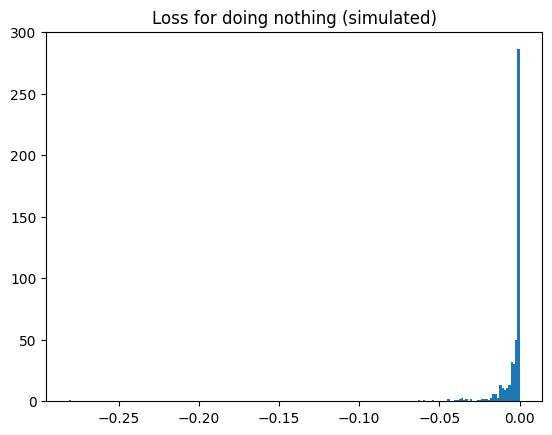

mean -0.004796699071095078
median -0.0007868649394742692


In [21]:
def null_policy(_:Observation) -> tuple[float, float]:
    return 0, 0

# test loss function
do_nothing_loss = []
for s0, s1 in idm_test_set:
    _, rew, _ = run_game(env, null_policy, (s0, s1))
    do_nothing_loss.append(rew)

plt.title("Loss for doing nothing (simulated)")
plt.hist(do_nothing_loss, bins=200)
plt.show()
print("mean", np.mean(do_nothing_loss))
print("median", np.median(do_nothing_loss))

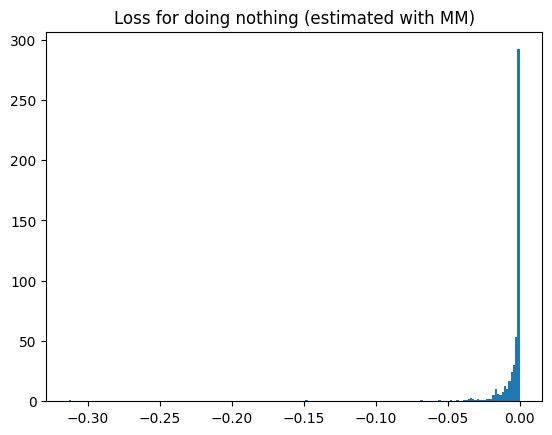

mean -0.005157038943531131
median -0.0007866724498738354


In [22]:
# test loss function
do_nothing_loss_est = []
for s0, s1 in idm_test_set:
    _, rew, pred_s1 = run_game_est(mm, null_policy, (s0, s1))
    do_nothing_loss_est.append(rew)

plt.title("Loss for doing nothing (estimated with MM)")
plt.hist(do_nothing_loss_est, bins=200)
plt.show()
print("mean", np.mean(do_nothing_loss_est))
print("median", np.median(do_nothing_loss_est))

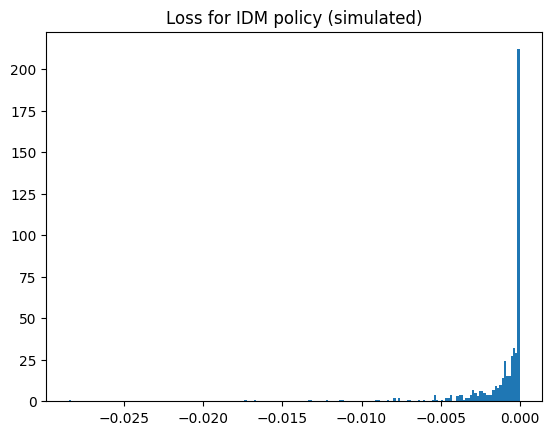

mean -0.001197618583159927
median -0.000347520508093457


In [25]:
# test loss function
idm_loss = []
for s0, s1 in idm_test_set:
    _, rew, _ = run_game(env, IDMPolicy(idm), (s0, s1))
    idm_loss.append(rew)

plt.title("Loss for IDM policy (simulated)")
plt.hist(idm_loss, bins=200)
plt.show()
print("mean", np.mean(idm_loss))
print("median", np.median(idm_loss))

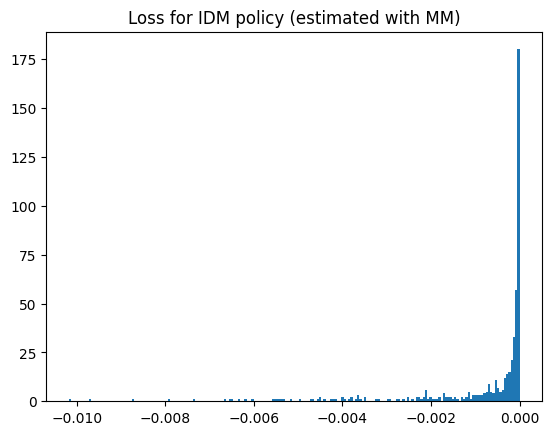

mean -0.000788531757071141
median -0.00013267315706945627


In [26]:
# test loss function
idm_loss_est = []
for s0, s1 in idm_test_set:
    _, rew, _ = run_game_est(mm, IDMPolicy(idm), (s0, s1))
    idm_loss_est.append(rew)

plt.title("Loss for IDM policy (estimated with MM)")
plt.hist(idm_loss_est, bins=200)
plt.show()
print("mean", np.mean(idm_loss_est))
print("median", np.median(idm_loss_est))

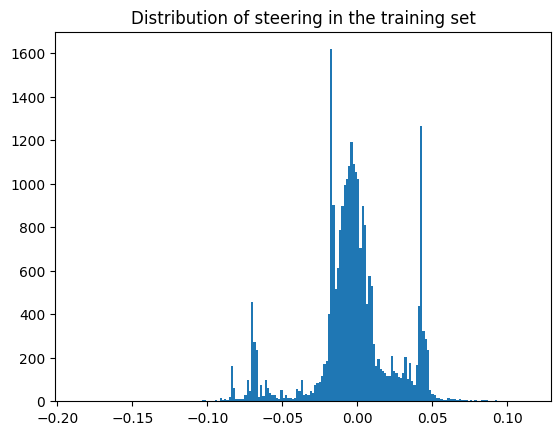

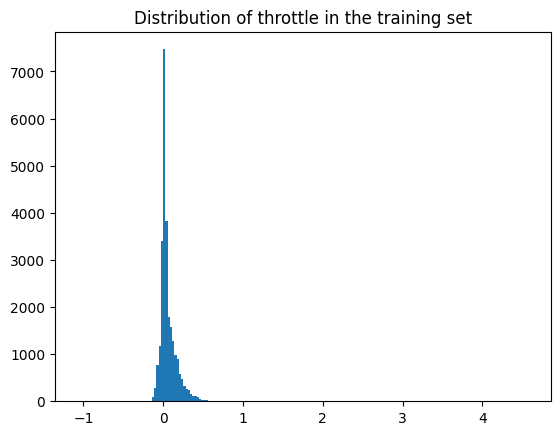

In [27]:
plt.title("Distribution of steering in the training set")
plt.hist(action_pred[:, 0].cpu().detach().numpy(), bins=200)
plt.show()

plt.title("Distribution of throttle in the training set")
plt.hist(action_pred[:, 1].cpu().detach().numpy(), bins=200)
plt.show()